# **1. Starting Setup**




In [1]:
!pip install \
  numpy==1.26.4 \
  pandas==2.1.4 \
  pyarrow==14.0.2 \
  datasets==2.18.0 \
  langchain==0.2.17 \
  langchain-core==0.2.43 \
  langchain-community==0.2.17 \
  langchain-text-splitters==0.2.4


In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
from datasets import Dataset

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("pyarrow:", pa.__version__)


numpy: 1.26.4
pandas: 2.1.4
pyarrow: 14.0.2


In [3]:
!pip install -q "transformers>=4.40.0" datasets accelerate bitsandbytes sentencepiece protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import pyarrow as pa
from datasets import Dataset

print(np.__version__)
print(pd.__version__)
print(pa.__version__)


1.26.4
2.1.4
14.0.2


In [5]:
import torch
import re
from tqdm import tqdm
from pathlib import Path
from datasets import Dataset

## 1.2 Setting runtime

In [6]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU. Go to Runtime → Change runtime type → set GPU.")

CUDA available: True
GPU: Tesla T4


## 1.3 Import Dataset

In [7]:
!git clone https://github.com/sooo66/semeval2026-task12-dataset.git
!ls semeval2026-task12-dataset

Cloning into 'semeval2026-task12-dataset'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 63 (delta 27), reused 46 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 6.71 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (27/27), done.
dev_data   sample_data			   test_data
README.md  semeval2026-task12-dataset-old  train_data


## 1.4 Constants definition

In [8]:


# Root of the cloned repo in Colab
DATA_ROOT = Path("/content/semeval2026-task12-dataset")

# Choose the split you want to evaluate: "train_data", "dev_data", or "sample_data"
SPLIT = "dev_data"  # you can change this

QUESTIONS_FILE = DATA_ROOT / SPLIT / "questions.jsonl"
DOCS_FILE      = DATA_ROOT / SPLIT / "docs.json"

print("Questions file:", QUESTIONS_FILE)
print("Docs file:", DOCS_FILE)

Questions file: /content/semeval2026-task12-dataset/dev_data/questions.jsonl
Docs file: /content/semeval2026-task12-dataset/dev_data/docs.json


 ## 1.5 Import Repository and load dataset

In [9]:

!git clone https://github.com/irenebartolini02/LLM-abductive-event-reasoning.git
%cd LLM-abductive-event-reasoning

Cloning into 'LLM-abductive-event-reasoning'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 154 (delta 79), reused 102 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (154/154), 430.99 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/LLM-abductive-event-reasoning


In [10]:
from utils.data_loader import load_jsonl, load_json, index_docs_by_topic

questions = load_jsonl(QUESTIONS_FILE)
docs = load_json(DOCS_FILE)
docs_by_topic = index_docs_by_topic(docs)

print("Num questions:", len(questions))
print("Num doc groups:", len(docs_by_topic))
print("Example question keys:", questions[0].keys())

Num questions: 400
Num doc groups: 36
Example question keys: dict_keys(['topic_id', 'id', 'target_event', 'option_A', 'option_B', 'option_C', 'option_D', 'golden_answer'])


## **1.6. Loading Model**



In [11]:
!pip install -U bitsandbytes

In [12]:

from utils.model_utils import load_model

# set yor model name
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"


model, tokenizer= load_model(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Model loaded on: cuda:0


# **2. RAG implementation**

## 2.1. Setup, divide doc in chuncks

**dividere i documenti in chunk e scegliere la dimensione**

In [13]:

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Strategia di Chunking: Recursive è meglio perché rispetta i paragrafi
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200, # Sovrapposizione per non perdere i nessi causali tra i pezzi
    separators=["\n\n", "\n", ".", " "]
)



In [14]:

!pip install json-repair
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 58.8 MB/s eta 0:00:00


**Modello ultra veloce per chunk embeddings**

In [15]:
# OPZIONE ULTRA-VELOCE:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"  # 17M parametri, 3x più veloce
)

/tmp/ipython-input-477497280.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**creare vocabolario chunks**

In [16]:
from langchain_core.documents import Document
from tqdm import tqdm

# Inizializza dizionario
vector_db_per_topic = dict()

print("Creating vector databases with chunk indices...")

for topic_id, docs_list in tqdm(docs_by_topic.items(), desc="Processing topics"):
    all_chunks = []

    # Per ogni documento nel topic
    for doc_idx, doc_dict in enumerate(docs_list):
        # 1. Crea Document
        doc = Document(
            page_content=doc_dict.get('content', ''),
            metadata={'title': doc_dict.get('title', '')}
        )

        # 2. Splitta in chunks
        chunks = text_splitter.split_documents([doc])

        # 3. ✓ AGGIUNGI METADATA con indici
        for chunk_idx, chunk in enumerate(chunks):
            chunk.metadata.update({
                'topic_id': topic_id,
                'doc_id': doc_idx,              # Posizione nel topic
                'chunk_index': chunk_idx,       # Posizione nel documento
                'total_chunks': len(chunks),
                'global_index': len(all_chunks), # Indice globale nel topic
                'title': doc_dict.get('title', '')
            })
            all_chunks.append(chunk)

    # 4. Crea vector DB per il topic
    if all_chunks:
        vector_db_per_topic[topic_id] = FAISS.from_documents(all_chunks, embeddings)
        print(f"  Topic {topic_id}: {len(all_chunks)} chunks from {len(docs_list)} docs")
    else:
        print(f"  ⚠ Topic {topic_id}: No chunks created")

print(f"\n✓ Created {len(vector_db_per_topic)} vector databases")

Creating vector databases with chunk indices...


Processing topics:   3%|▎         | 1/36 [00:01<01:08,  1.97s/it]

  Topic 1: 154 chunks from 17 docs


Processing topics:   6%|▌         | 2/36 [00:02<00:38,  1.14s/it]

  Topic 3: 131 chunks from 19 docs


Processing topics:   8%|▊         | 3/36 [00:02<00:24,  1.34it/s]

  Topic 4: 131 chunks from 15 docs


Processing topics:  11%|█         | 4/36 [00:03<00:25,  1.27it/s]

  Topic 2: 229 chunks from 16 docs


Processing topics:  14%|█▍        | 5/36 [00:04<00:21,  1.43it/s]

  Topic 5: 128 chunks from 16 docs


Processing topics:  17%|█▋        | 6/36 [00:04<00:20,  1.48it/s]

  Topic 6: 175 chunks from 16 docs


Processing topics:  19%|█▉        | 7/36 [00:05<00:16,  1.72it/s]

  Topic 7: 68 chunks from 14 docs


Processing topics:  22%|██▏       | 8/36 [00:05<00:17,  1.60it/s]

  Topic 8: 135 chunks from 16 docs


Processing topics:  25%|██▌       | 9/36 [00:06<00:19,  1.40it/s]

  Topic 9: 184 chunks from 18 docs


Processing topics:  28%|██▊       | 10/36 [00:07<00:20,  1.25it/s]

  Topic 10: 155 chunks from 17 docs


Processing topics:  31%|███       | 11/36 [00:10<00:32,  1.30s/it]

  Topic 11: 502 chunks from 22 docs


Processing topics:  33%|███▎      | 12/36 [00:11<00:32,  1.35s/it]

  Topic 12: 387 chunks from 25 docs


Processing topics:  36%|███▌      | 13/36 [00:12<00:27,  1.21s/it]

  Topic 13: 241 chunks from 21 docs


Processing topics:  39%|███▉      | 14/36 [00:14<00:28,  1.31s/it]

  Topic 14: 419 chunks from 17 docs


Processing topics:  42%|████▏     | 15/36 [00:15<00:27,  1.31s/it]

  Topic 15: 311 chunks from 31 docs


Processing topics:  44%|████▍     | 16/36 [00:16<00:26,  1.34s/it]

  Topic 16: 231 chunks from 18 docs


Processing topics:  47%|████▋     | 17/36 [00:17<00:22,  1.16s/it]

  Topic 17: 155 chunks from 22 docs


Processing topics:  50%|█████     | 18/36 [00:19<00:22,  1.25s/it]

  Topic 18: 274 chunks from 24 docs


Processing topics:  53%|█████▎    | 19/36 [00:20<00:19,  1.15s/it]

  Topic 19: 148 chunks from 24 docs


Processing topics:  56%|█████▌    | 20/36 [00:22<00:25,  1.57s/it]

  Topic 20: 306 chunks from 25 docs


Processing topics:  58%|█████▊    | 21/36 [00:23<00:21,  1.45s/it]

  Topic 21: 228 chunks from 29 docs


Processing topics:  61%|██████    | 22/36 [00:24<00:16,  1.20s/it]

  Topic 22: 104 chunks from 20 docs


Processing topics:  64%|██████▍   | 23/36 [00:25<00:16,  1.23s/it]

  Topic 23: 348 chunks from 24 docs


Processing topics:  67%|██████▋   | 24/36 [00:25<00:11,  1.06it/s]

  Topic 24: 122 chunks from 28 docs


Processing topics:  69%|██████▉   | 25/36 [00:26<00:09,  1.18it/s]

  Topic 25: 154 chunks from 18 docs


Processing topics:  72%|███████▏  | 26/36 [00:27<00:08,  1.17it/s]

  Topic 26: 290 chunks from 23 docs


Processing topics:  75%|███████▌  | 27/36 [00:27<00:06,  1.39it/s]

  Topic 27: 177 chunks from 25 docs


Processing topics:  78%|███████▊  | 28/36 [00:28<00:05,  1.59it/s]

  Topic 28: 183 chunks from 25 docs


Processing topics:  81%|████████  | 29/36 [00:28<00:04,  1.74it/s]

  Topic 29: 221 chunks from 23 docs


Processing topics:  83%|████████▎ | 30/36 [00:29<00:04,  1.30it/s]

  Topic 30: 567 chunks from 25 docs


Processing topics:  86%|████████▌ | 31/36 [00:30<00:04,  1.23it/s]

  Topic 31: 282 chunks from 27 docs


Processing topics:  89%|████████▉ | 32/36 [00:31<00:02,  1.40it/s]

  Topic 32: 206 chunks from 27 docs


Processing topics:  92%|█████████▏| 33/36 [00:31<00:01,  1.67it/s]

  Topic 33: 167 chunks from 18 docs


Processing topics:  94%|█████████▍| 34/36 [00:32<00:01,  1.77it/s]

  Topic 34: 251 chunks from 24 docs


Processing topics:  97%|█████████▋| 35/36 [00:32<00:00,  2.15it/s]

  Topic 35: 118 chunks from 23 docs


Processing topics: 100%|██████████| 36/36 [00:32<00:00,  1.10it/s]

  Topic 36: 145 chunks from 23 docs

✓ Created 36 vector databases


In [17]:
!pip install langchain-experimental==0.0.64


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 6.2 MB/s eta 0:00:00


In [18]:
!pip install langchain-huggingface==0.0.3


**Causal RAG implementation**

In [ ]:
import torch
import re
from tqdm import tqdm
from pathlib import Path
from datasets import Dataset
from matplotlib import pyplot as plt
from langchain_community.llms import HuggingFacePipeline
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever
from tqdm import tqdm
from transformers import pipeline
import networkx as nx
from typing import List, Set, Dict, Tuple
import re
import json
from rank_bm25 import BM25Okapi # Add this import for BM25Okapi

class CausalRAG:
    def __init__(self, model, tokenizer, k=3, s=3):
        """
        Args:
            k: number of initial nodes to retrieve (top-k similarity)
            s: expansion steps in the graph
        """
        self.k = k
        self.s = s

        # Setup LLM Qwen
        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=512,
            temperature=0.1,  # Low temperature for more deterministic responses
        )
        self.llm = HuggingFacePipeline(pipeline=pipe)

        # Setup embeddings vor internal vector DB
        self.embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2"
        )

        self.bm25_retriever=None
        self.node_list=[]
        self.graph = nx.DiGraph()
        self.vector_store = None
        self.node_to_content = {}

    # RICHIESTA A QWEN PER ESTRARRE IL GRAFO
    def extract_causal_graph_manual(self, text: str) -> List[Tuple[str, str, str]]:
        """
        Extract causal relationships using Qwen with explicit chat roles.
        
        Returns a list of json (cause, relation, effect).
        json:
        - cause_atomic => node id
        - cause_full => full node content 
        - relation => edge
        - effect_atomic => node id 
        - effect_full => full node content
        """
        system_content = """You are a Causal Intelligence Agent.
          Your goal is to find connections even when they are implicit.

          CRITICAL INSTRUCTIONS:
          - If the text says "A happened, and then B occurred", evaluate if A influenced B and extract it.
          - Look for trigger words: "led to", "influenced", "resulted in", "after which", "following", "response to".
          - Don't be afraid to extract multiple small steps.
          - If you find NO relations, output exactly: [] (nothing else)."""


        user_content = f"""Extract ALL causal relations from the text below.
          STRICT RULES:
          1. NO MISSING LINKS: If a chain of events exists, extract every link.
          2. CONSISTENT NAMING: Use the same 'cause_atomic' name if the event repeats in the text.
          3. GRANULARITY: Extract at least 3-5 relations per paragraph if present.

          FORMAT EXAMPLE:
          Text: "The heavy rain led to a flood which then caused the bridge to collapse."
          Output:
          [
            {{"cause_atomic": "Heavy rain", "cause_full": "Persistent heavy rainfall", "relation": "CAUSES", "effect_atomic": "Flooding", "effect_full": "River overflow and flooding"}},
            {{"cause_atomic": "Flooding", "cause_full": "River overflow and flooding", "relation": "CAUSES", "effect_atomic": "Bridge collapse", "effect_full": "Structural failure of the bridge"}}
          ]

          TEXT TO ANALYZE:
          {text}"""

        messages = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_content},
        ]

        try:
            # Usa il chat template ufficiale Qwen
            prompt = self.llm.pipeline.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            with torch.no_grad():
              outputs = model.generate(
              **inputs,
              max_new_tokens=2000,
              do_sample=False,      # Determinism
              temperature=0.0,
              pad_token_id=tokenizer.eos_token_id
            )

            # Decoding e Cleaning
            generated_ids = outputs[0][inputs.input_ids.shape[1]:]
            raw_response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            clean_res= self._parse_causal_response(raw_response)
            return clean_res

        except Exception as e:
            print(f"Error extracting causal graph: {e}")
            return []



    def _parse_causal_response(self, response: str) -> List[dict]:
        """Parse the LLM response assuming a JSON list of objects.

           Returns list of json:
           
            "cause" => node id 
            "cause_full"=> full node content
            "relation"=> type of causal relation
            "effect"=> node id 
            "effect_full"=> full node content
            
        
        """
        relations = []
        if not response or not isinstance(response, str):
            return relations

        # 1. Pulizia e ricerca del blocco JSON
        # Cerchiamo il match più ampio possibile tra parentesi quadre
        match = re.search(r'\[\s*\{.*\}\s*\]', response, re.DOTALL)

        if match:
            clean_json = match.group(0)
        else:
            # Se non c'è una lista, cerchiamo un oggetto singolo
            match_single = re.search(r'\{.*\}', response, re.DOTALL)
            if match_single:
                clean_json = "[" + match_single.group(0) + "]"
            else:
                # Se l'LLM ha risposto "No relations found"
                return []

        # 2. Parsing (fuori dai blocchi if/else precedenti)
        try:
            data = json.loads(clean_json)

            if isinstance(data, dict):
                data = [data]

            for item in data:
                # Controllo robusto delle chiavi (usiamo i nomi estratti dal tuo prompt)
                c_atomic = item.get("cause_atomic")
                rel = item.get("relation")
                e_atomic = item.get("effect_atomic")

                if c_atomic and rel and e_atomic:
                    relations.append({
                        "cause": str(c_atomic).strip(),
                        "cause_full": str(item.get("cause_full", c_atomic)).strip(),
                        "relation": str(rel).upper(),
                        "effect": str(e_atomic).strip(),
                        "effect_full": str(item.get("effect_full", e_atomic)).strip()
                    })

        except json.JSONDecodeError as e:
            # Se fallisce, stampiamo solo l'inizio per debug
            print(f"JSON Decode Error: {e} | Preview: {clean_json[:50]}...")
        except Exception as e:
            print(f"General parsing error: {e}")

        return relations



    # DATI TUTTI I CUNKS RELATIVI AD UN TOPIC ID GENERA e POPOLA IL GRAFO
    def index_documents(self, chunks: List[str]):
        """Manual extraction using Qwen """

        print(f"Indexing {len(chunks)} chunks...")
 

        pbar = tqdm(total=len(chunks), desc="Graph Extraction", unit="chunk")

        for chunk in chunks:
            try:
                # Manual extraction instead of transformer
                relations = self.extract_causal_graph_manual(chunk.page_content)

                for rel in relations:
                    # Trasformiamo l'atomic name in un ID standardizzato
                    c_id = rel["cause"].lower().strip().replace(".", "")
                    e_id = rel["effect"].lower().strip().replace(".", "")

                    # Iteriamo su causa ed effetto per registrarli nel grafo
                    nodes_to_process = [
                        (c_id, rel["cause_full"]),
                        (e_id, rel["effect_full"])
                    ]

                    for nid, full_text in nodes_to_process:
                        if nid not in self.graph:
                            # NODO NUOVO:
                            self.graph.add_node(nid)
                            self.node_to_content[nid] = full_text
                          
                        else:
                          # NODO GIA' PRESENTE
                            existing_content = self.node_to_content.get(nid, "")
                            if full_text not in existing_content:
                              # Aggiungiamo il nuovo dettaglio separato da ","
                              self.node_to_content[nid] = existing_content + "," + full_text


                    # Aggiunta dell'Arco (Relazione)
                    self.graph.add_edge(
                        c_id,
                        e_id,
                        relation=rel["relation"],
                        # Opzionale: salviamo anche qui i testi originali per debug
                        cause_text=self.node_to_content[c_id],
                        effect_text=self.node_to_content[e_id],
                        )

                pbar.update(1)
            except Exception as e:
                print(f"Error chunk: {e}")
                pbar.update(1)
                continue

        pbar.close()

        node_ids = []
        all_contents = []
        
        # Preparo le liste dei nodi da inserire nei vector store 
        for nid, content in self.node_to_content.items():
            node_ids.append(nid)
            all_contents.append(content)

        if not node_ids:
            print("⚠ No nodes extracted")
            return
        
        # 1. FAISS VECTOR STORE (Inizializzato una volta sola con TUTTI i testi)
        metadatas = [{"node_id": nid} for nid in node_ids]
        self.vector_store = FAISS.from_texts(
            texts=all_contents,
            embedding=self.embeddings,
            metadatas=metadatas
        )

        # 2. BM25 INDEX
        # BM25 ha bisogno di un corpus tokenizzato: List[List[str]]
        documents = [
            Document(page_content=content, metadata={"node_id": nid})
            for nid, content in zip(node_ids, all_contents)
        ]
        self.bm25_retriever = BM25Retriever.from_documents(documents)
        # necessario preimpostare il numero di documenti da recuperare:
        self.bm25_retriever.k = self.k * 2  
        self.node_list = list(self.graph.nodes())
        
        print(f"✓ Graph created: {self.graph.number_of_nodes()} nodes, "
        f"{self.graph.number_of_edges()} edges")


    # SCEGLIER I NODI DI PARTENZA  PIù AFFINI
    def retrieve_relevant_nodes(self, query: str) -> List[str]:
      """
      Hybrid Search utilizzando la Reciprocal Rank Fusion (RRF)
      """
      if not self.bm25_retriever or not self.vector_store:
          return []

      # 1. Ottieni i ranking da BM25 
      result_docs = self.bm25_retriever.get_relevant_documents(query)
      bm25_results = [doc.metadata['node_id'] for doc in result_docs]

      # 2. Ottieni i ranking da FAISS
      semantic_results = self.vector_store.similarity_search_with_score(query, k=self.k *2)
      faiss_results = [doc.metadata['node_id'] for doc, score in semantic_results]

      # 3. Reciprocal Rank Fusion (RRF)
      # Calcola un punteggio combinato: più un nodo è in alto in entrambe le liste, meglio è.
      rrf_scores = {}
      k_constant = 60 # Valore standard per RRF per bilanciare i rank

      for rank, node_id in enumerate(bm25_results):
          rrf_scores[node_id] = rrf_scores.get(node_id, 0) + 1.0 / (k_constant + rank)

      for rank, node_id in enumerate(faiss_results):
          rrf_scores[node_id] = rrf_scores.get(node_id, 0) + 1.0 / (k_constant + rank)

      # 4. Ordina i nodi in base allo score RRF finale
      sorted_nodes = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)

      # Debug: vedi quali nodi hanno fatto "match" in entrambi
      combined_hits = [node for node in bm25_results if node in faiss_results]
      print(f"Nodi trovati da entrambi: {combined_hits}")

      
      return [node for node, score in sorted_nodes[:self.k]]

    # PARTENDO DAI NODI INIZIALI ESPANDARE IL SOTTOGRAFO SEGUENDO GLI ARCHI
    def expand_nodes(self, initial_nodes: List[str]) -> Set[str]:
        """
        Espande i nodi per s passi (Breadth-First Search)
        """
        expanded = set(initial_nodes)
        current_layer = set(initial_nodes)

        for step in range(self.s):
            next_layer = set()
            for node in current_layer:
                if node in self.graph:
                    # Prende vicini entranti e uscenti
                    neighbors = set(self.graph.predecessors(node)) | set(self.graph.successors(node))
                    # Consideriamo solo i vicini che non abbiamo ancora esplorato
                    new_neighbors = neighbors - expanded
                    next_layer.update(new_neighbors)

            if not next_layer:
                break

            expanded.update(next_layer)
            current_layer = next_layer # Il prossimo giro parte dai nodi appena trovati

        return expanded

     # PARTENDO DAI NODI INIZIALI ESPANDARE IL SOTTOGRAFO SEGUENDO GLI ARCHI IN DIREZIONE PREDEFINITA
    def expand_directional(self, initial_nodes: List[str], direction: str) -> Set[str]:
        """
        direction: 'forward' per le cause (successors),
                'backward' per gli effetti (predecessors)
        """
        expanded = set(initial_nodes)
        current_layer = set(initial_nodes)

        for step in range(self.s):
            next_layer = set()
            for node in current_layer:
                if node in self.graph:
                    if direction == 'forward':
                        # Seguiamo la freccia: cosa causa questo nodo?
                        neighbors = set(self.graph.successors(node))
                    else:
                        # Risaliamo la freccia: da cosa è causato questo nodo?
                        neighbors = set(self.graph.predecessors(node))

                    new_neighbors = neighbors - expanded
                    next_layer.update(new_neighbors)

            if not next_layer:
                break

            expanded.update(next_layer)
            current_layer = next_layer

        return expanded

    # INTERO PROCESSO DI SELEZIONE DEI NODI E DI RILEVAMENTO DI PERCORSI CAUSALI
    def find_all_causal_paths(self, relevant_nodes, cause_ids, effect_ids) -> Tuple[bool, List[List[str]]]:
      """
      Trova TUTTI i path causali tra causa ed effetto
      Returns: (has_paths, list_of_paths)
      """

      if not cause_ids or not effect_ids:
          return False, []

      subgraph = self.graph.subgraph(relevant_nodes)

      # DEBUG
      # 2. Prepariamo i colori dei nodi
      color_map = []
      for node in subgraph.nodes():
        if node in cause_ids:
            color_map.append('red')       # Nodo Causa
        elif node in effect_ids:
            color_map.append('green')     # Nodo Effetto
        else:
            color_map.append('skyblue')   # Nodi intermedi (il percorso)

        # 3. Visualizzazione
      plt.figure(figsize=(12, 8))
      # Aumentiamo k per distanziare meglio i nodi se sono molti
      pos = nx.spring_layout(subgraph, seed=42, k=1.5)

      nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_color=color_map, # Usiamo la mappa dei colori creata
        node_size=2500,
        font_size=8,
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        edge_color='gray',
        alpha=0.9
      )

      plt.title(f"Analisi Percorso: Rosso (Causa) -> Verde (Effetto)")
      plt.show()


      all_paths = []

      for c_node in cause_ids:
          for e_node in effect_ids:
              if c_node == e_node:
                  #nota se nodo causa è uguale a nodo effetto la relazione è auto-contenuta
                  all_paths.append([c_node])
                  continue
              try:
                  has_path= nx.has_path(subgraph, c_node, e_node)
                  if has_path:
                      # Trova TUTTI i path semplici (senza cicli)
                      paths = list(nx.all_simple_paths(
                          subgraph,
                          c_node,
                          e_node,
                          cutoff=self.s + 1  # Limita lunghezza
                      ))
                      # Filtra path validi
                      all_paths.extend(paths)

              except Exception as e:
                  print(f"Errore: {e}")
                  continue

      # Ordina per qualità (path più corti = più forti causalmente)
      all_paths.sort(key=len)

      return len(all_paths) > 0, all_paths[:self.k]


    def is_causal_relation(self, cause: str, effect: str) -> Dict:
        """
        Pipeline completa per verificare se causa → effetto
        """
        # Step 1: Recupera nodi rilevanti per entrambi gli eventi
        cause_ids = self.retrieve_relevant_nodes(cause)
        effect_ids = self.retrieve_relevant_nodes(effect)
        print(f"cause nodes: {len(cause_ids)}, effect nodes {len(effect_ids)} ")

        # Step 2: Espandi i nodi
        expanded_cause = self.expand_directional(cause_ids, "forward")
        expanded_effect = self.expand_directional(effect_ids, "backward")

        print(f"expanded cause nodes: {len(expanded_cause)}, expanded effect nodes {len(expanded_cause)} ")

        # Unisci i sottografi
        relevant_nodes = expanded_cause.union(expanded_effect).union(set(cause_ids)).union(set(effect_ids))

        # Step 3: Cerca percorso causale
        has_path, all_found_paths = self.find_all_causal_paths(relevant_nodes, cause_ids, effect_ids)

        # Step 4: Costruisci contesto per LLM
        context_parts = []
        context = "" 

        if has_path:
            # Aggiungi relazioni del percorso per tutti i path trovati
            for path_segment in all_found_paths: # Iterate through each individual path
                if len(path_segment)==1:
                  context_parts.append(f"\n- {path_segment[0]}")
                  continue
                for i in range(len(path_segment) - 1):
                    u = path_segment[i]
                    v = path_segment[i+1]
                    if self.graph.has_edge(u, v):
                        edge_data = self.graph[u][v]
                        rel = edge_data.get('relation', 'unknown_relation' ).lower()
                        # Use cause_text and effect_text from edge_data for full text
                        cause_text = edge_data.get('cause_text', u)
                        effect_text = edge_data.get('effect_text', v)

                        # eliminare il punto se presente
                        if cause_text.endswith(('.', ';')):
                            cause_text = cause_text[:-1]

                        # iniziale minuscola
                        effect_text = effect_text[0].lower() + effect_text[1:]
                        rel = rel.replace("_", " ")
                        context_parts.append(f"- {cause_text} --[{rel}]--> {effect_text.lower()}")

            context = "\n".join(context_parts) # Join all parts once after processing all paths


        return {
            "has_path": has_path,
            "context":context
            }


    def visualize(self):
        """Disegna il grafo della causalità."""
        plt.figure(figsize=(10, 6))
        pos = nx.spring_layout(self.graph, seed=42, k=2) # Layout elastico
        nx.draw(self.graph, pos, with_labels=True, node_color='skyblue',
                node_size=2000, font_size=9, font_weight='bold', arrows=True, arrowsize=20)
        plt.title("Grafo degli Eventi Causali")
        plt.show()

    def merge_similare_nodes(self, possible_node_to_fuse_ids):
        """
        Chiede a Qwen di valutare la fusione di nodi simili e aggiorna la struttura del grafo.
        """
        if not possible_node_to_fuse_ids:
            return

        # 1. Ricostruzione dati per il prompt
        nodes_data = []
        for nid in possible_node_to_fuse_ids:
            content = self.node_to_content.get(nid, {})
            # Gestione flessibile se content è stringa o dict
            details = content.get('text', str(content)) if isinstance(content, dict) else str(content)
            nodes_data.append({
                "EVENT_TITLE": nid,
                "EVENT_DETAILS": details
            })

        system_content = """You are a Causal Intelligence Agent.
    Your goal is to inspect the events and detect which are the same concept.
    If they should be fused, produce a SINGLE fused EVENT_TITLE and a summary EVENT_DETAILS.
    IMPORTANT: If the events are different (e.g., different countries or opposite actions), DO NOT fuse them; return them as separate items.
    Return ONLY a valid JSON list of objects."""

        user_content = f"""Analyze these events and fuse only those that represent the same entity or occurrence.
    Input:
    {json.dumps(nodes_data, indent=2)}

    Output format:
    [
      {{
        "EVENT_TITLE": "Final Title",
        "EVENT_DETAILS": "Combined details",
        "FUSED": ["Original Title 1", "Original Title 2"]
      }}
    ]
    """
        messages = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_content},
        ]

        # 2. Generazione con Qwen
        prompt = self.llm.pipeline.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.llm.pipeline.tokenizer(prompt, return_tensors="pt").to(self.llm.pipeline.model.device)

        outputs = self.llm.pipeline.model.generate(
            **inputs,
            max_new_tokens=2000,
            do_sample=False,
            temperature=0.0,
            pad_token_id=self.llm.pipeline.tokenizer.eos_token_id
        )

        generated_ids = outputs[0][inputs.input_ids.shape[1]:]
        raw_response = self.llm.pipeline.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # 3. Parsing del JSON (rimozione di eventuale markdown ```json ... ```)
        try:
            json_str = re.search(r'\[.*\]', raw_response, re.DOTALL).group()
            fused_results = json.loads(json_str)
        except Exception as e:
            print(f"Errore nel parsing JSON di Qwen: {e}")
            return

        # 4. Aggiornamento del Grafo (Logica di Re-wiring)
        for group in fused_results:
            new_title = group["EVENT_TITLE"]
            new_details = group["EVENT_DETAILS"]
            original_nodes = group.get("FUSED", [])

            if not original_nodes: continue

            # Crea il nuovo nodo se non esiste
            if new_title not in self.graph:
                self.graph.add_node(new_title)

            self.node_to_content[new_title] = {"text": new_details}

            for old_node in original_nodes:
                if old_node == new_title or old_node not in self.graph:
                    continue

                # Sposta gli archi uscenti: (old_node -> neighbor) diventa (new_title -> neighbor)
                for neighbor in list(self.graph.successors(old_node)):
                    edge_data = self.graph.get_edge_data(old_node, neighbor)
                    self.graph.add_edge(new_title, neighbor, **edge_data)

                # Sposta gli archi entranti: (predecessor -> old_node) diventa (predecessor -> new_title)
                for predecessor in list(self.graph.predecessors(old_node)):
                    edge_data = self.graph.get_edge_data(predecessor, old_node)
                    self.graph.add_edge(predecessor, new_title, **edge_data)

                # Rimuovi il vecchio nodo
                self.graph.remove_node(old_node)
                if old_node in self.node_to_content:
                    old_content= self.node_to_content[old_node]
                    del self.node_to_content[old_node]
                print(f"✓ Fuso node ID: {old_node} ---> {new_title}")
                print(f"✓ Content: {old_content} ---> {new_details}")



    def merge_nodes_and_sync_db(self, threshold=0.85):
        """
        Fonde i nodi simili nel grafo e ricostruisce il Vector Store FAISS
        per evitare errori di 'Node not in G'.
        """
        print(f"Inizio pulizia grafo: {len(self.graph.nodes)} nodi attuali.")

        nodes = list(self.graph.nodes())

        for i in range(len(nodes)):
            u = nodes[i]
            if u not in self.graph: continue

            possible_node_to_fuse=[]
            for j in range(i + 1, len(nodes)):
                v = nodes[j]
                if v not in self.graph: continue

                score = SequenceMatcher(None, u, v).ratio()
                if score >= threshold:
                    possible_node_to_fuse.append(v)

            if possible_node_to_fuse:
                possible_node_to_fuse.append(u)
                # Fare richiesta a qwen
                self.merge_similare_nodes(possible_node_to_fuse)

        # 3. RICOSTRUZIONE TOTALE DEL VECTOR STORE (FAISS)
        remaining_nodes = list(self.graph.nodes())
        # Prepariamo i nuovi dati basandoci SOLO su ciò che è rimasto nel grafo
        new_texts = []
        new_metadatas = []

        for nid in remaining_nodes:
            # Recuperiamo il testo pulito (o l'ID stesso se manca il contenuto)
            content = self.node_to_content.get(nid, str(nid))
            if isinstance(content, dict):
                content = content.get('text', str(content))

            new_texts.append(str(content))
            new_metadatas.append({"node_id": nid})

        # Sovrascriviamo il vecchio vector_store con uno nuovo di zecca
        self.vector_store = FAISS.from_texts(
            texts=new_texts,
            embedding=self.embeddings,
            metadatas=new_metadatas
        )
        # BM25 lavora su una lista di oggetti Documents
        new_docs = [
            Document(page_content=t, metadata=m)
            for t, m in zip(new_texts, new_metadatas)
        ]
        self.bm25_retriever = BM25Retriever.from_documents(new_docs)

        print(f"✓ Sincronizzazione completata.")
        print(f"✓ Nodi finali nel grafo: {len(self.graph.nodes)}")
        print(f"✓ Nodi finali nel DB: {len(new_texts)}")

# ============================================================================
# UTILIZZO PER SEMEVAL
# ============================================================================

def generate_causal_summary(causal_rag: CausalRAG,  cause, effect) :
    """
    Valuta un entry SemEval con CausalRAG
    """
        # Verifica causalità
    result = causal_rag.is_causal_relation(
            cause=cause,
            effect=effect
        )

    return result['context'], result['has_path']

## IDEA GENERALE:
0. tramite preprocessing generare il grafo di ogni topic_id nel dataset (va fatto solo la prima volta le successive basterà fare load)
1. cercare i nodi più simili a causa (Option_x) e effetto (target_event)
2. cercare il/i percorso/i più veloce/i che li collega e generare il causal summary


# Creazione del grafo - Runnare solo per generarne uno nuovo se no scaricare da zip è più veloce

In [ ]:
#NON RUNNARE 
# SE NON VUOI RICREARE IL GRAFO PER IL TOPIC 1, scaricalo direttamente da quello salvato
import json
topic_id=1
vector_db = vector_db_per_topic.get(topic_id)

if vector_db:
    # Trucco per estrarre tutti i documenti da FAISS:
    # Accediamo alla memoria interna (docstore)
    all_dict = vector_db.docstore._dict
    chunks_from_db = list(all_dict.values())
    causal_rag_id_1 = CausalRAG(model, tokenizer, k=5, s=5)
    # Ora puoi passarli al CausalRAG
    causal_rag_id_1.index_documents( [doc for doc in chunks_from_db])

Device set to use cuda:0
/tmp/ipython-input-2285996387.py:39: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  self.llm = HuggingFacePipeline(pipeline=pipe)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Indexing 154 chunks...


Graph Extraction:   0%|          | 0/154 [00:00<?, ?chunk/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


KeyboardInterrupt: 

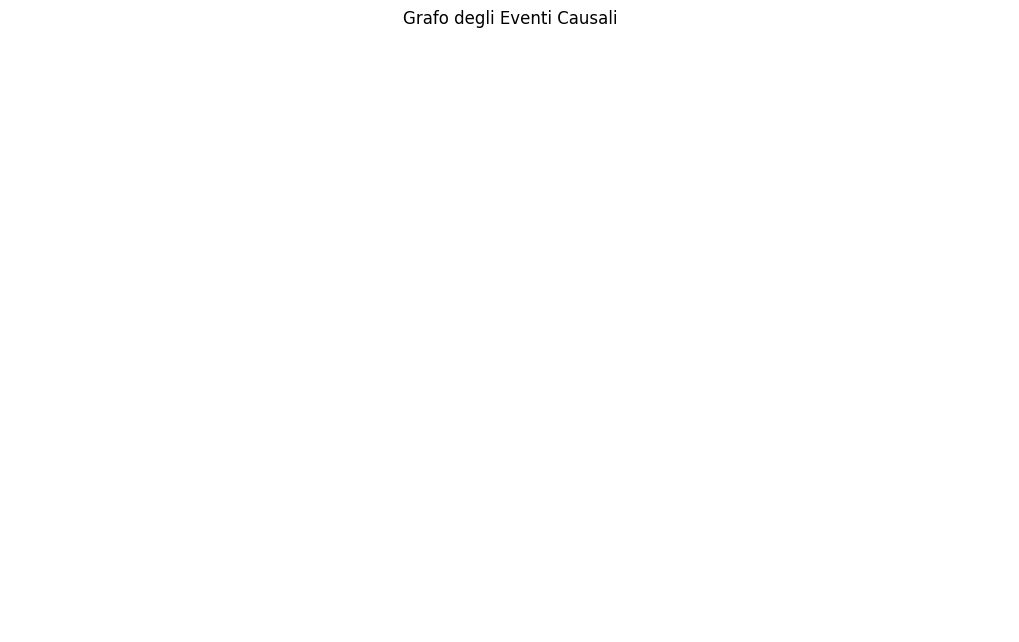

In [21]:
causal_rag_id_1.visualize()

In [ ]:
import shutil
import os
import pickle
save_causal_rag(causal_rag_id_1, 1, folder="causal_data")

In [ ]:
import shutil
import os

# Definisci il percorso della cartella da zippare e il nome del file finale
folder_to_zip = '/content/LLM-abductive-event-reasoning/causal_data'
output_filename = '/content/causal_rag_dataset'

# Crea il file zip
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"File {output_filename}.zip creato con successo! ora puoi scaricarlo manualmente")

# Load e store graph and vector db

In [ ]:
def save_causal_rag(causal_rag, topic_id, folder="causal_data"):
    """Salva l'intero stato del CausalRAG"""
    topic_folder = os.path.join(folder, f"topic_{topic_id}")
    if not os.path.exists(topic_folder):
        os.makedirs(topic_folder)

    # 1. Salva il Grafo NetworkX
    with open(os.path.join(topic_folder, "graph.pkl"), "wb") as f:
        pickle.dump(causal_rag.graph, f)

    # 2. Salva la Mappa node_to_content
    with open(os.path.join(topic_folder, "node_map.pkl"), "wb") as f:
        pickle.dump(causal_rag.node_to_content, f)

    # 3. Salva il Vector Store (FAISS)
    if causal_rag.vector_store:
        causal_rag.vector_store.save_local(os.path.join(topic_folder, "faiss_index"))

    print(f"✓ Dati salvati correttamente per il topic {topic_id}")

from langchain_core.documents import Document
from langchain_community.retrievers import BM25Retriever

# RICARICA IL CAUSAL RAG DA DISCO, nel futuro inserire nella classe CausalRAG
def load_causal_rag(causal_rag, topic_id, folder="causal_data"):
    """
    Ricarica i dati e ricostruisce il BM25Retriever basandosi sui nodi salvati
    """
    topic_folder = os.path.join(folder, f"topic_{topic_id}")
    if not os.path.exists(topic_folder):
        raise FileNotFoundError(f"Cartella non trovata: {topic_folder}")

    # 1. Carica il Grafo
    with open(os.path.join(topic_folder, "graph.pkl"), "rb") as f:
        causal_rag.graph = pickle.load(f)

    # 2. Carica la Mappa node_to_content
    with open(os.path.join(topic_folder, "node_map.pkl"), "rb") as f:
        causal_rag.node_to_content = pickle.load(f)

    # 3. Carica il Vector Store (FAISS)
    vs_path = os.path.join(topic_folder, "faiss_index")
    causal_rag.vector_store = FAISS.load_local(
        vs_path,
        causal_rag.embeddings,
        allow_dangerous_deserialization=True
    )

    # --- RICOSTRUZIONE BM25RETRIEVER ---
    # 4. Creiamo la lista di Documenti partendo dalla node_map caricata
    documents = []
    for nid, content in causal_rag.node_to_content.items():
        documents.append(Document(
            page_content=content, 
            metadata={"node_id": nid}
        ))

    if documents:
        # Inizializziamo il retriever con i documenti ricostruiti
        causal_rag.bm25_retriever = BM25Retriever.from_documents(documents)
        # Sincronizziamo il parametro k (opzionale ma consigliato)
        causal_rag.bm25_retriever.k = causal_rag.k * 2
        
    causal_rag.node_list = list(causal_rag.graph.nodes())
    # -----------------------------------

    print(f"✓ Oggetto Ricostruito: {len(causal_rag.node_list)} nodi. BM25Retriever pronto.")
    return causal_rag

## test per vedere se funzionava

In [ ]:
import shutil
import os

# Definisci il percorso della cartella da zippare e il nome del file finale
folder_to_zip = '/content/LLM-abductive-event-reasoning/causal_rag_dataset'
output_filename = '/content/causal_rag_dataset'

# Crea il file zip
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"File {output_filename}.zip creato con successo! ora puoi scaricarlo manualmente")

File /content/causal_rag_dataset.zip creato con successo! ora puoi scaricarlo manualmente


# Experiments

In [46]:


def format_qwen_prompt_binary(tokenizer, entry, context_text, option_label):
    """
    Formatta il prompt per una singola opzione in modalità binaria (TRUE/FALSE).

    Args:
        tokenizer: Il tokenizer del modello Qwen.
        SYSTEM_PROMPT: Il prompt di sistema "Causal Reasoning Verifier" che abbiamo scritto.
        entry: L'elemento del dataset (contiene 'target_event' e le opzioni).
        context_text: Il contesto recuperato (idealmente specifico per quell'opzione).
        option_label: La lettera dell'opzione da valutare (A, B, C o D).
    """

    event = entry.get('target_event')

    # Recuperiamo il testo dell'opzione specifica (es. entry['option_A'])
    option_text = entry.get(f'option_{option_label}')

    system_content = """You are a Causal Reasoning Verifier.
      Your goal is to validate if a causal path exists between two events based ON THE PROVIDED CONTEXT.
      Answer TRUE if the context shows that the Candidate Cause STARTS a chain of events that leads to the Target Event.
      Answer FALSE only if there is no logical connection or if the context contradicts the link."""

    user_content = f"""TARGET EVENT: "{event}"
      CANDIDATE CAUSE: "{cause}"
      CONTEXT:
      {context_text}

      Does the Candidate Cause lead to the Target Event according to the causal chains in the context?
      Answer (TRUE/FALSE):"""

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content}
    ]

    # Utilizziamo l'apply_chat_template del tokenizer per mantenere il formato <|im_start|>
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    return prompt

def clean_verifier_response(raw_response: str) -> str:
    """Estrae TRUE o FALSE ignorando spiegazioni o spazi bianchi."""
    # Convertiamo tutto in maiuscolo per sicurezza
    text = raw_response.upper().strip()

    # Cerchiamo se la stringa INIZIA con TRUE o FALSE (caso più comune)
    if text.startswith("TRUE"):
        return "TRUE"
    if text.startswith("FALSE"):
        return "FALSE"

    # Se il modello ha scritto "The answer is TRUE", cerchiamo la parola ovunque
    if "TRUE" in text:
        return "TRUE"
    if "FALSE" in text:
        return "FALSE"

    return "FALSE" # Default in caso di incertezza

In [ ]:
from sentence_transformers import CrossEncoder
import torch


def retrieve_causal_summary_3(causal_rag, cause, effect):
    summary_path, has_path = generate_causal_summary(causal_rag, cause, effect)
    summary=""
    if not has_path or len(summary_path) < 30:
        print("\n NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione")

        # 1. Recupero nodi rilevanti per entrambi i poli (Causa ed Effetto)
        cause_ids = causal_rag.retrieve_relevant_nodes(cause)
        effect_ids = causal_rag.retrieve_relevant_nodes(effect)

        # 2. Espansione bidirezionale
        # Espandiamo in AVANTI dalla causa (cosa provoca la causa?)
        cause_extended = causal_rag.expand_directional(cause_ids, "forward")
        # Espandiamo all'INDIETRO dall'effetto (da cosa è causato l'effetto?)
        effect_extended = causal_rag.expand_directional(effect_ids, "backward")

        # Unione dei nodi per creare un sottografo di contesto
        all_relevant_ids = set(cause_extended) | set(effect_extended)
        subgraph = causal_rag.graph.subgraph(all_relevant_ids)

        # 3. Serializzazione Archi (Relazioni)
        relations = []
        nodes_with_edges = set()

        for u, v, data in subgraph.edges(data=True):
            c_text = data.get('cause_text', u)
            e_text = data.get('effect_text', v)
            rel = data.get('relation', 'leads to').replace("_", " ")
            relations.append(f"- {c_text} --[{rel}]--> {e_text.lower()}")

            nodes_with_edges.update([u, v])

        # 4. Recupero Nodi "Orfani" o Specifici (Dettagli aggiuntivi su causa ed effetto)
        cause_context = []
        effect_context = []


        for node_id in cause_ids:
            if node_id not in nodes_with_edges:
                node_text = causal_rag.graph.nodes[node_id].get('text', node_id)
                cause_context.append(f"- Cause detail: {node_text}")

        for node_id in effect_ids:
            if node_id not in nodes_with_edges:
                node_text = causal_rag.graph.nodes[node_id].get('text', node_id)
                effect_context.append(f"- Target detail: {node_text}")

        # 5. Composizione del Summary
        summary_parts = []

        if relations:
            summary_parts.append("Relevant causal chains in context:\n" + "\n".join(list(set(relations))[:12]))

        if cause_context:
            summary_parts.append("Additional context on Candidate Cause:\n" + "\n".join(list(set(cause_context))[:5]))

        if effect_context:
            summary_parts.append("Additional context on Target Event:\n" + "\n".join(list(set(effect_context))[:5]))

        if not summary_parts:
            summary = "No direct path or relevant context found."
        else:
            summary = "Direct path not found. Contextual evidence found through bidirectional search:\n\n" + "\n\n".join(summary_parts)

    summary= summary_path + summary
    return summary


In [ ]:
# Nota bene è necessario caricare manualmente il file zip contenente il gravo per testare
!unzip '/content/rag_graph_1 (1).zip' -d /content/rag_graph

Archive:  /content/rag_graph_1 (1).zip
   creating: /content/rag_graph/topic_1/
   creating: /content/rag_graph/topic_1/faiss_index/
  inflating: /content/rag_graph/topic_1/graph.pkl  
  inflating: /content/rag_graph/topic_1/node_map.pkl  
  inflating: /content/rag_graph/topic_1/faiss_index/index.faiss  
  inflating: /content/rag_graph/topic_1/faiss_index/index.pkl  


Starting evaluation on 12 questions...


  0%|          | 0/12 [00:00<?, ?it/s]Device set to use cuda:0


Event The United Kingdom held a referendum on June 23.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The referendum date was set in February.
Nodi trovati da entrambi: ['june 23 date is set for the referendum', 'crisis originating from the brexit referendum']
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


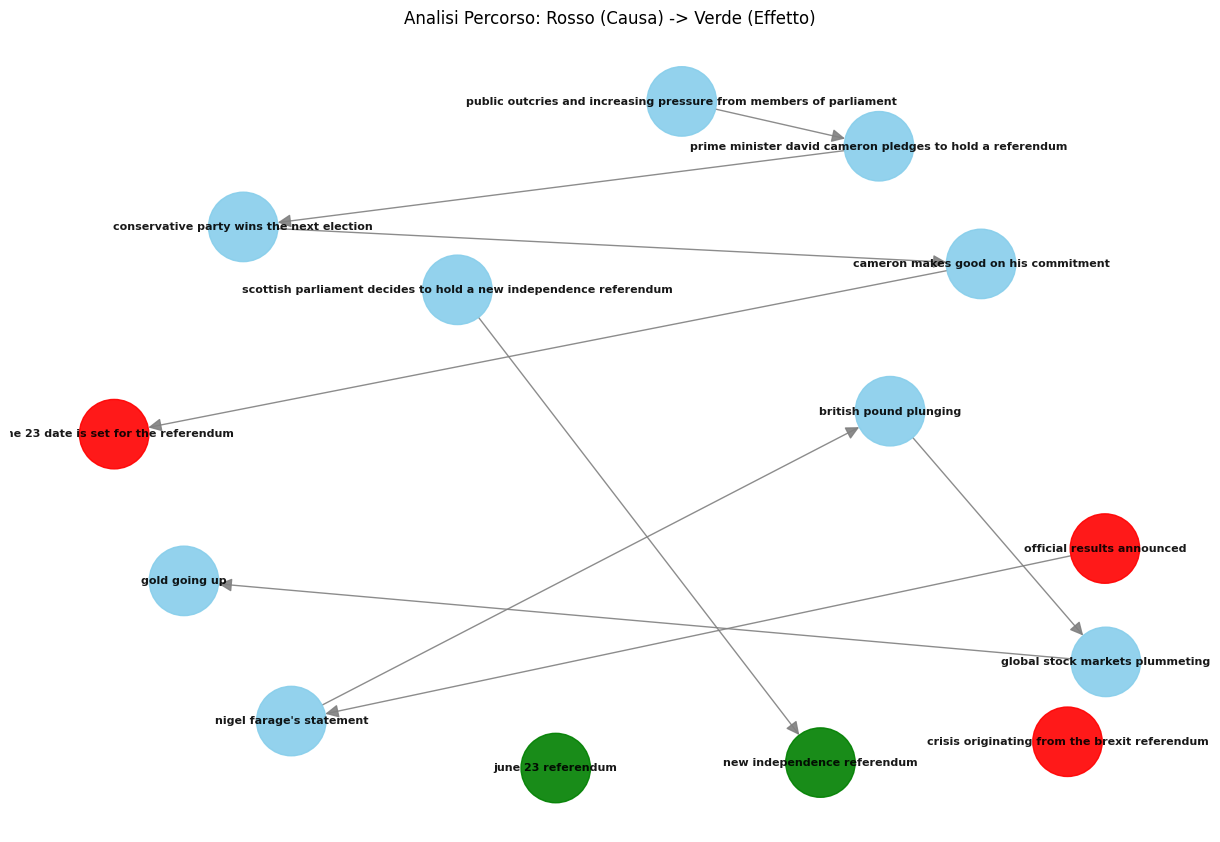


- june 23 date is set for the referendum
Predicted FALSE
Option The referendum date was set in February.
Nodi trovati da entrambi: ['june 23 date is set for the referendum', 'crisis originating from the brexit referendum']
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


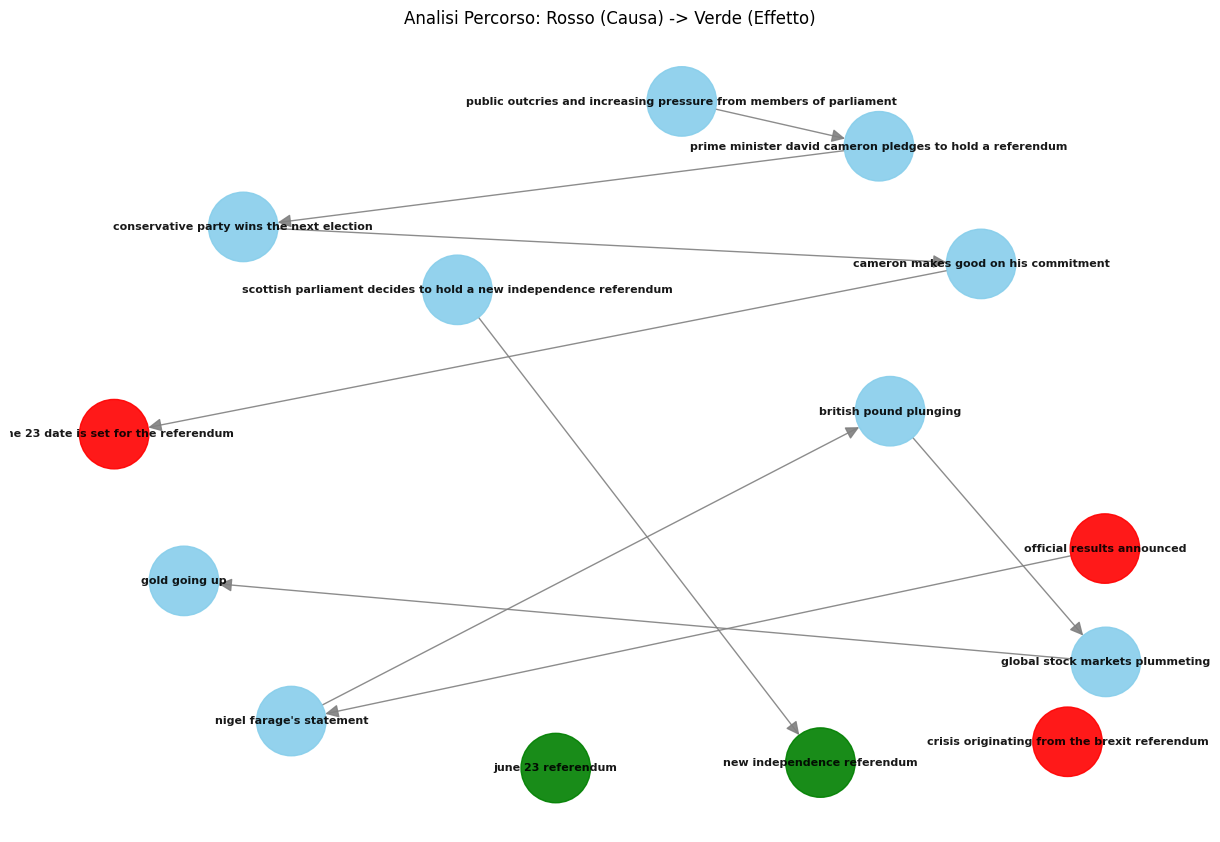


- june 23 date is set for the referendum
Predicted FALSE
Option Prime Minister David Cameron pledged a referendum on EU membership in 2013.
Nodi trovati da entrambi: ['prime minister david cameron pledges to hold a referendum', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 5, expanded effect nodes 5 


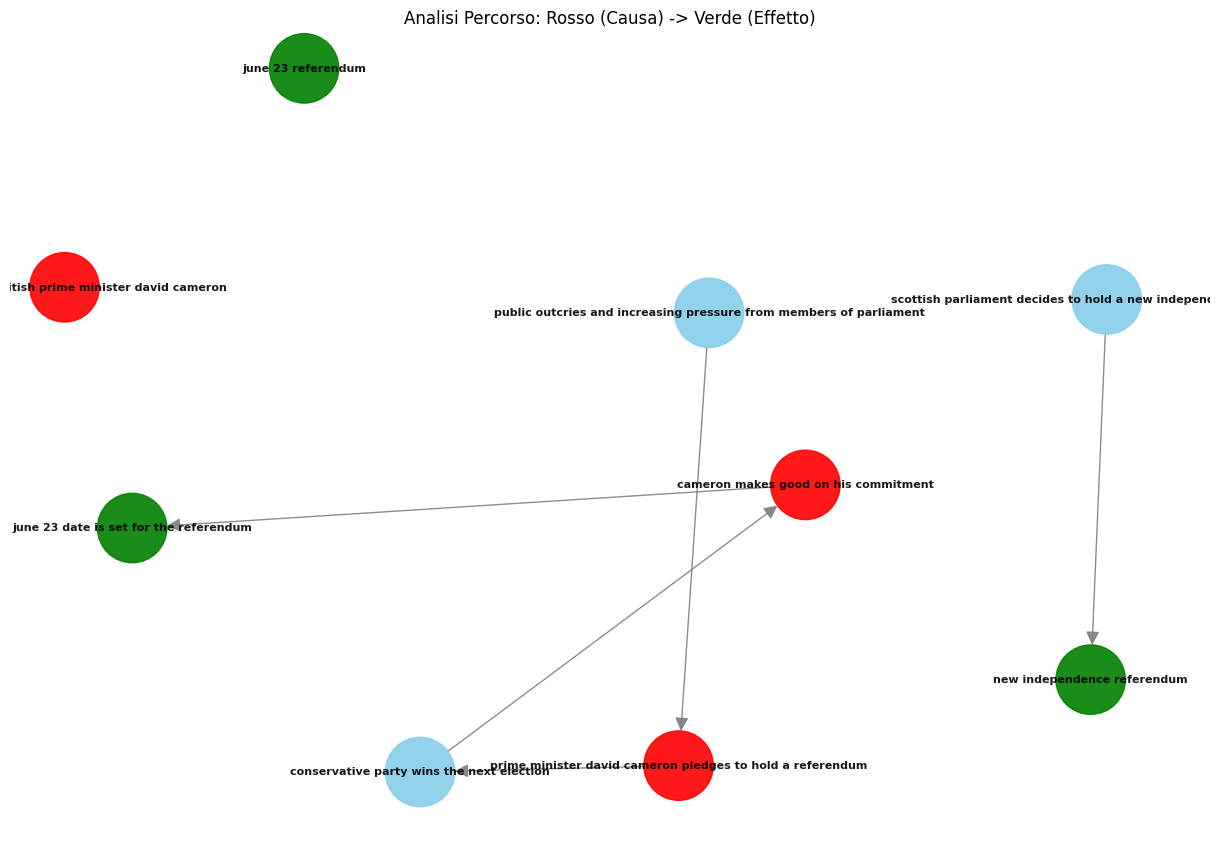

- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[causes]--> the specific date of june 23 is chosen for the eu membership referendum
- Prime Minister David Cameron commits to holding a referendum on the UK's membership in the EU --[causes]--> conservative party secures victory in the upcoming election
- Conservative Party secures victory in the upcoming election --[causes]--> prime minister cameron fulfills his promise to hold the referendum on the uk's eu membership
- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[causes]--> the specific date of june 23 is chosen for the eu membership referendum
Predicted TRUE
Option The nation divided into 'remain' and 'leave' camps.
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 9, expanded effect n

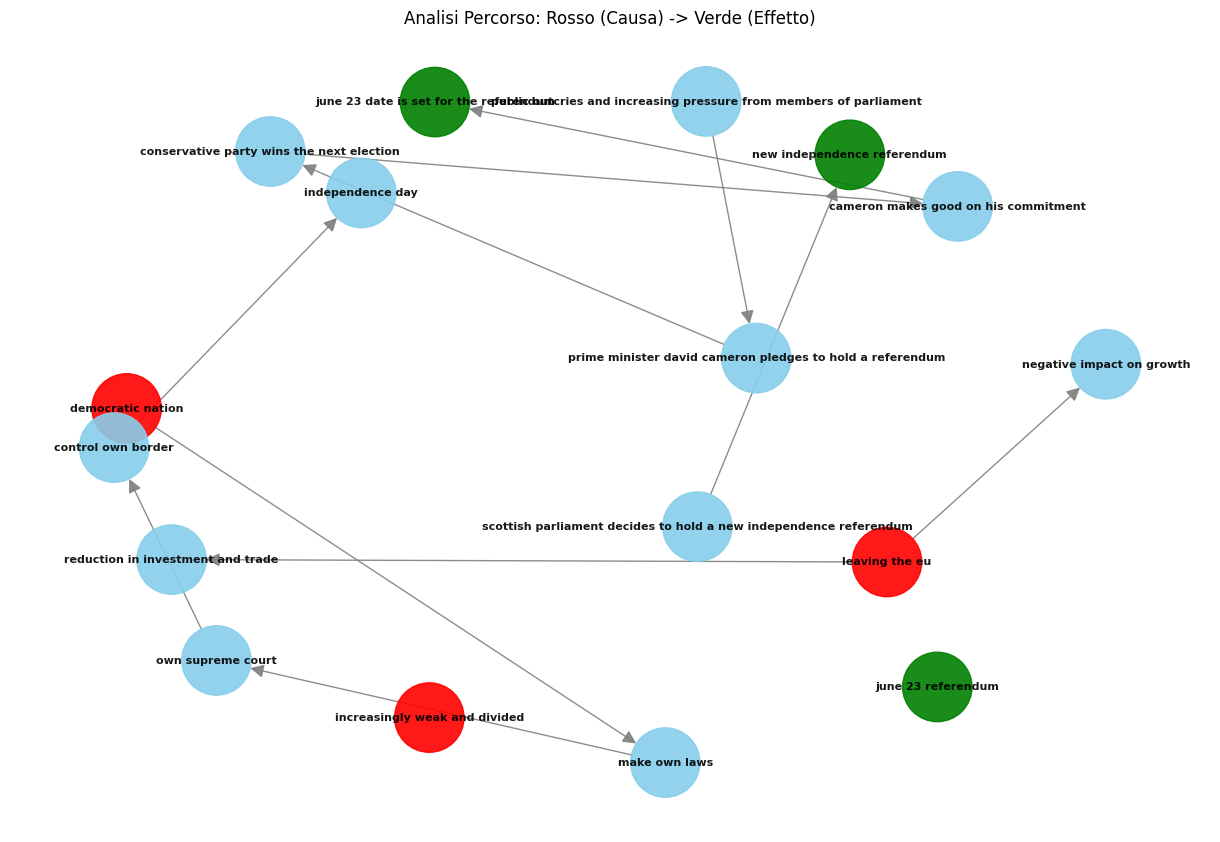


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The United Kingdom leaving the European Union --[CAUSES]--> uncertainty reducing investment and trade
- Wishing to manage immigration policies independently --[CAUSES]--> becoming the 184th independent country in the world
- Prime Minister David Cameron commits to holding a referendum on the UK's membership in the EU --[CAUSES]--> conservative party secures victory in the upcoming election
- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[CAUSES]--> the specific date of june 23 is chosen for the eu membership referendum
- Desire to be a self-governing country --[CAUSES]--> wanting to create laws independently in

  8%|▊         | 1/12 [00:07<01:17,  7.04s/it]Device set to use cuda:0


Event Global markets plunged following the Brexit vote.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option David Cameron announced his resignation as Prime Minister.
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['global stock markets plummeting']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 3, expanded effect nodes 3 


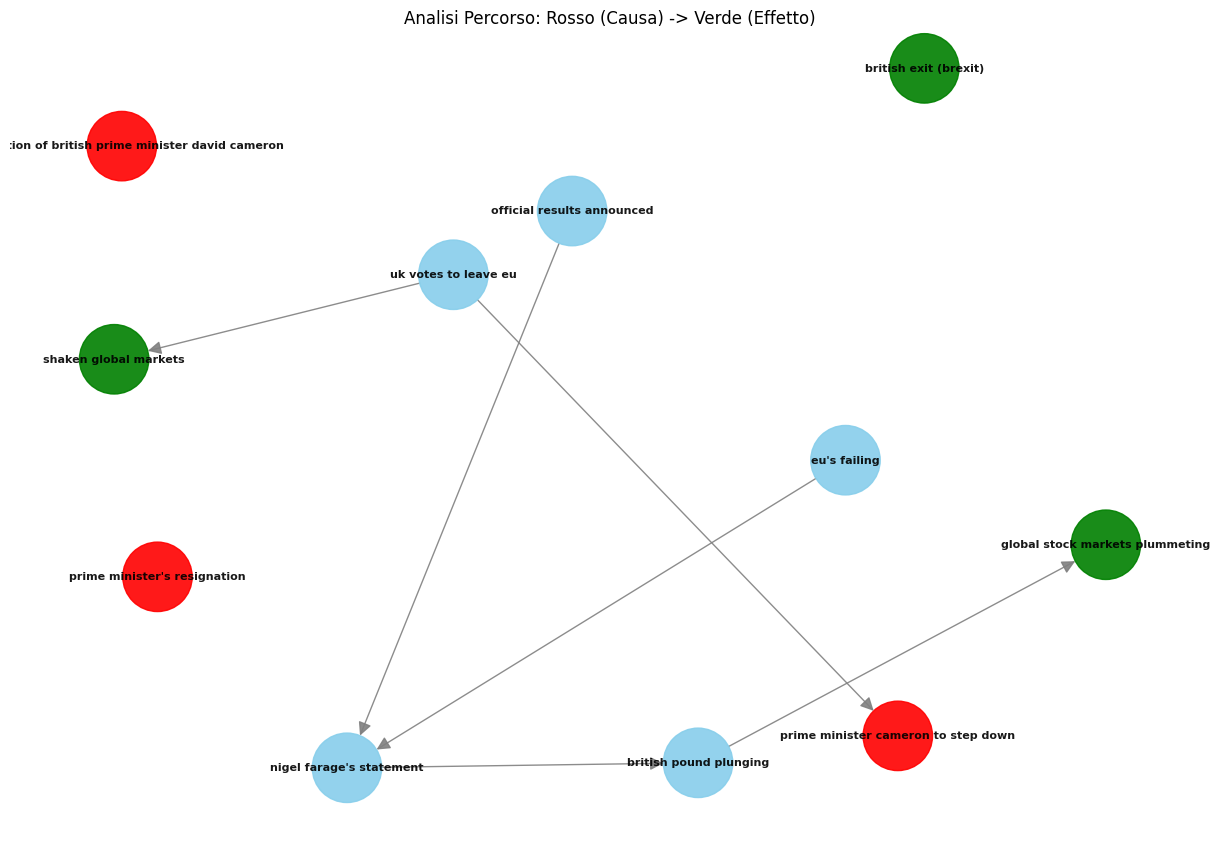


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farag

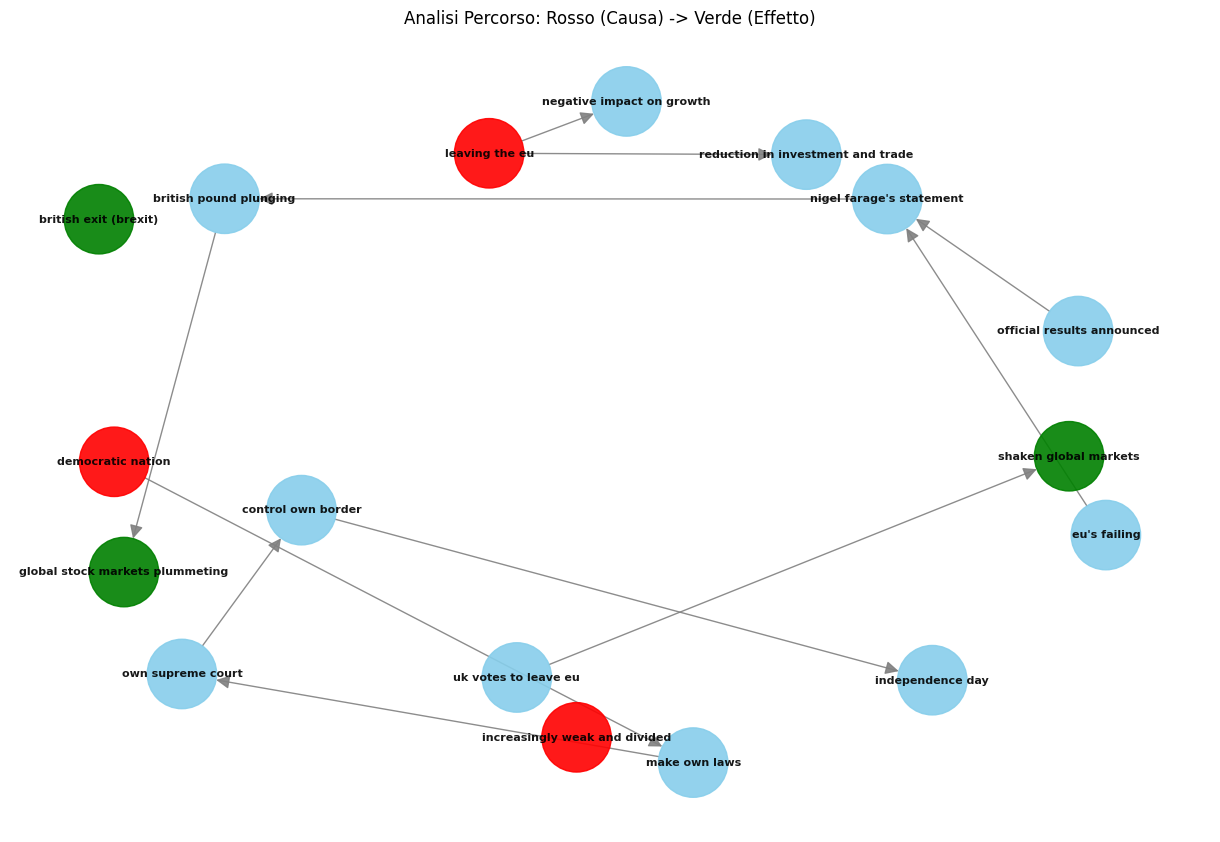


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- The United Kingdom leaving the European Union --[CAUSES]--> uncertainty reducing investment and trade
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Wishing to manage immigration policies independently --[CAUSES]--> becoming the 184th independent country in the world
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing an

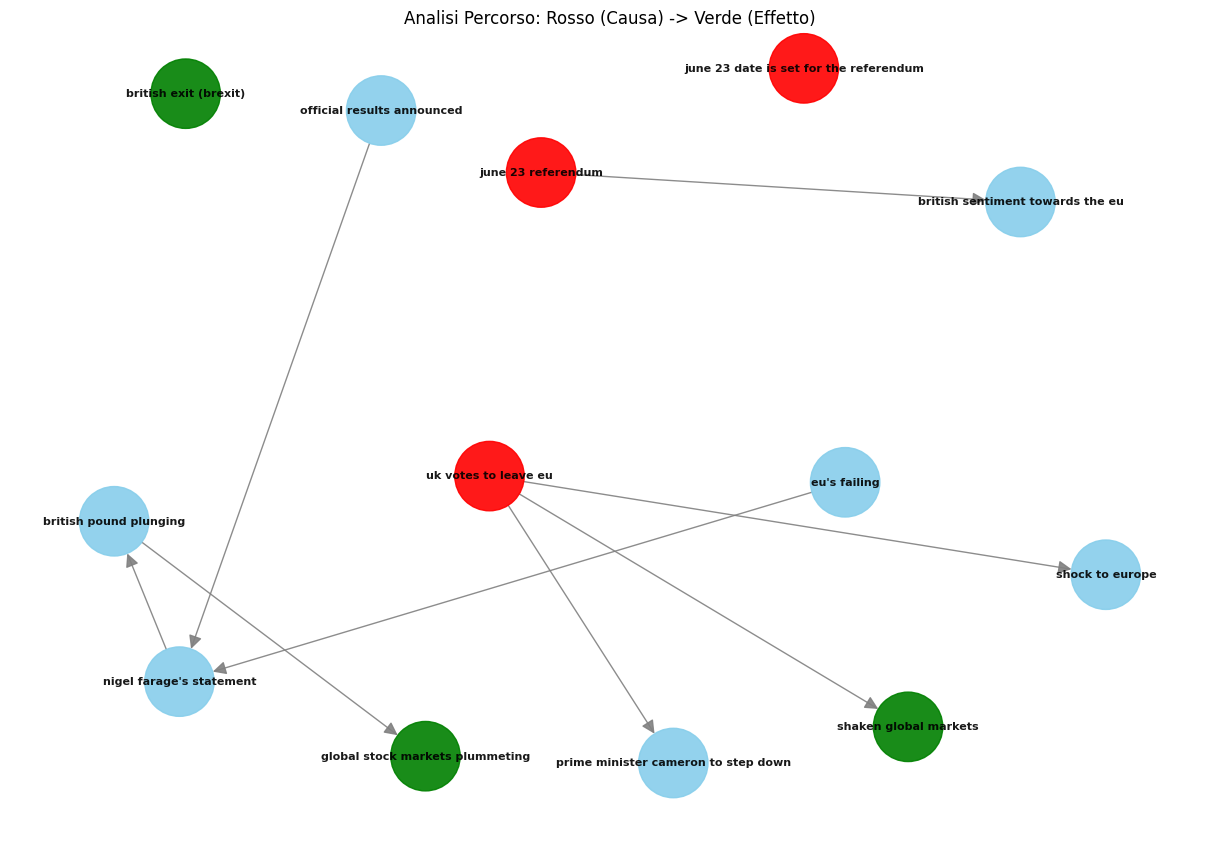

- Voters in the U.K. deciding to leave the European Union --[causes]--> disruption and volatility in global financial markets
Predicted TRUE
Option Northern Ireland and Scotland voted to remain in the EU.
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['global stock markets plummeting']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


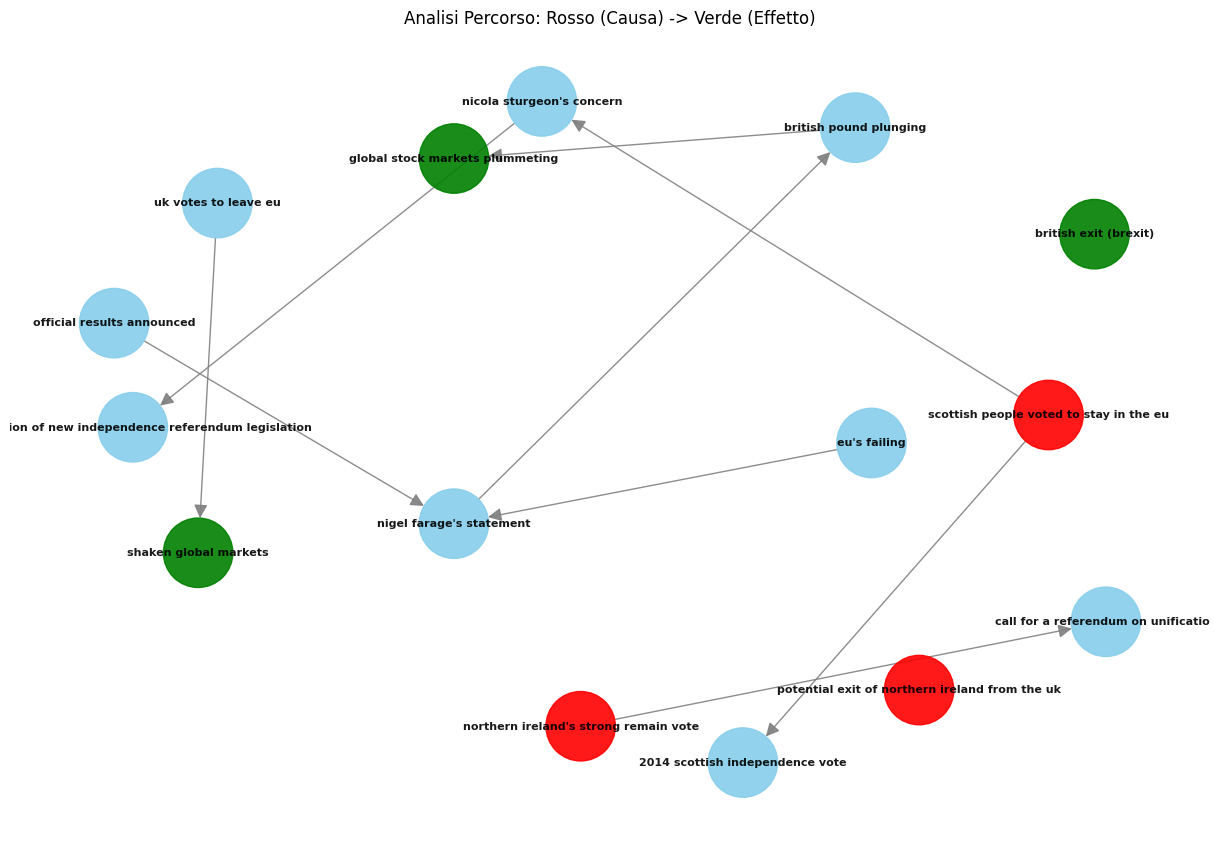


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Nicola Sturgeon expressing that the outcome is democratically unacceptable --[LEADS TO]--> scottish government beginning to prepare legislation for a new independence referendum
- Majority of Scottish people voting to stay in the EU in a

 17%|█▋        | 2/12 [00:13<01:08,  6.80s/it]Device set to use cuda:0


Event Sinn Fein called for a referendum on Irish unity.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The nation divided into 'remain' and 'leave' camps.
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['sinn fein calls for irish unity', 'call for a referendum on unification', 'referendum on irish unity', 'irish unity referendum call', 'sinn féin party call for referendum']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 9, expanded effect nodes 9 


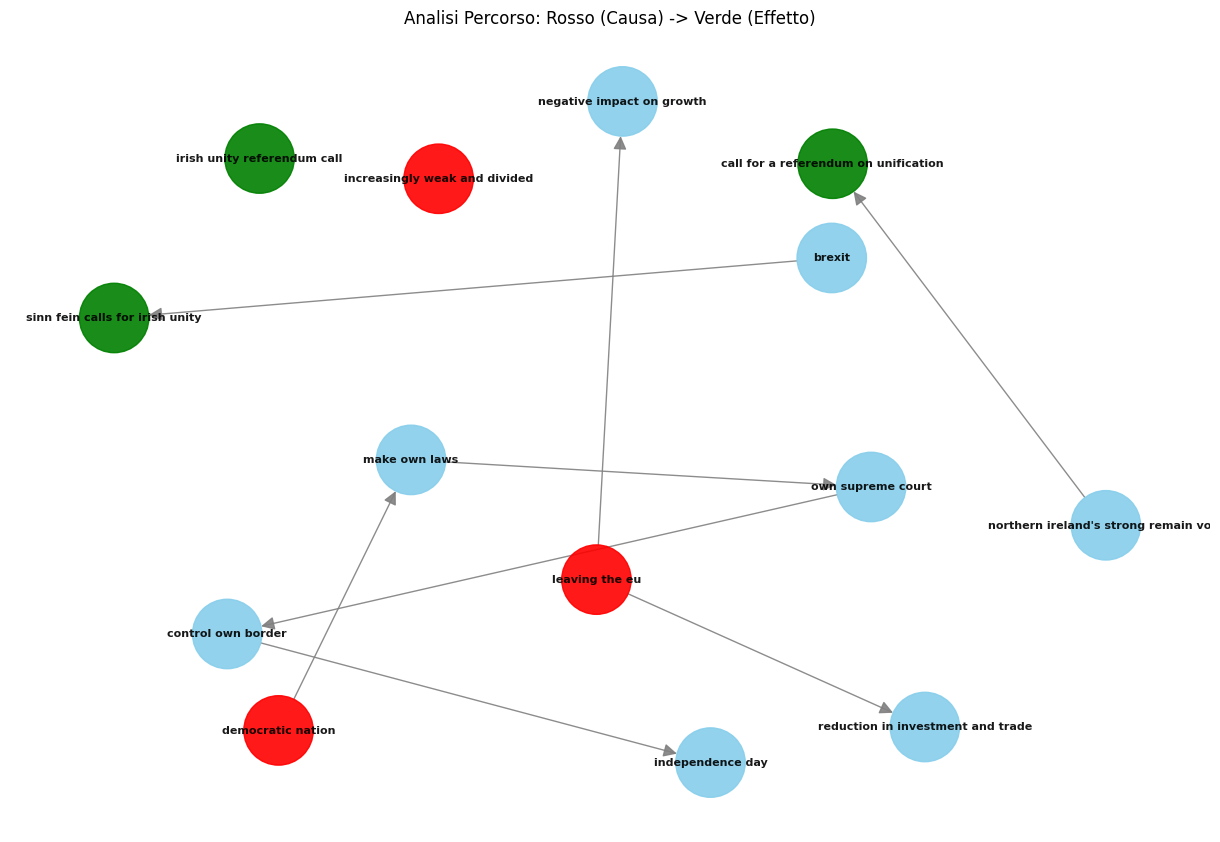


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['sinn fein calls for irish unity', 'call for a referendum on unification', 'referendum on irish unity', 'irish unity referendum call', 'sinn féin party call for referendum']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- The United Kingdom leaving the European Union --[CAUSES]--> uncertainty reducing investment and trade
- Wishing to manage immigration policies independently --[CAUSES]--> becoming the 184th independent country in the world
- The United Kingdom leaving the European Union --[CAUSES]--> negative impact on growth in the uk and the rest of the eu and, in fact, the world
- Desire to be a self-governing country --[CAUSES]--> wanting to create laws in

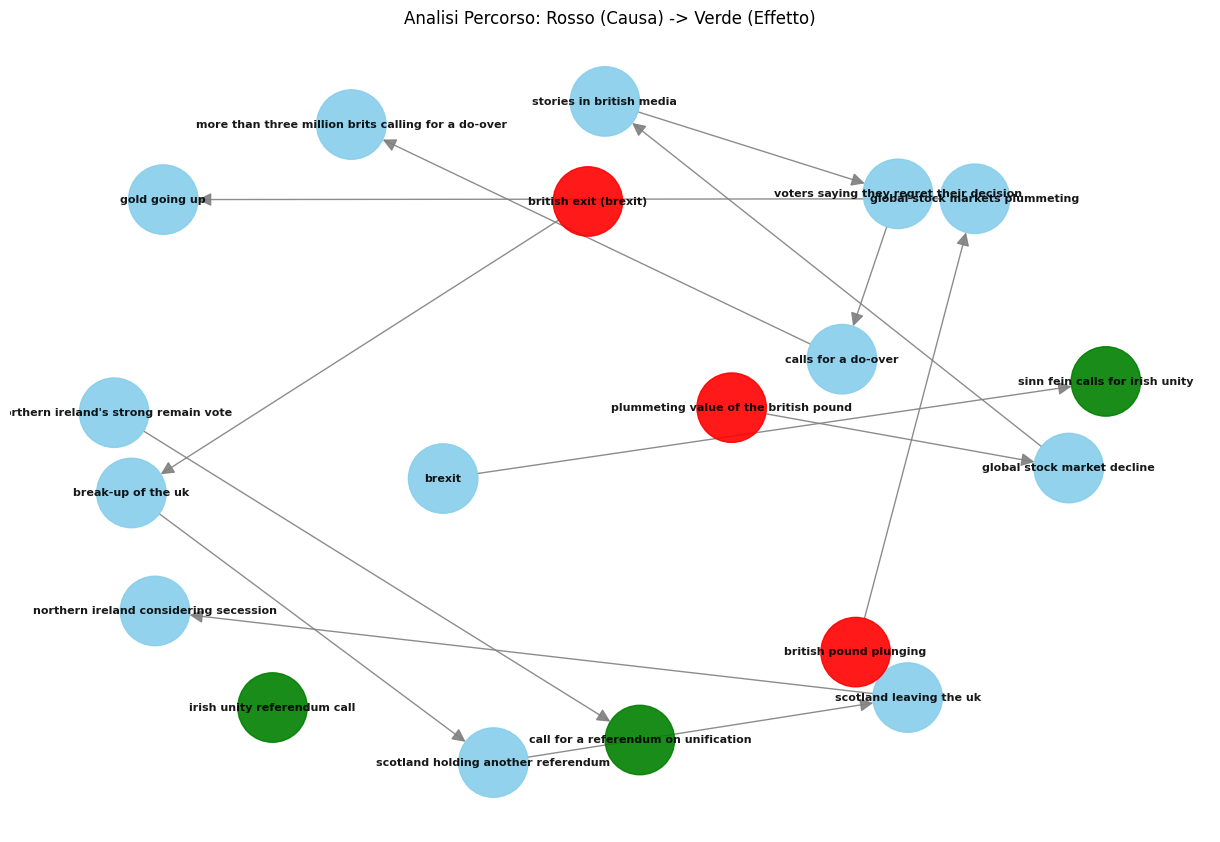


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Nodi trovati da entrambi: ['sinn fein calls for irish unity', 'call for a referendum on unification', 'referendum on irish unity', 'irish unity referendum call', 'sinn féin party call for referendum']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Scotland becoming independent from the UK --[CAUSES]--> northern ireland potentially seeking independence
- A British exit from

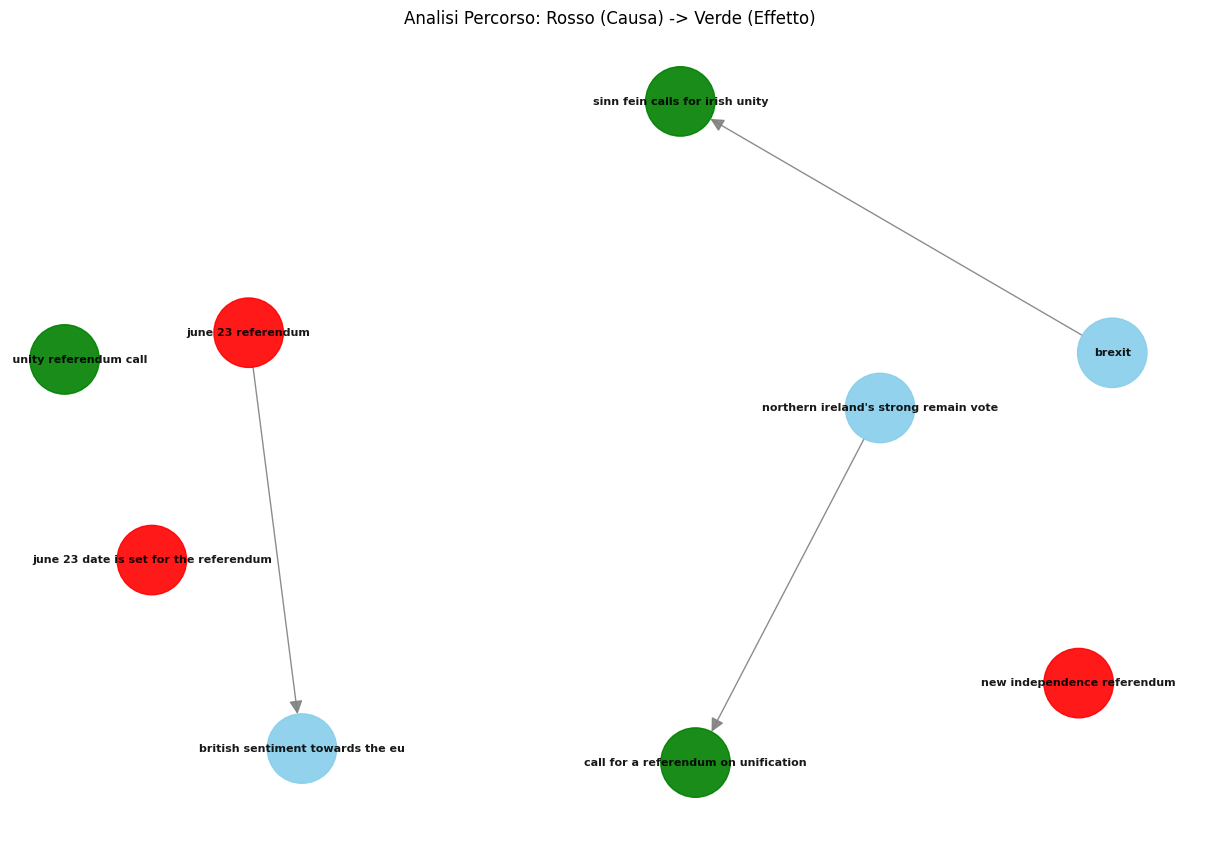


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['sinn fein calls for irish unity', 'call for a referendum on unification', 'referendum on irish unity', 'irish unity referendum call', 'sinn féin party call for referendum']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- UK leaving the EU --[CAUSES]--> sinn féin calling for a referendum on irish unity
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts

Additional context on Candidate Cause:
- Cause detail: june 23 date is set for the

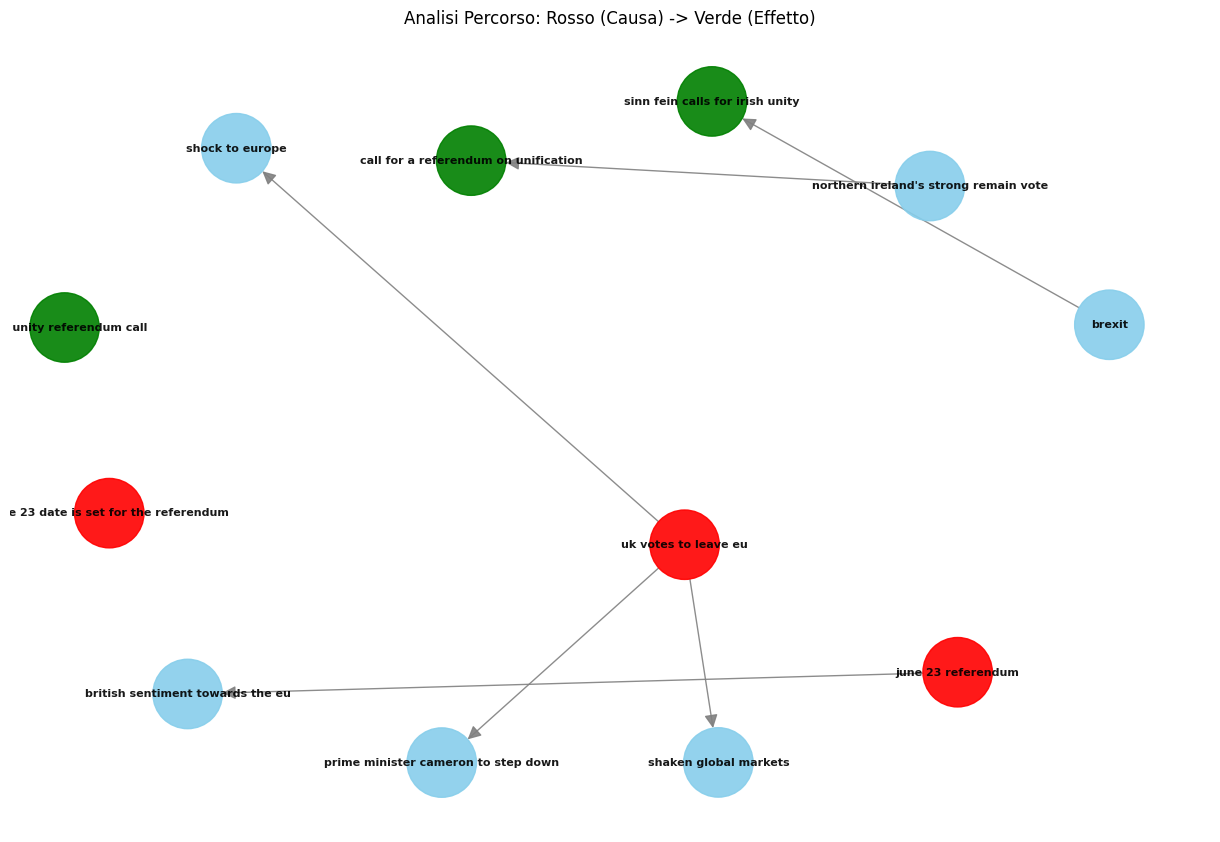


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['sinn fein calls for irish unity', 'call for a referendum on unification', 'referendum on irish unity', 'irish unity referendum call', 'sinn féin party call for referendum']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their

 25%|██▌       | 3/12 [00:20<01:02,  6.89s/it]Device set to use cuda:0


Event The British pound plunged in value.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The United Kingdom held a referendum on June 23.
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 4, expanded effect nodes 4 


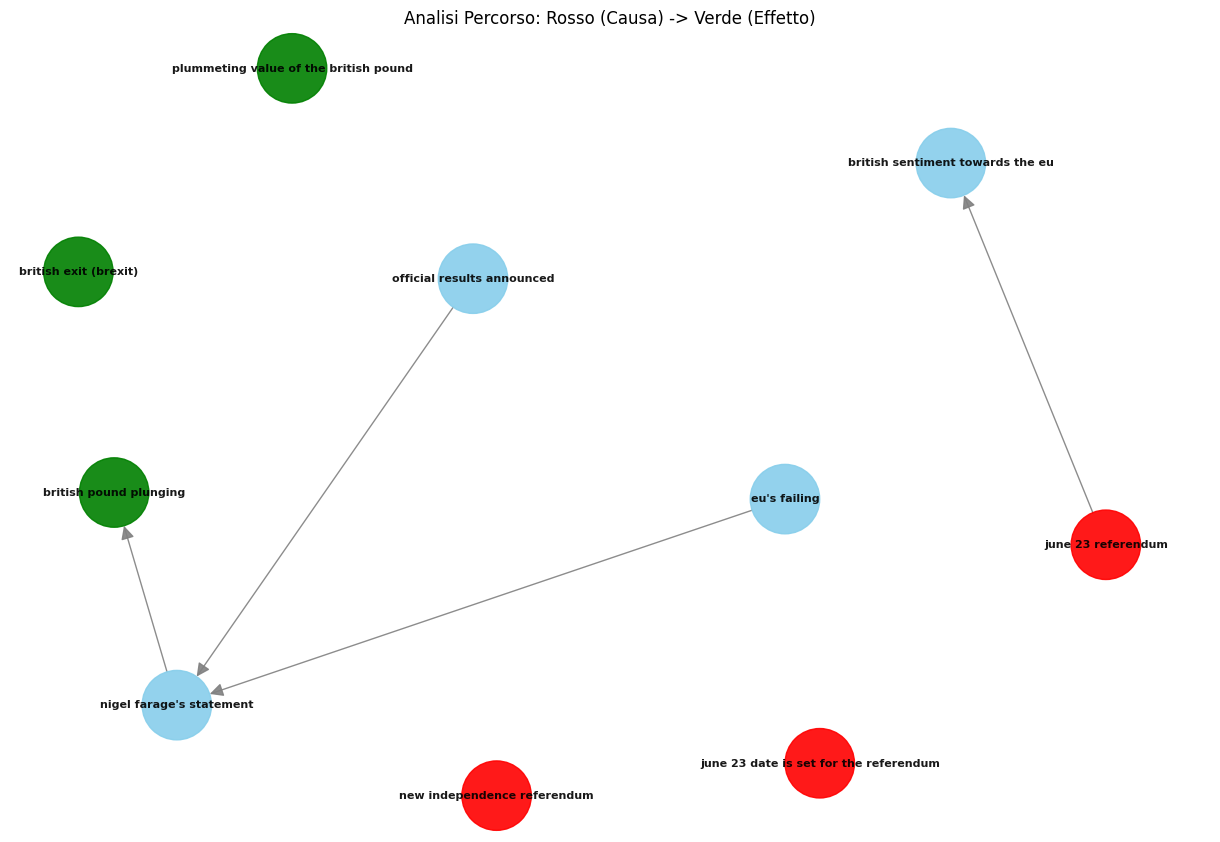


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Nigel Farage declaring the EU's failing and predicting other countries to leave --[LEADS TO]--> value of the british pound dropping significantly
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring

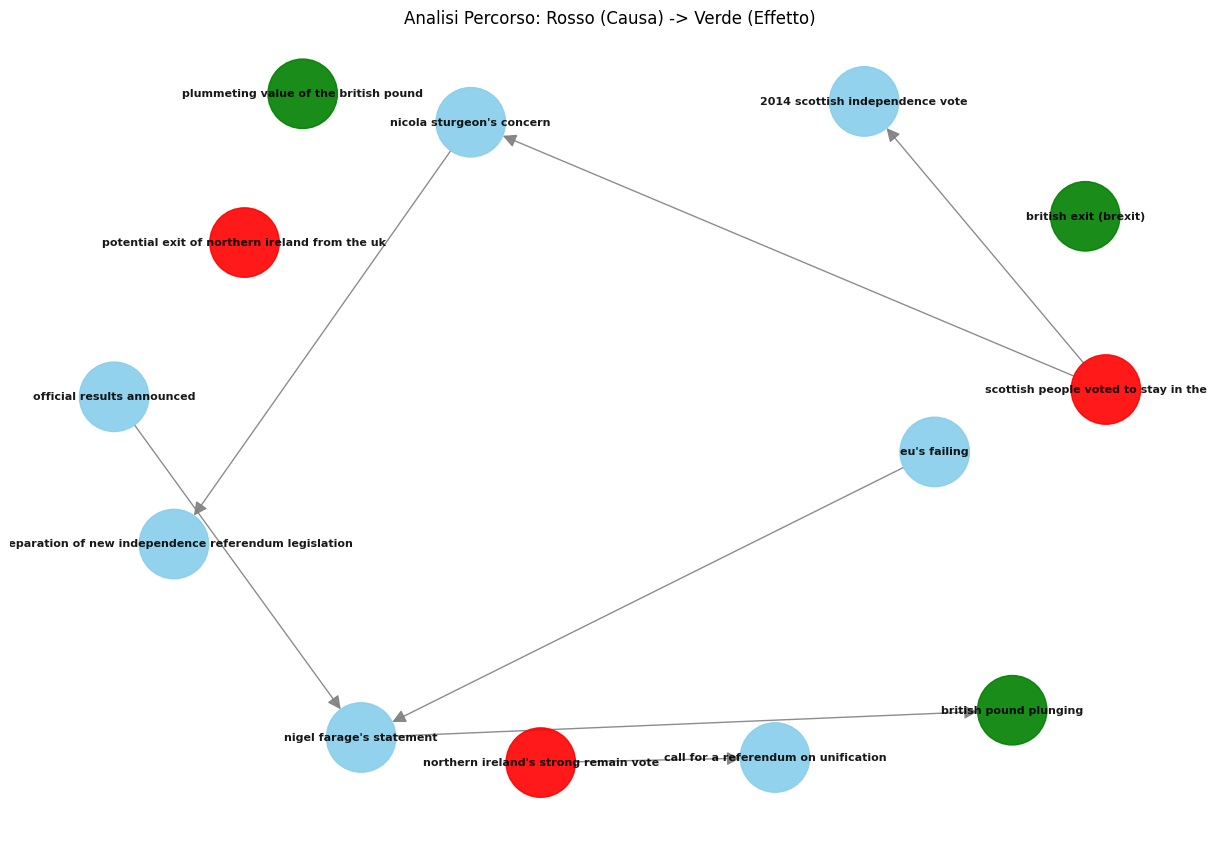


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Nicola Sturgeon expressing that the outcome is democratically unacceptable --[LEADS TO]--> scottish government beginning to prepare legislation for a new independence referendum
- Majority of Scottish people voting to stay in the EU in a referendum --[RESULTED IN]--> the 2014 scottish independen

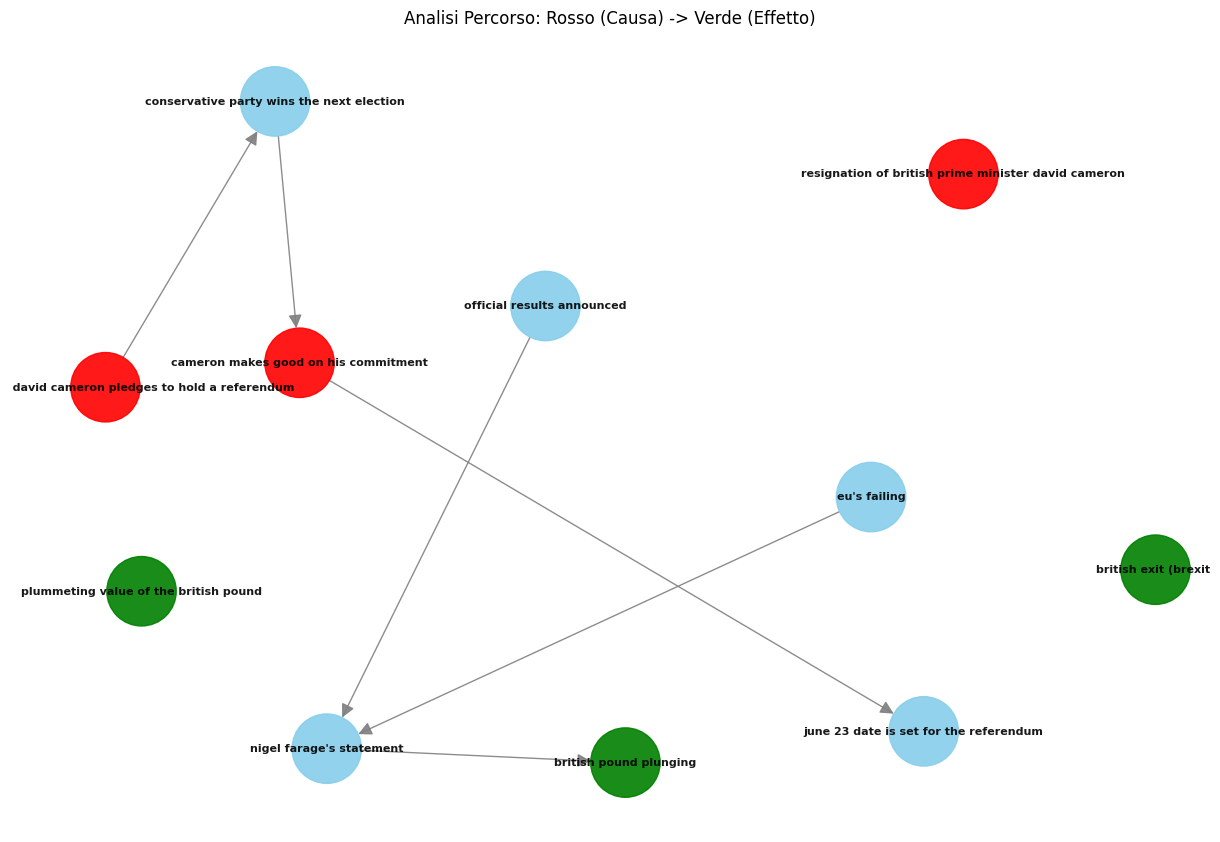


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['prime minister david cameron pledges to hold a referendum', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Prime Minister David Cameron commits to holding a referendum on the UK's membership in the EU --[CAUSES]--> conservative party secures victory in the upcoming election
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[CAUSE

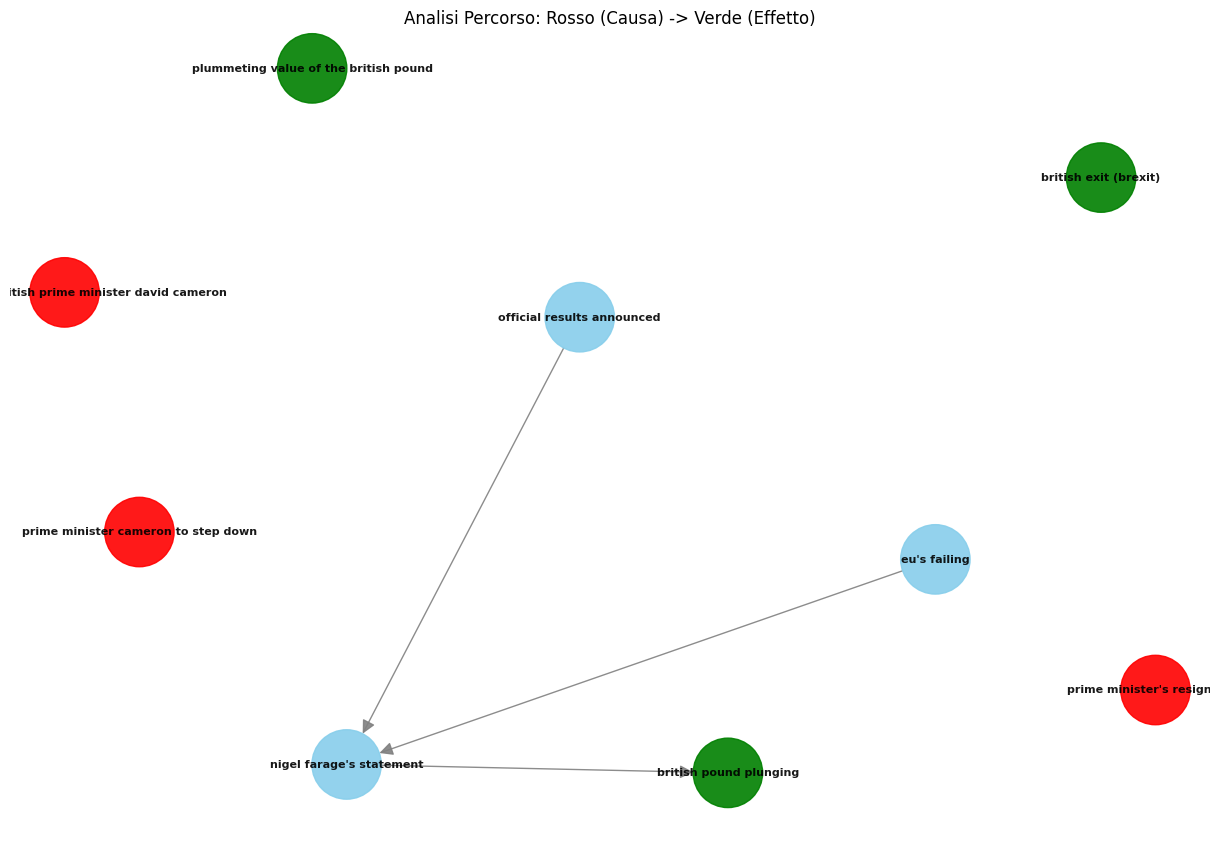


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Nigel Farage declaring the EU's failing and predicting other countries to leave --[LEADS TO]--> value of the british pound dropping significantly
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing and pred

 33%|███▎      | 4/12 [00:27<00:56,  7.02s/it]Device set to use cuda:0


Event The British pound plunged in value.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The UK voted to leave the EU in a June 23 referendum.
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


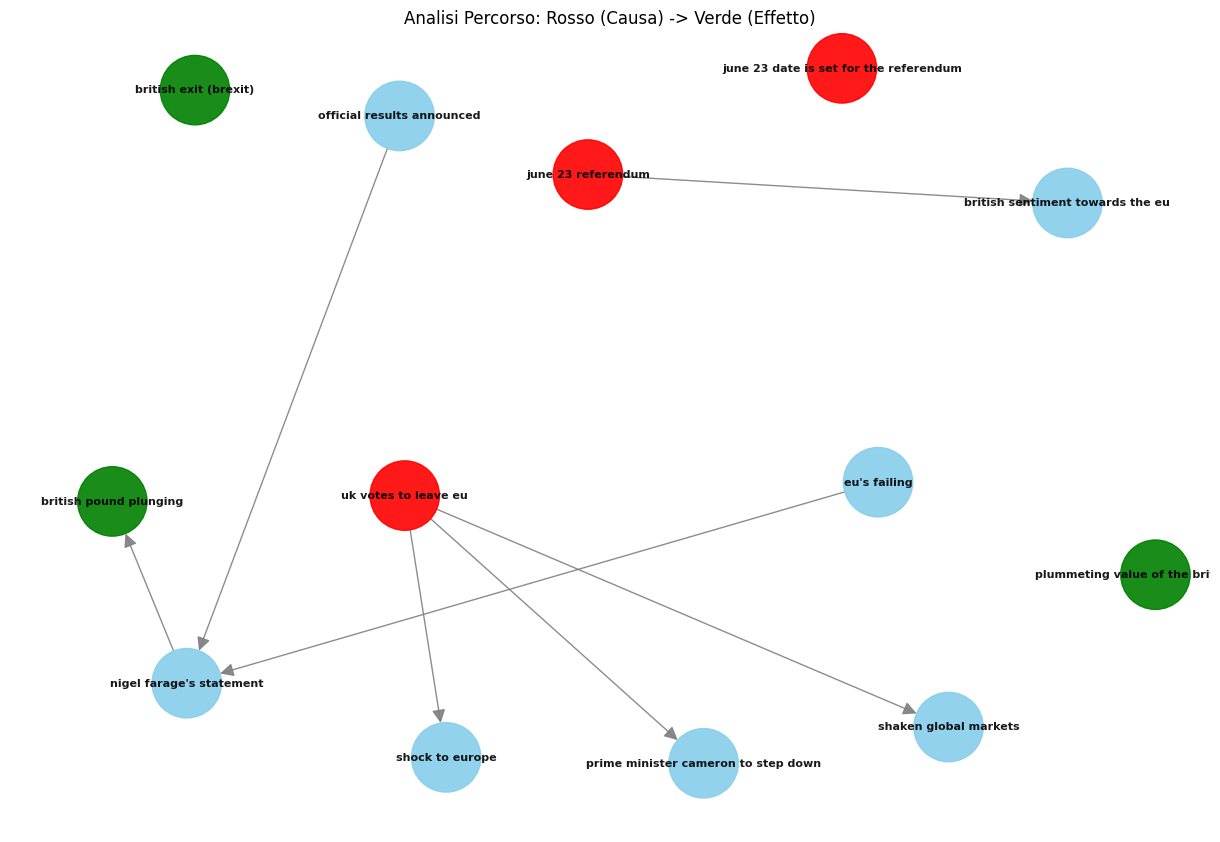


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- The perceived failure and weakening of the European

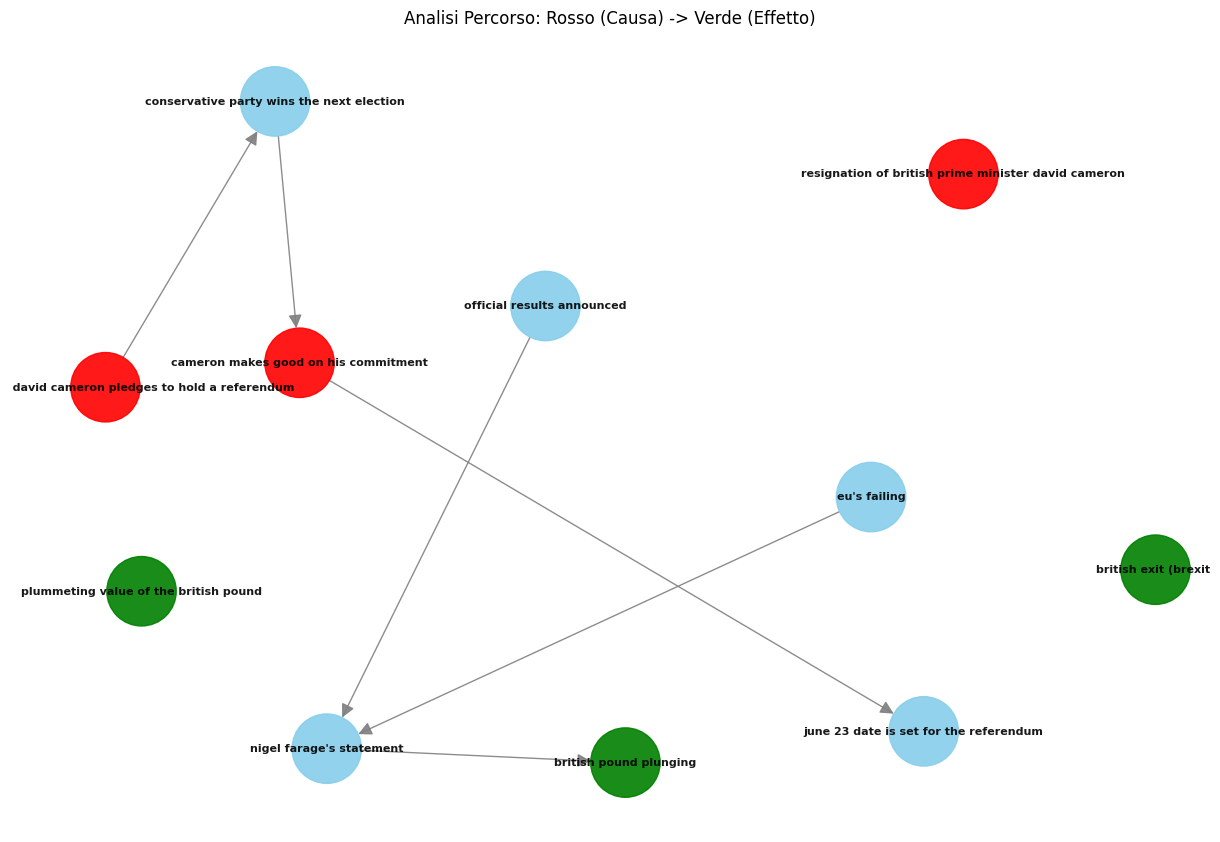


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['prime minister david cameron pledges to hold a referendum', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Prime Minister David Cameron commits to holding a referendum on the UK's membership in the EU --[CAUSES]--> conservative party secures victory in the upcoming election
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[CAUSE

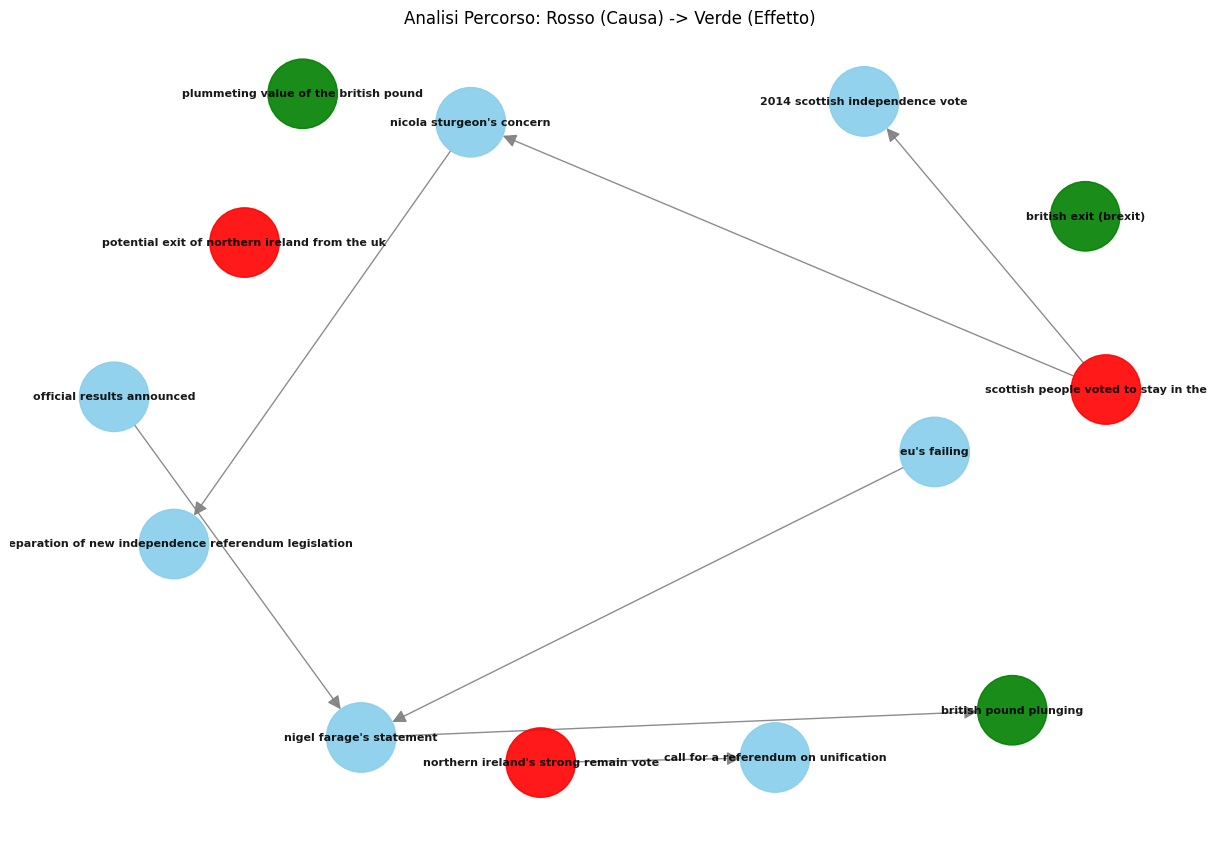


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Nicola Sturgeon expressing that the outcome is democratically unacceptable --[LEADS TO]--> scottish government beginning to prepare legislation for a new independence referendum
- Majority of Scottish people voting to stay in the EU in a referendum --[RESULTED IN]--> the 2014 scottish independen

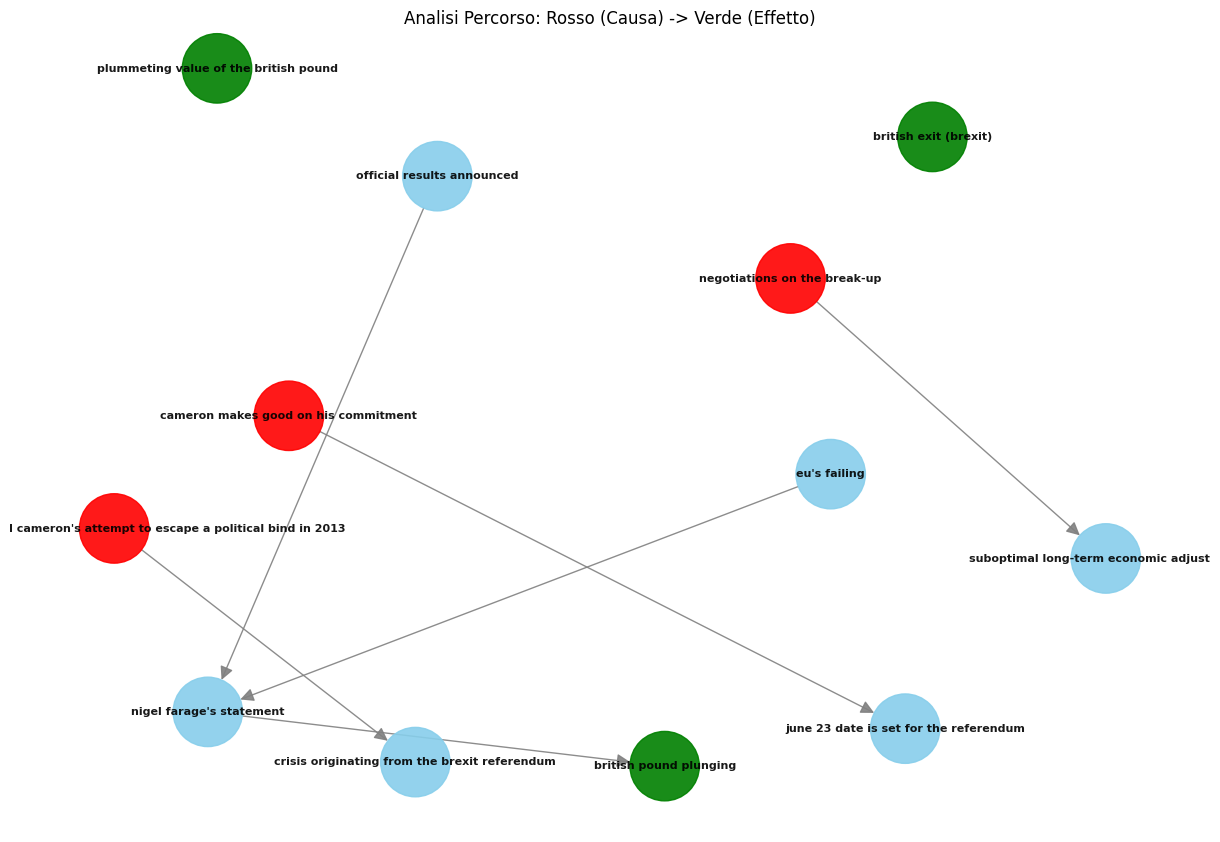


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['cameron makes good on his commitment']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[CAUSES]--> the specific date of june 23 is chosen for the eu membership referendum
- Negotiations on the break-up of the UK from the EU --[CAUSES]--> long-term economic adjustment but the result would be suboptimal
- Nigel Farage declar

 42%|████▏     | 5/12 [00:34<00:49,  7.04s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option Northern Ireland and Scotland voted to remain in the EU.
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


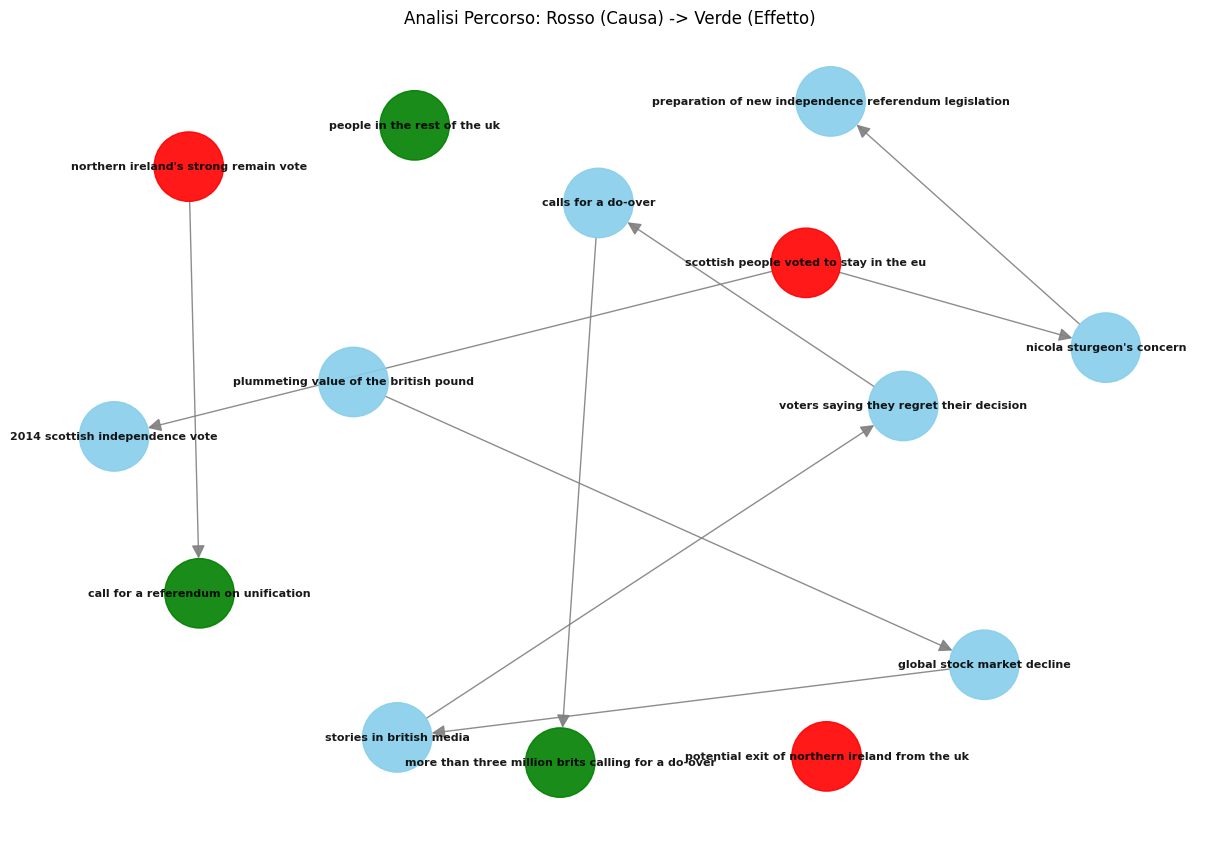

- Northern Ireland's strong Remain vote --[lead to]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
Predicted FALSE
Option David Cameron announced his resignation as Prime Minister.
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 3, expanded effect nodes 3 


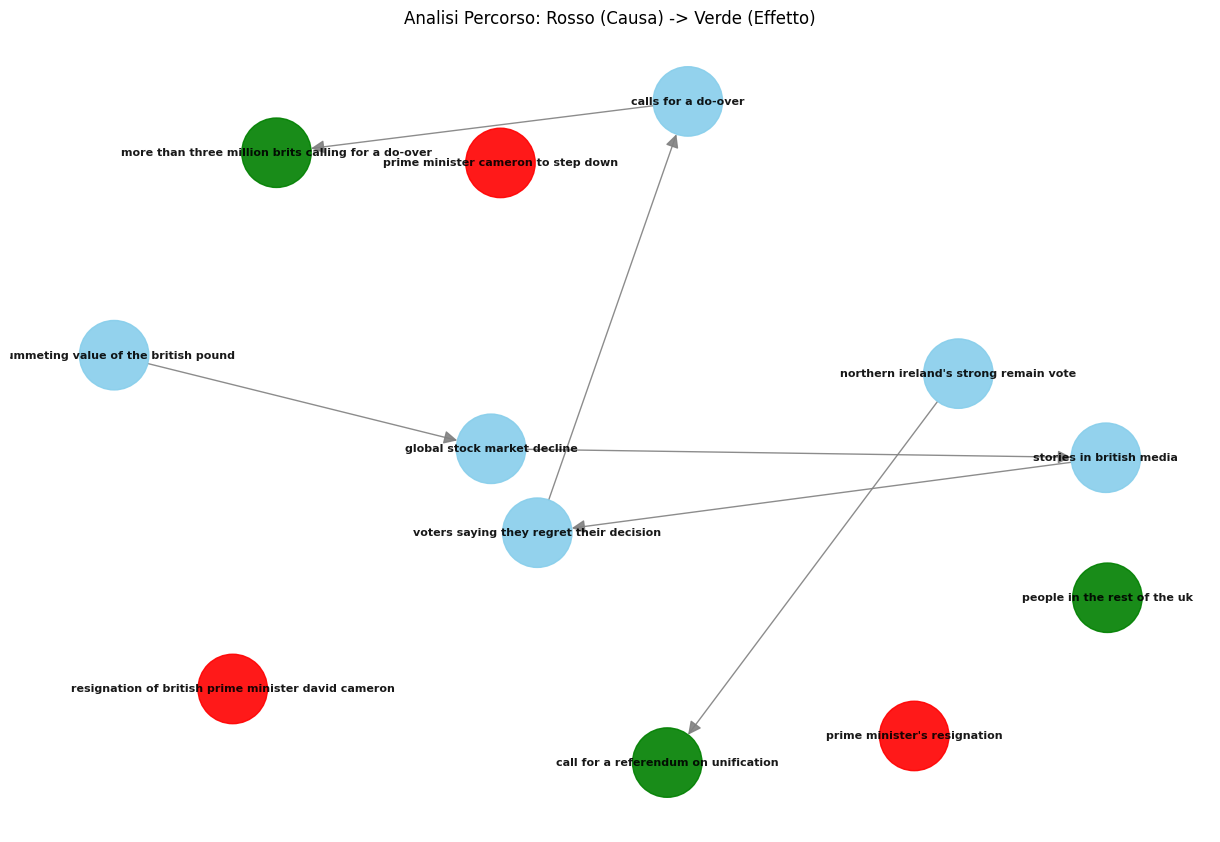


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Decrease in global stock values --[CAUSES]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[CAUSES]--> statements from voters expressing regret over their brex

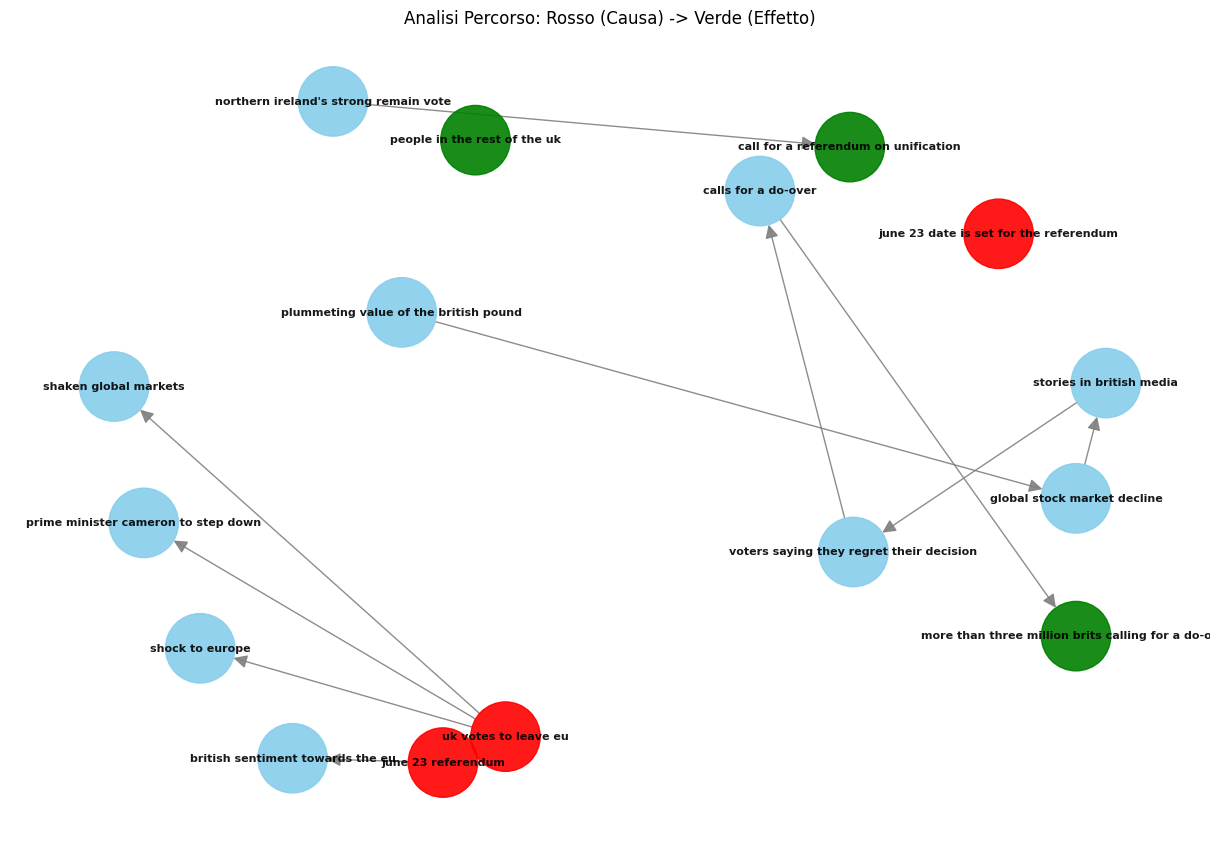


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their cont

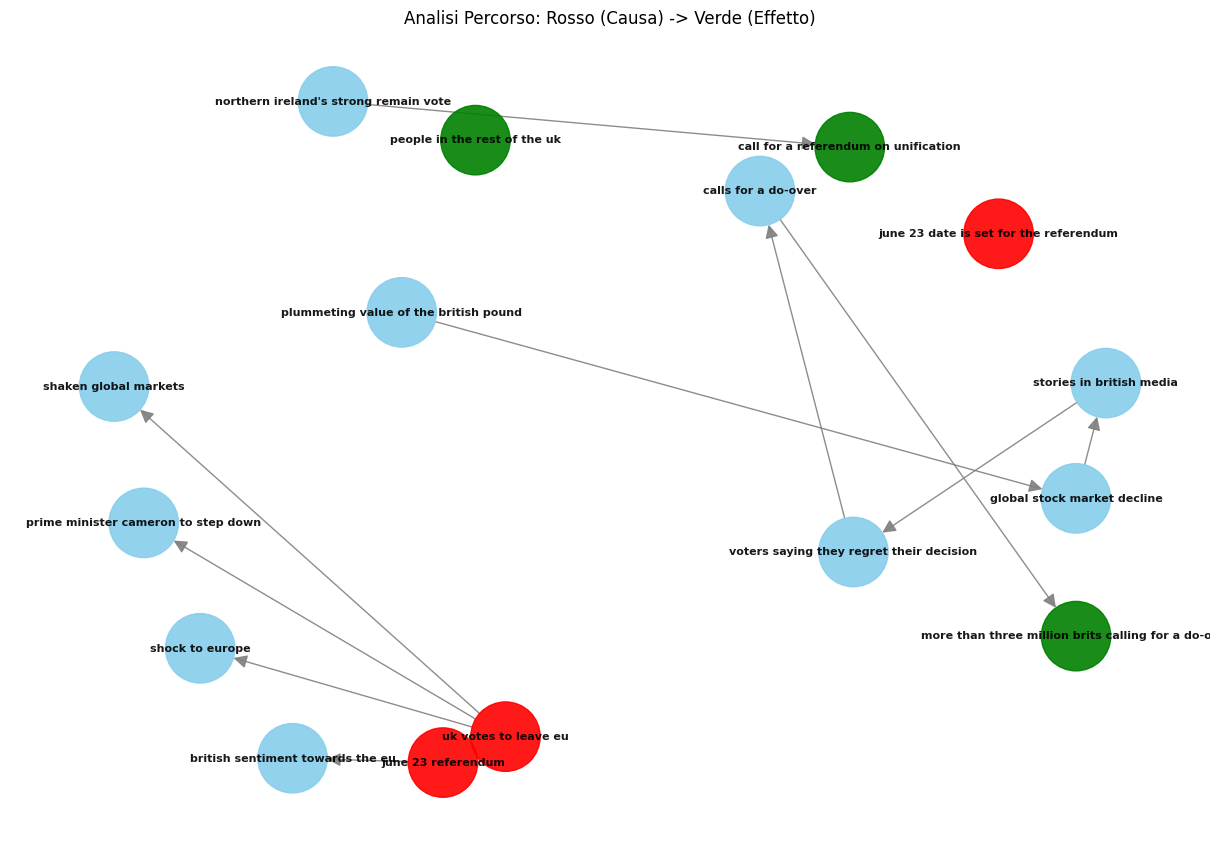


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their cont

 50%|█████     | 6/12 [00:42<00:42,  7.12s/it]Device set to use cuda:0


Event Global markets plunged following the Brexit vote.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option Northern Ireland and Scotland voted to remain in the EU.
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['global stock markets plummeting']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


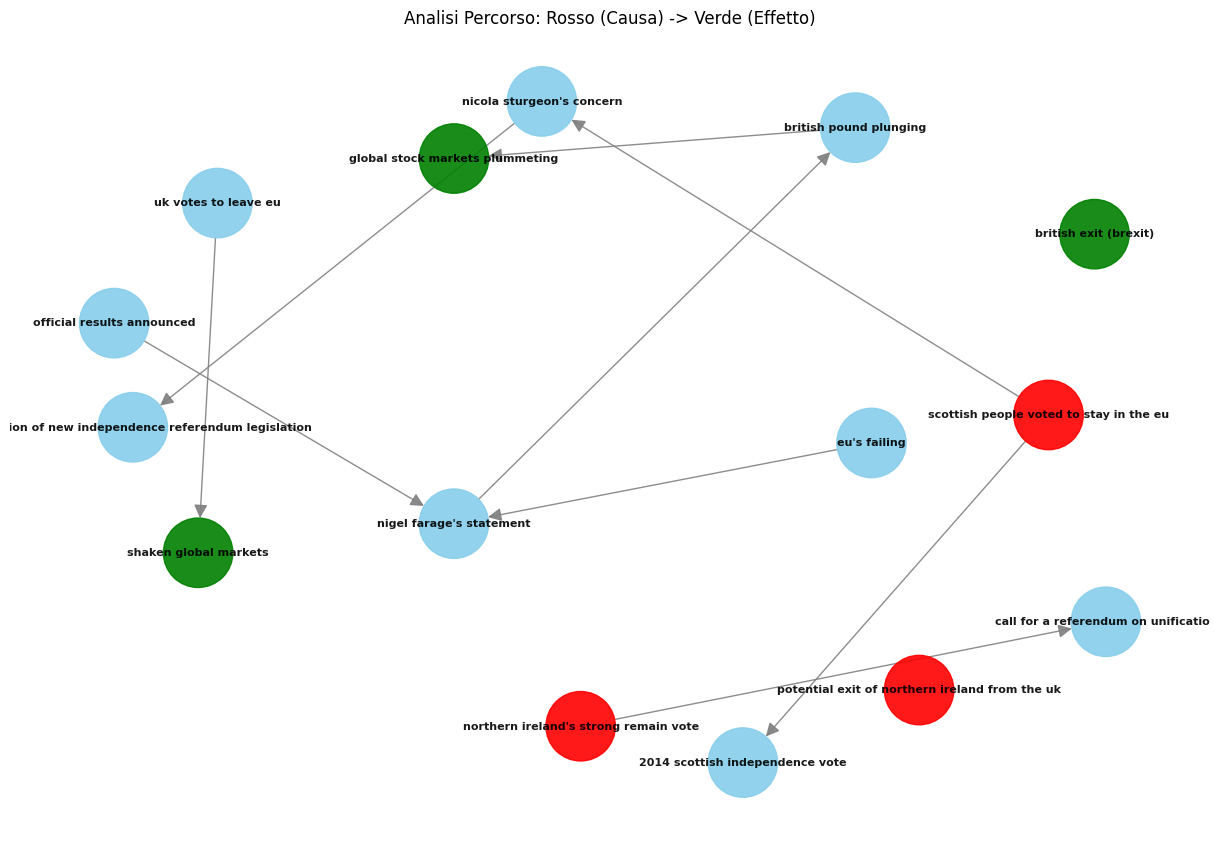


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Nicola Sturgeon expressing that the outcome is democratically unacceptable --[LEADS TO]--> scottish government beginning to prepare legislation for a new independence referendum
- Majority of Scottish people voting to stay in the EU in a

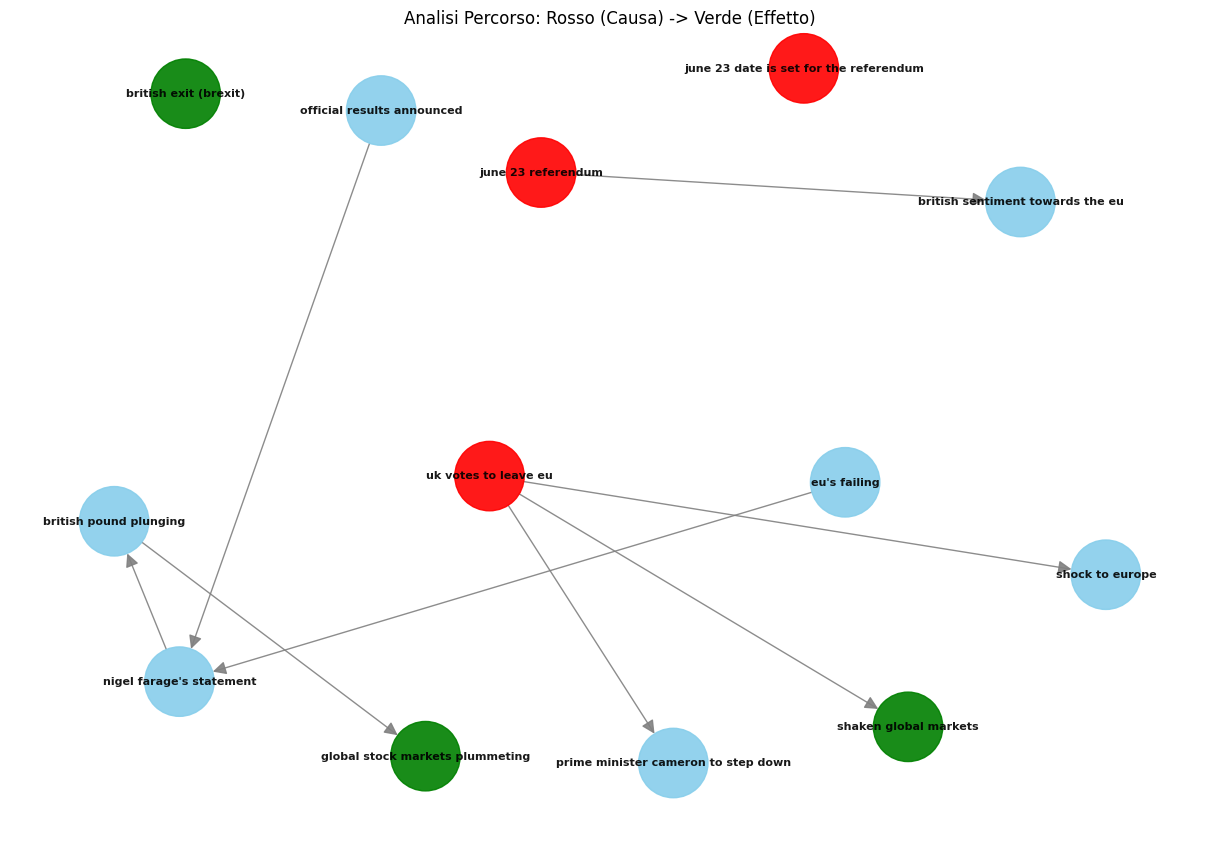

- Voters in the U.K. deciding to leave the European Union --[causes]--> disruption and volatility in global financial markets
Predicted TRUE
Option The nation divided into 'remain' and 'leave' camps.
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['global stock markets plummeting']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 9, expanded effect nodes 9 


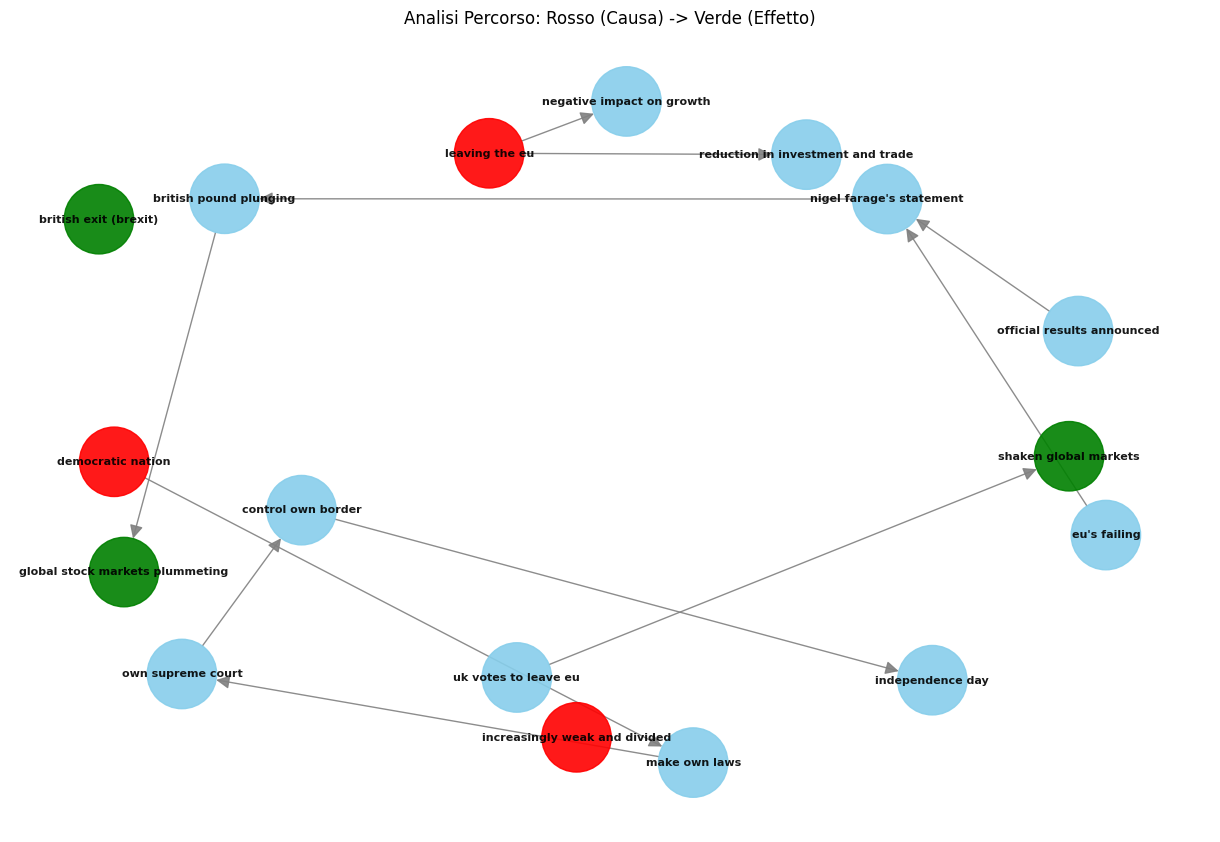


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- The United Kingdom leaving the European Union --[CAUSES]--> uncertainty reducing investment and trade
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Wishing to manage immigration policies independently --[CAUSES]--> becoming the 184th independent country in the world
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing an

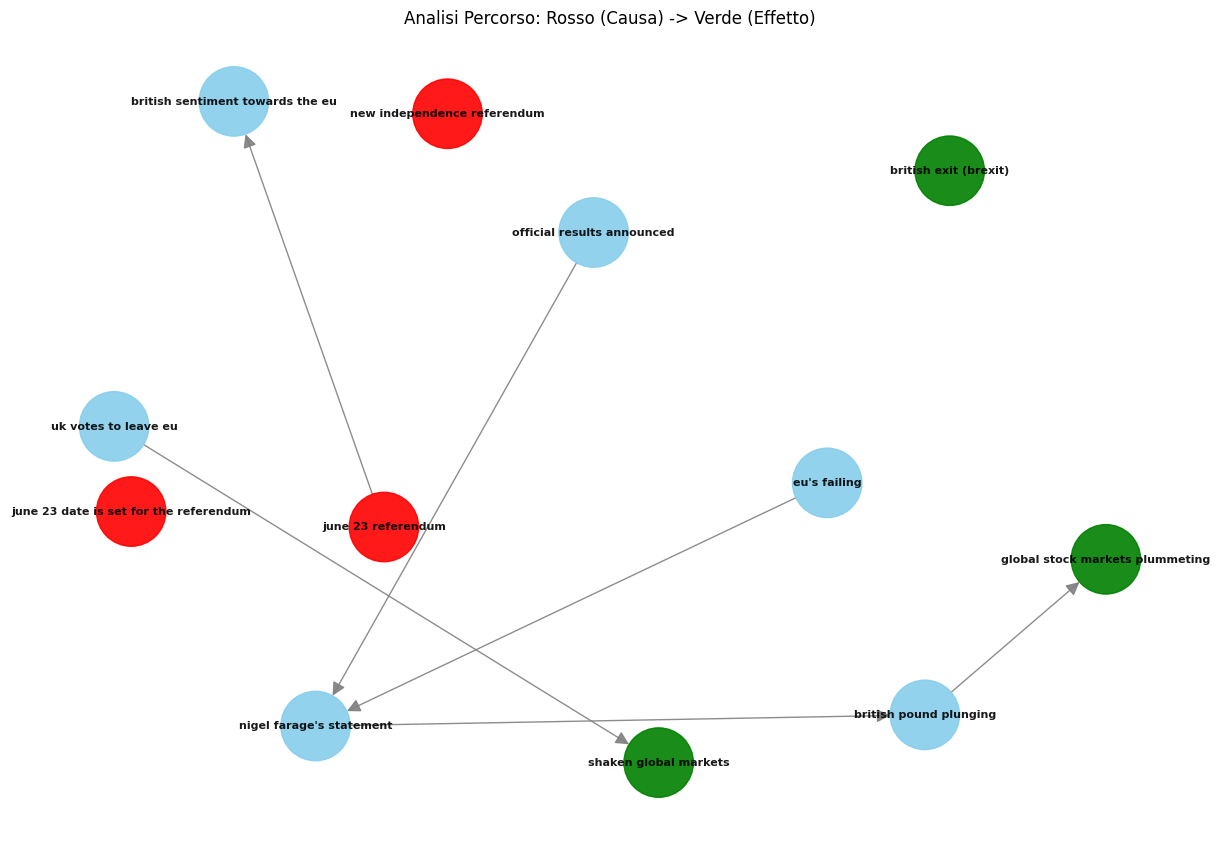


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- The perceived failure and weakening of the European Union -

 58%|█████▊    | 7/12 [00:49<00:35,  7.05s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option Sinn Fein called for a referendum on Irish unity.
Nodi trovati da entrambi: ['sinn fein calls for irish unity', 'call for a referendum on unification', 'referendum on irish unity', 'irish unity referendum call', 'sinn féin party call for referendum']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 4, expanded effect nodes 4 


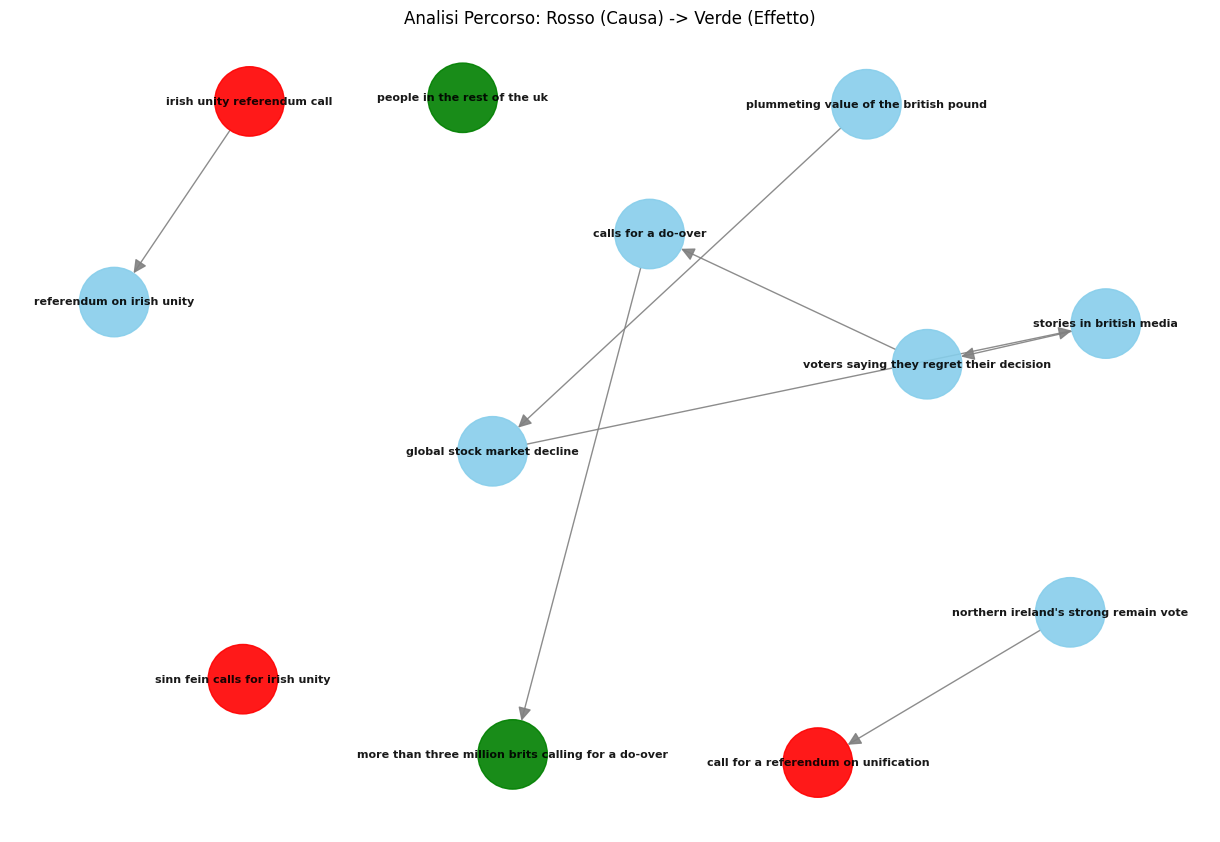


- call for a referendum on unification
Predicted FALSE
Option Global markets plunged following the Brexit vote.
Nodi trovati da entrambi: ['global stock markets plummeting']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 8, expanded effect nodes 8 


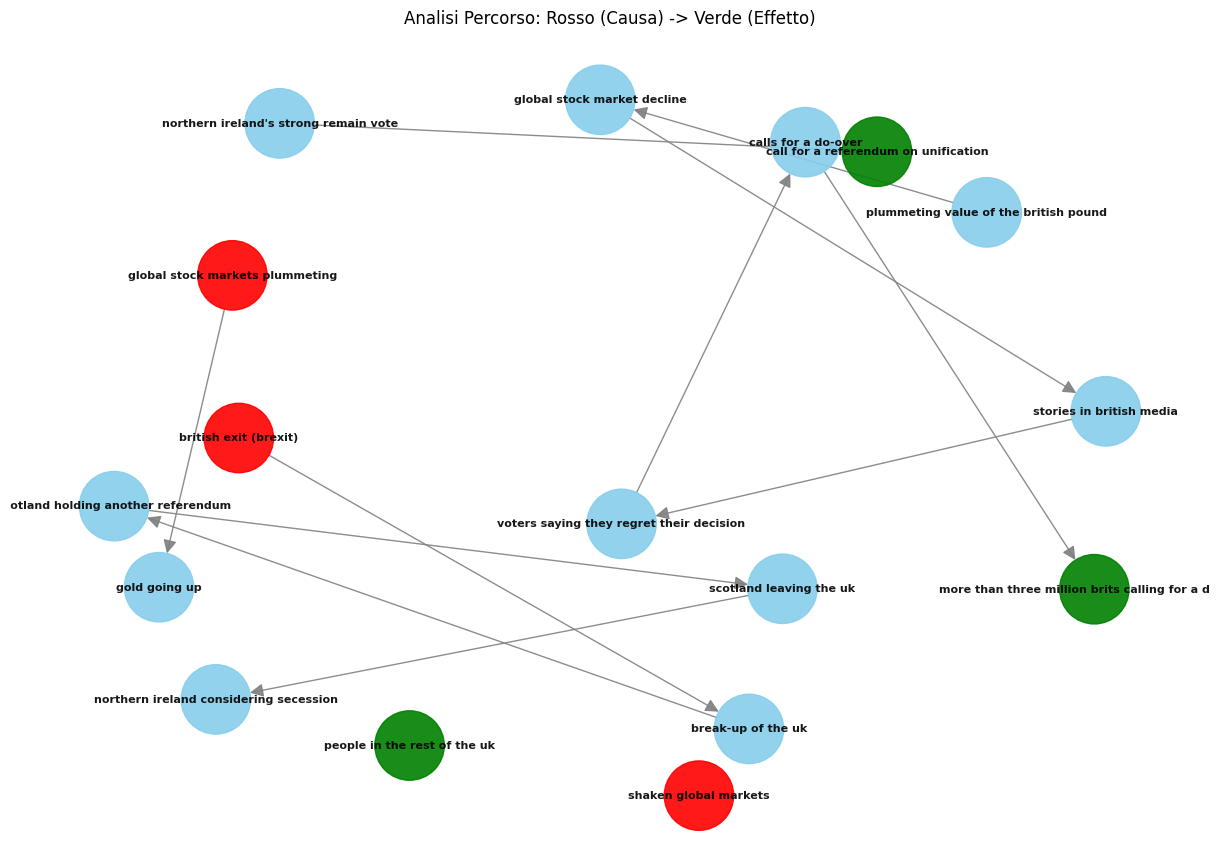


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['global stock markets plummeting']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Scotland becoming independent from the UK --[CAUSES]--> northern ireland potentially seeking independence
- A British exit from the European Union --[LEADS TO]--> uk breaking into separate entities
- Global stock markets experiencing a sharp decline --[RESULT IN]--> gold prices increasing
- UK breaking into separate entities --[CAUSES]--> scotland deciding to hold another referendum
- Decrease in global stock values

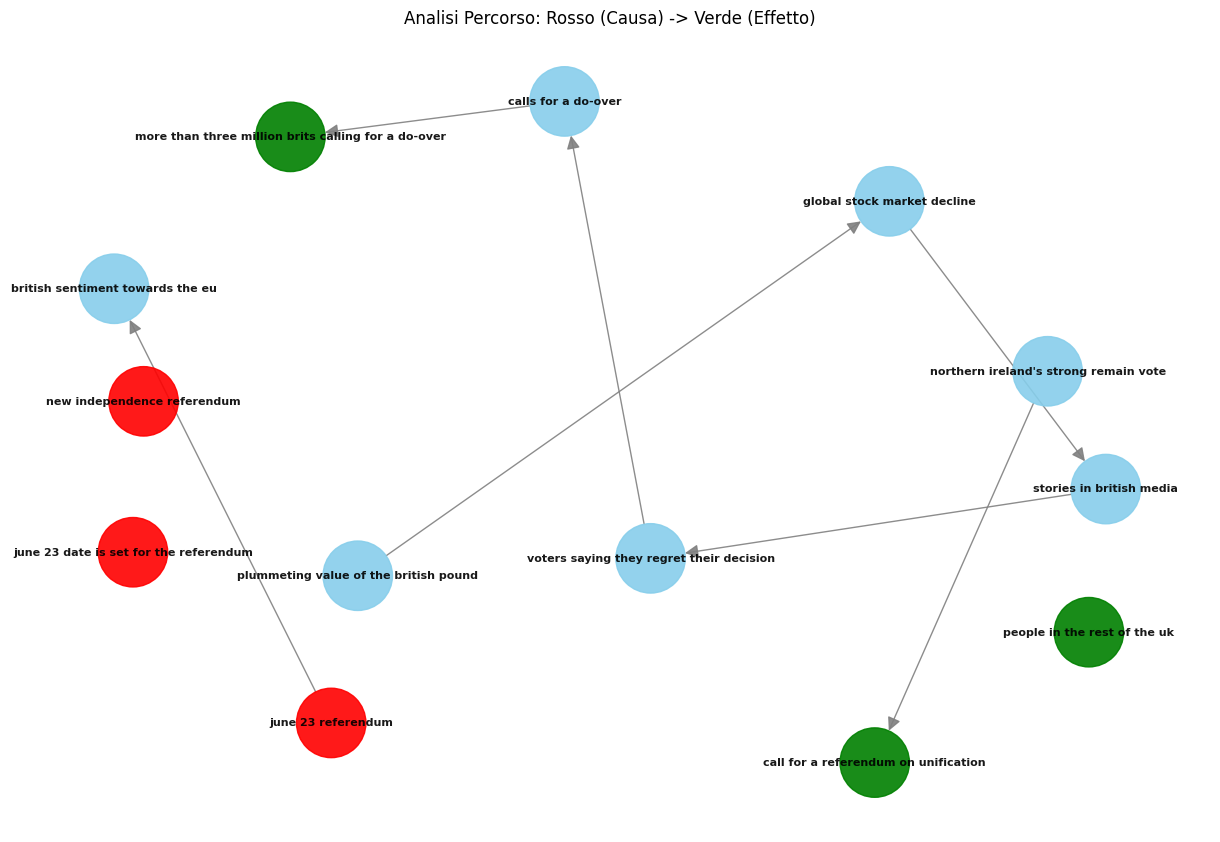


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- Decrease in global stock values --[CAUSES]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[CAUSES]--> statements from voters express

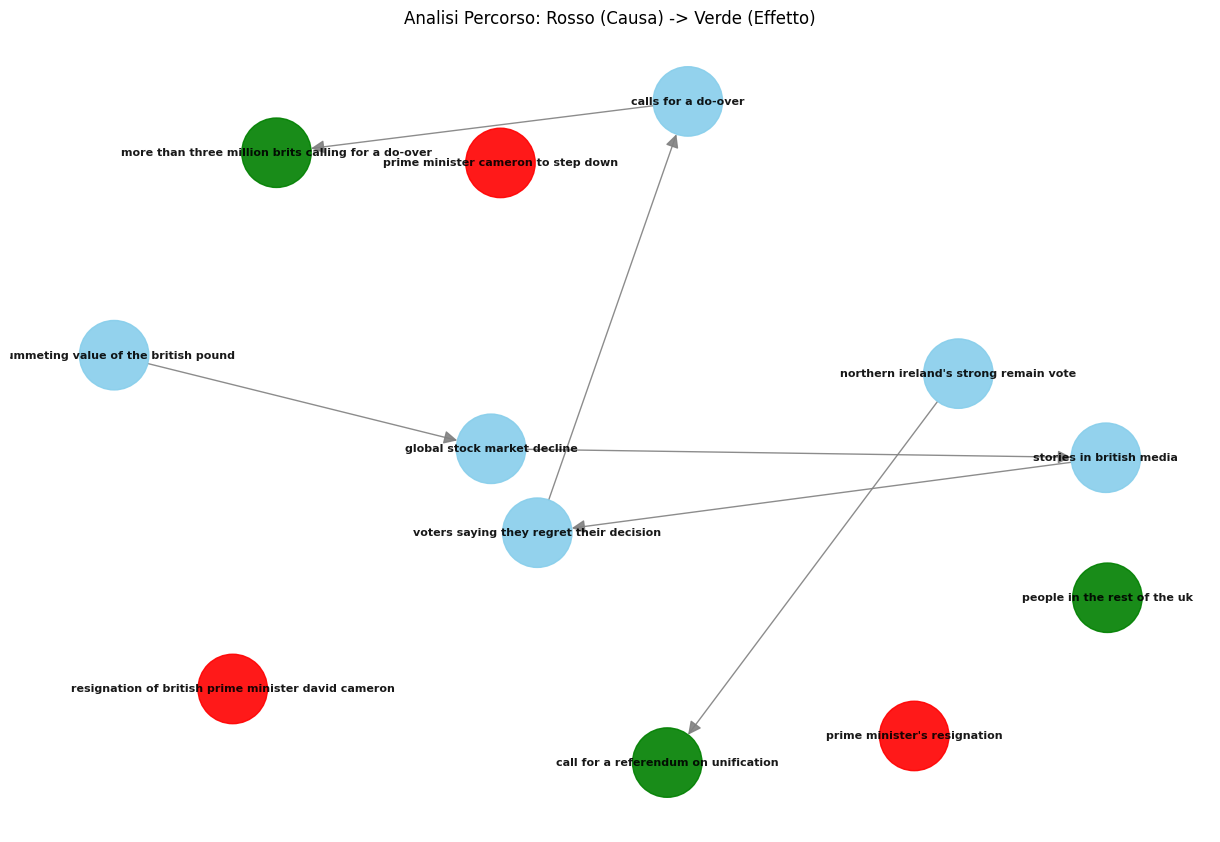


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Decrease in global stock values --[CAUSES]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[CAUSES]--> statements from voters expressing regret over their brex

 67%|██████▋   | 8/12 [00:56<00:28,  7.12s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The United Kingdom held a referendum on June 23.
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 4, expanded effect nodes 4 


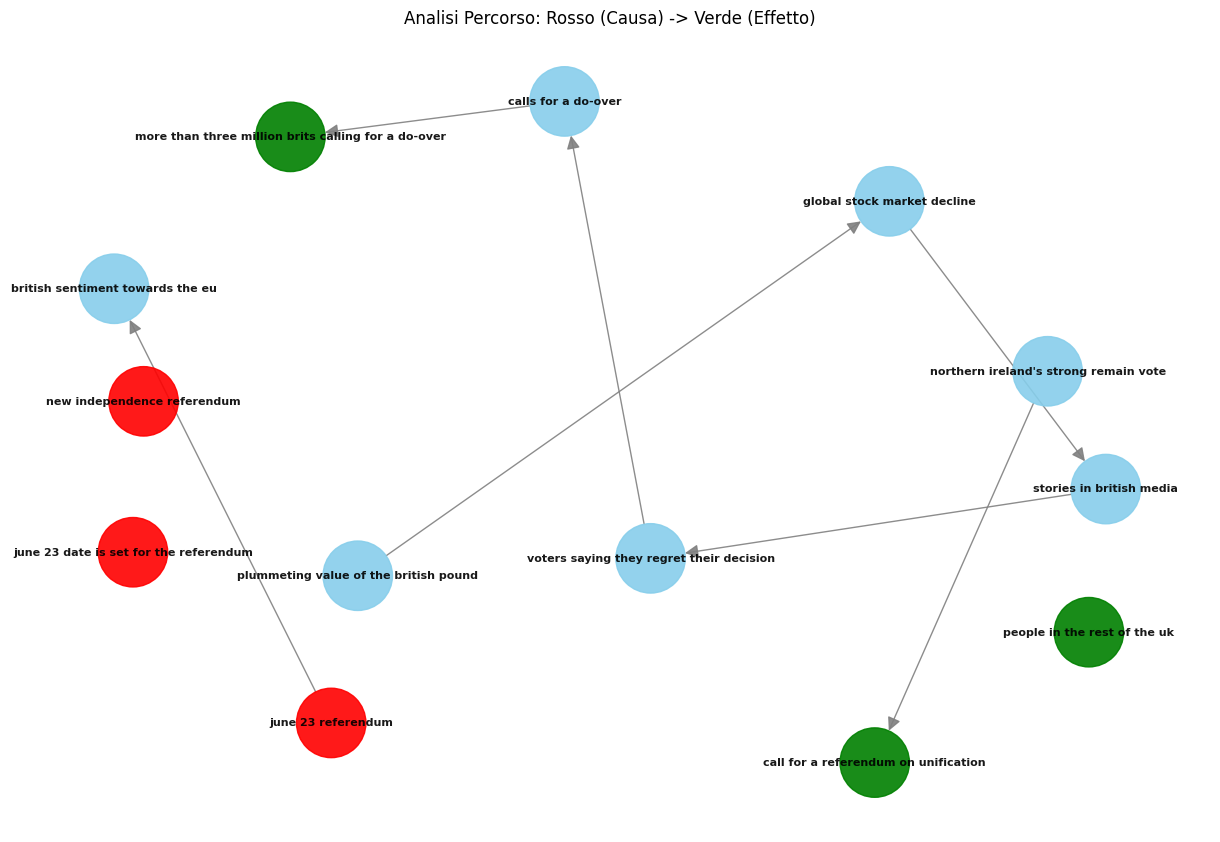


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- Decrease in global stock values --[CAUSES]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[CAUSES]--> statements from voters express

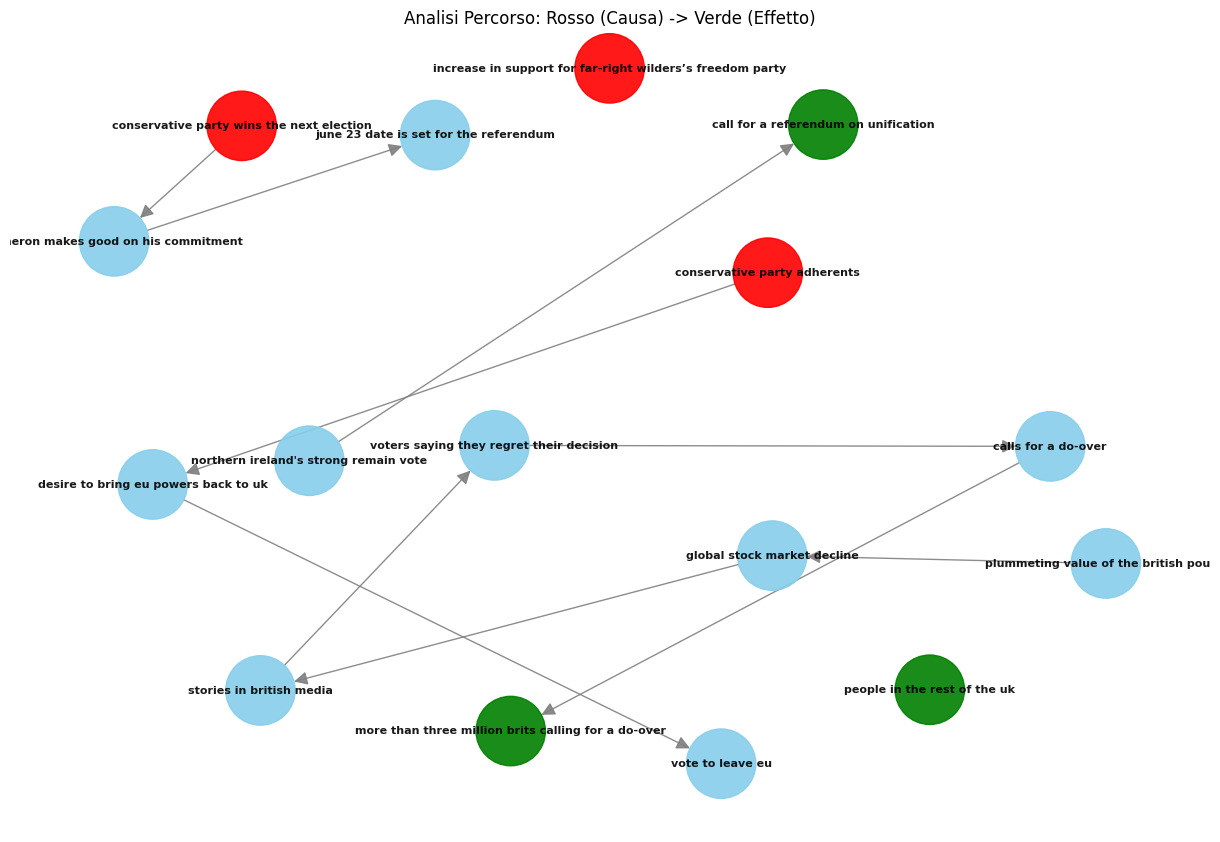


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['conservative party wins the next election', 'conservative party adherents']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Desire of nearly two-thirds of the UK public to bring back some EU powers from Brussels to London --[CAUSES]--> the brexit vote
- Prime Minister Cameron fulfills his promise to hold the referendum on the UK's EU membership --[CAUSES]--> the specific date of june 23 is chosen for the eu membership referendum
- 77% of Conservative Party adherents --[CAUSES]--> desire of nearly

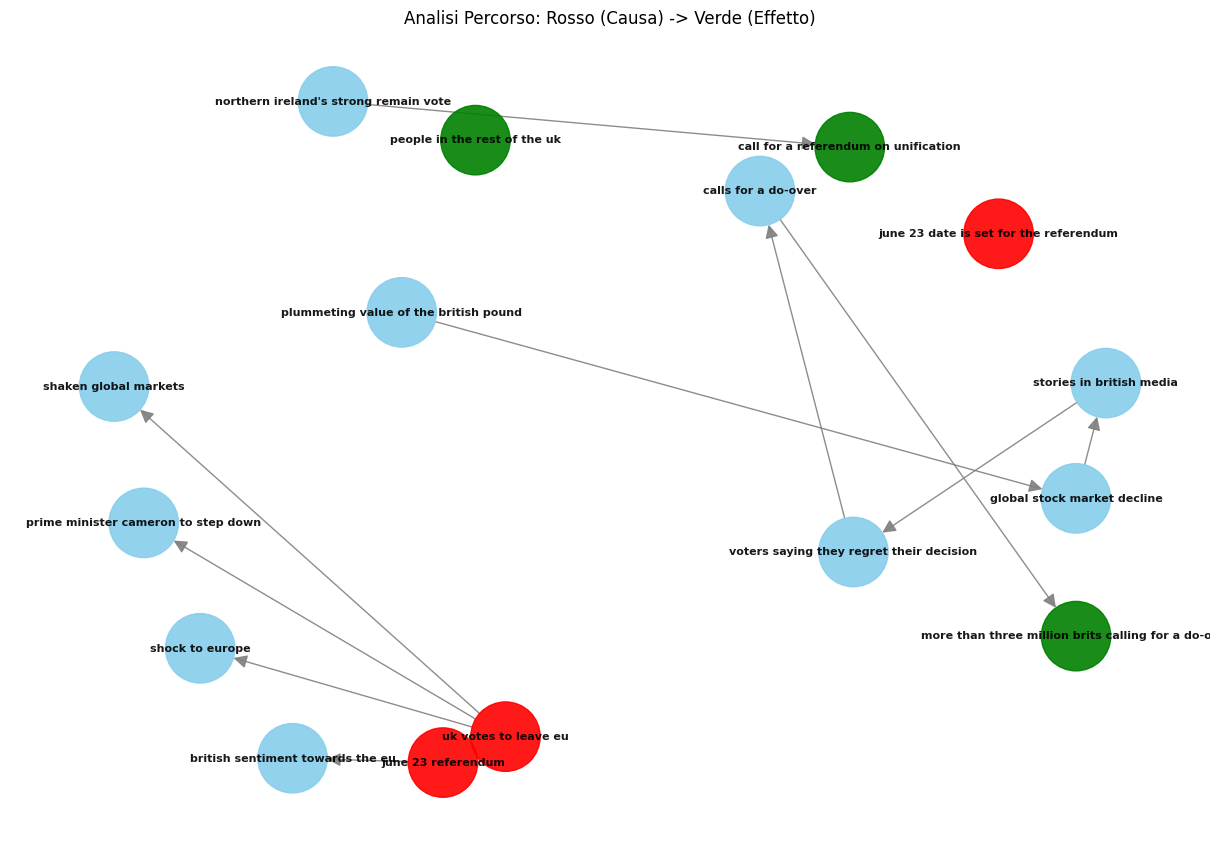


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their cont

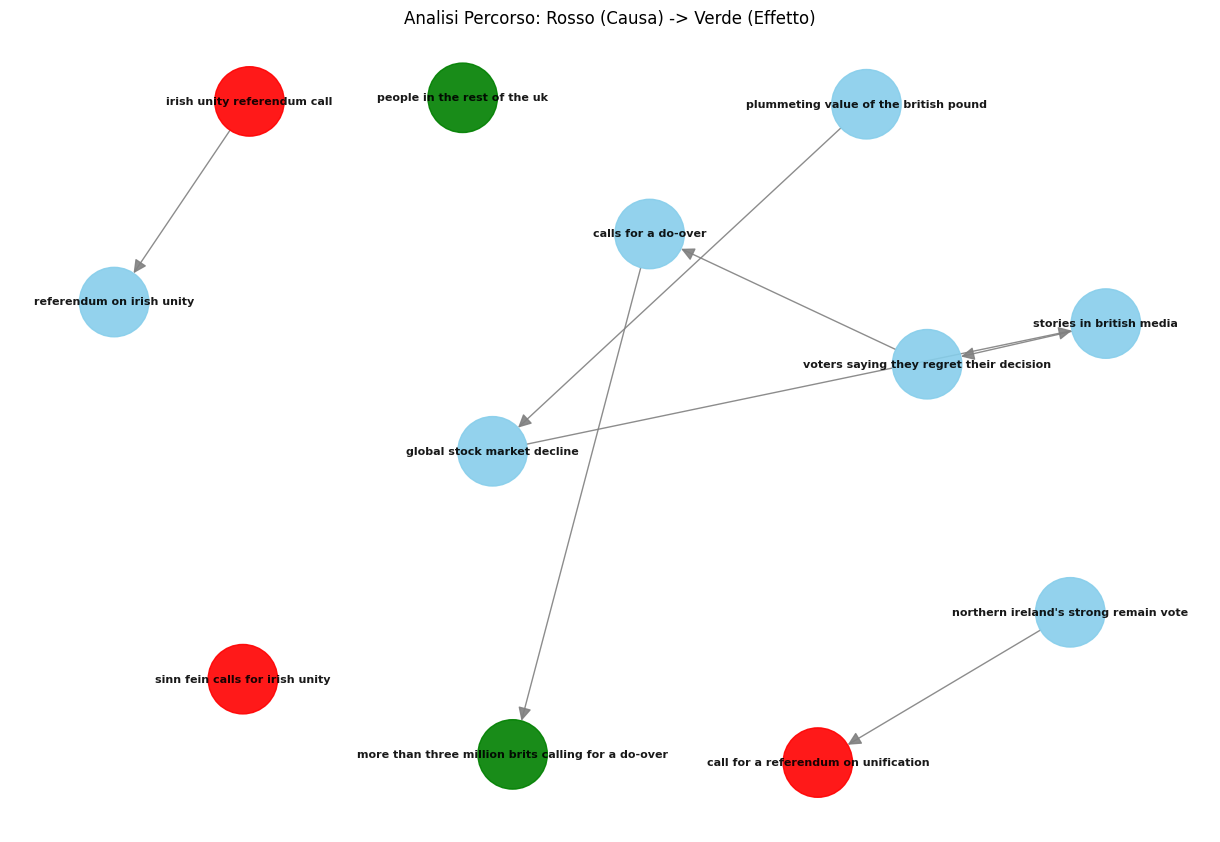


- call for a referendum on unification
Predicted FALSE


 75%|███████▌  | 9/12 [01:03<00:21,  7.17s/it]Device set to use cuda:0


Event Global markets plunged following the Brexit vote.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option David Cameron announced his resignation as Prime Minister.
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['global stock markets plummeting']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 3, expanded effect nodes 3 


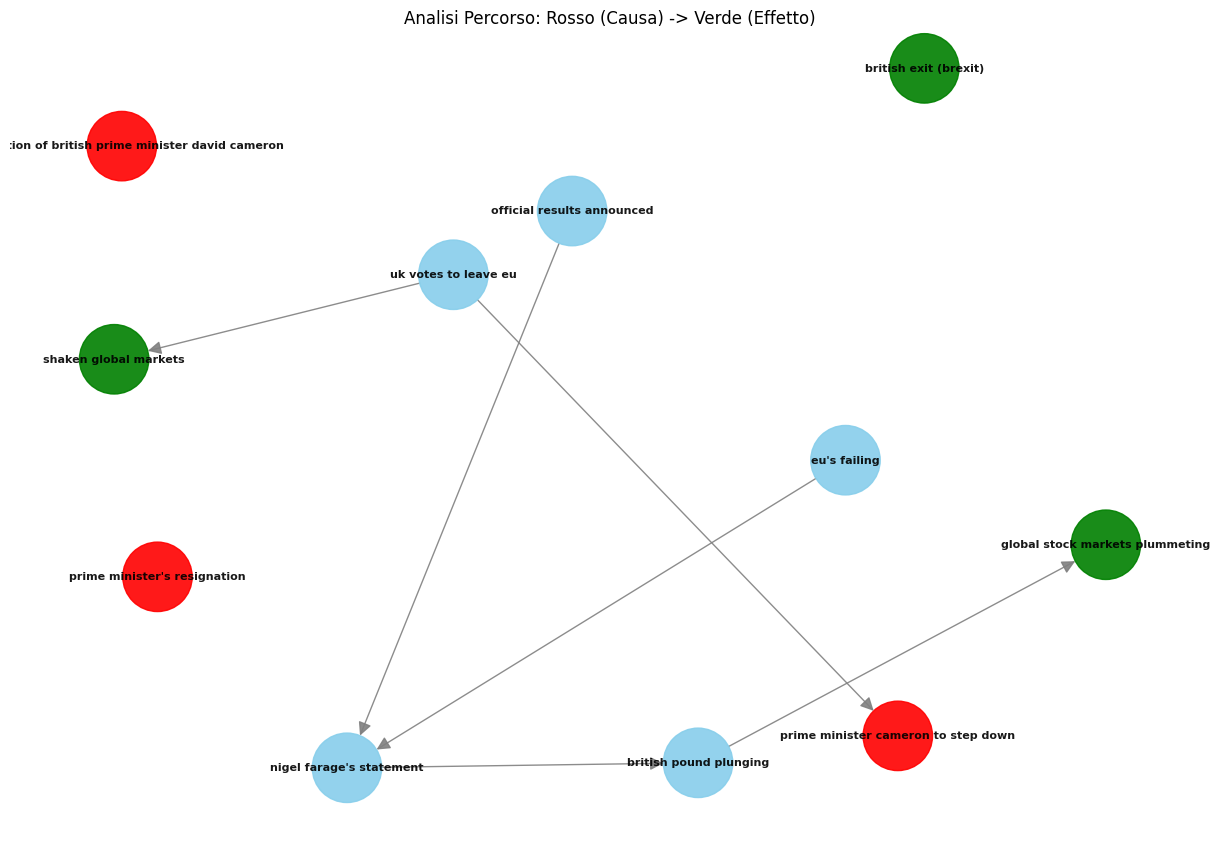


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farag

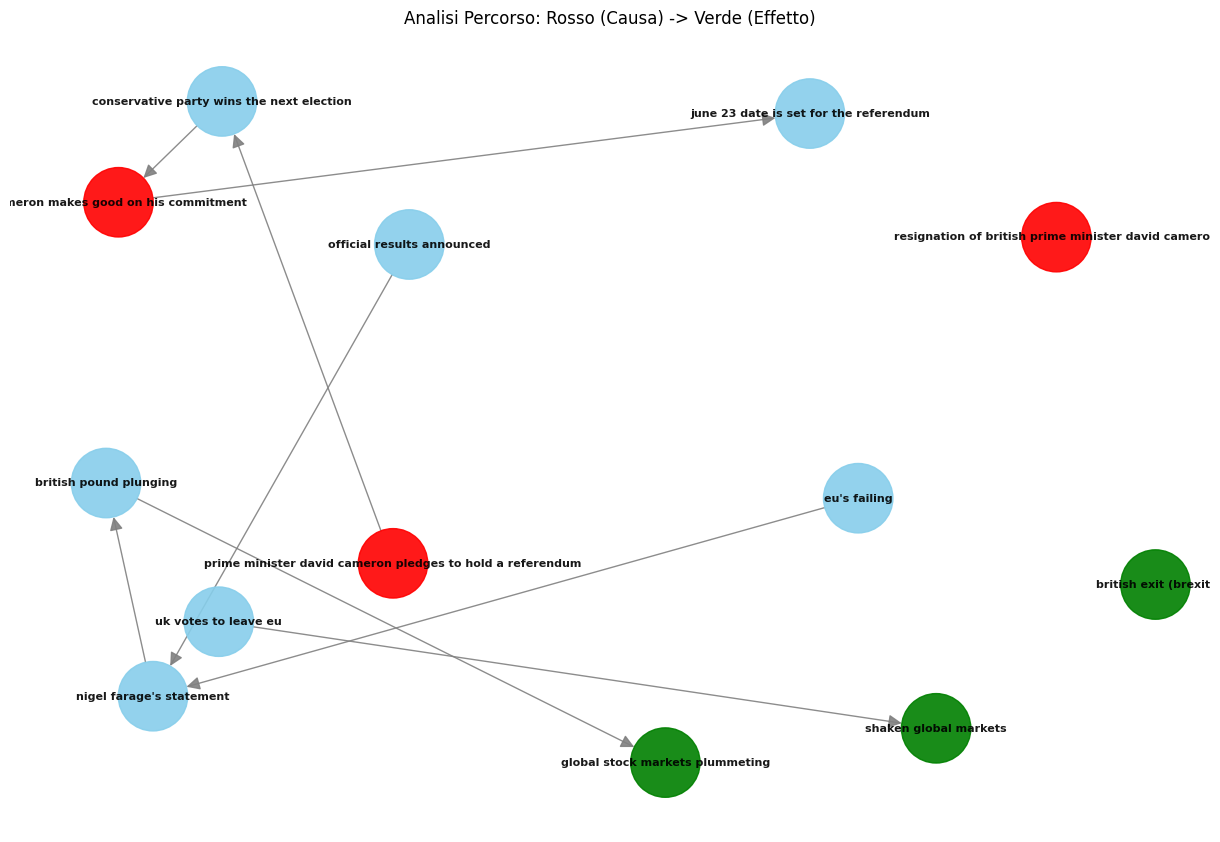


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['prime minister david cameron pledges to hold a referendum', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- Prime Minister David Cameron commits to holding a referendum on the UK's membership in the EU --[CAUSES]--> conservative party secures victory in the upcoming election
- The perceived failure and weakening of the European Union --[LEADS TO]--

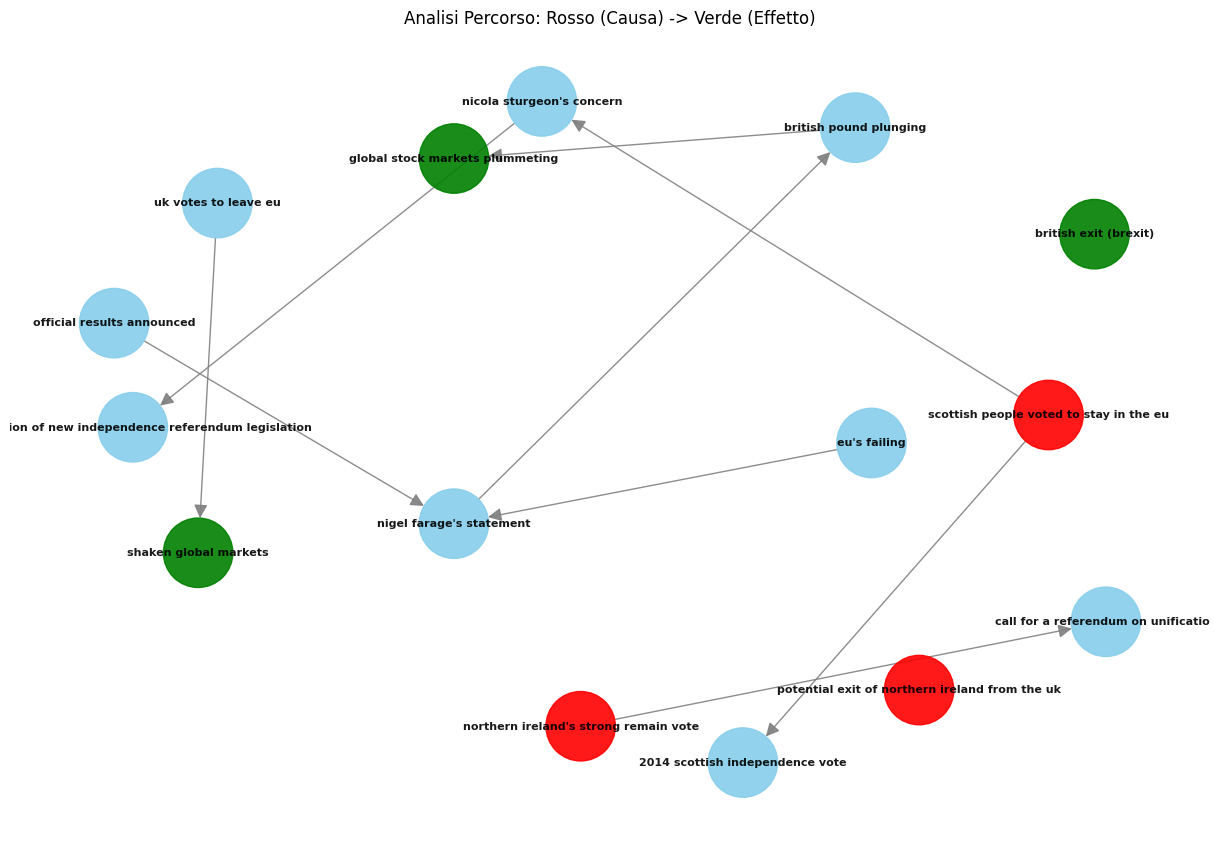


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['potential exit of northern ireland from the uk', "northern ireland's strong remain vote"]
Nodi trovati da entrambi: ['global stock markets plummeting']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Value of the British pound dropping significantly --[CAUSES]--> global stock markets experiencing a sharp decline
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Nicola Sturgeon expressing that the outcome is democratically unacceptable --[LEADS TO]--> scottish government beginning to prepare legislation for a new independence referendum
- Majority of Scottish people voting to stay in the EU in a

 83%|████████▎ | 10/12 [01:09<00:13,  6.74s/it]Device set to use cuda:0


Event The British pound plunged in value.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The nation divided into 'remain' and 'leave' camps.
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 9, expanded effect nodes 9 


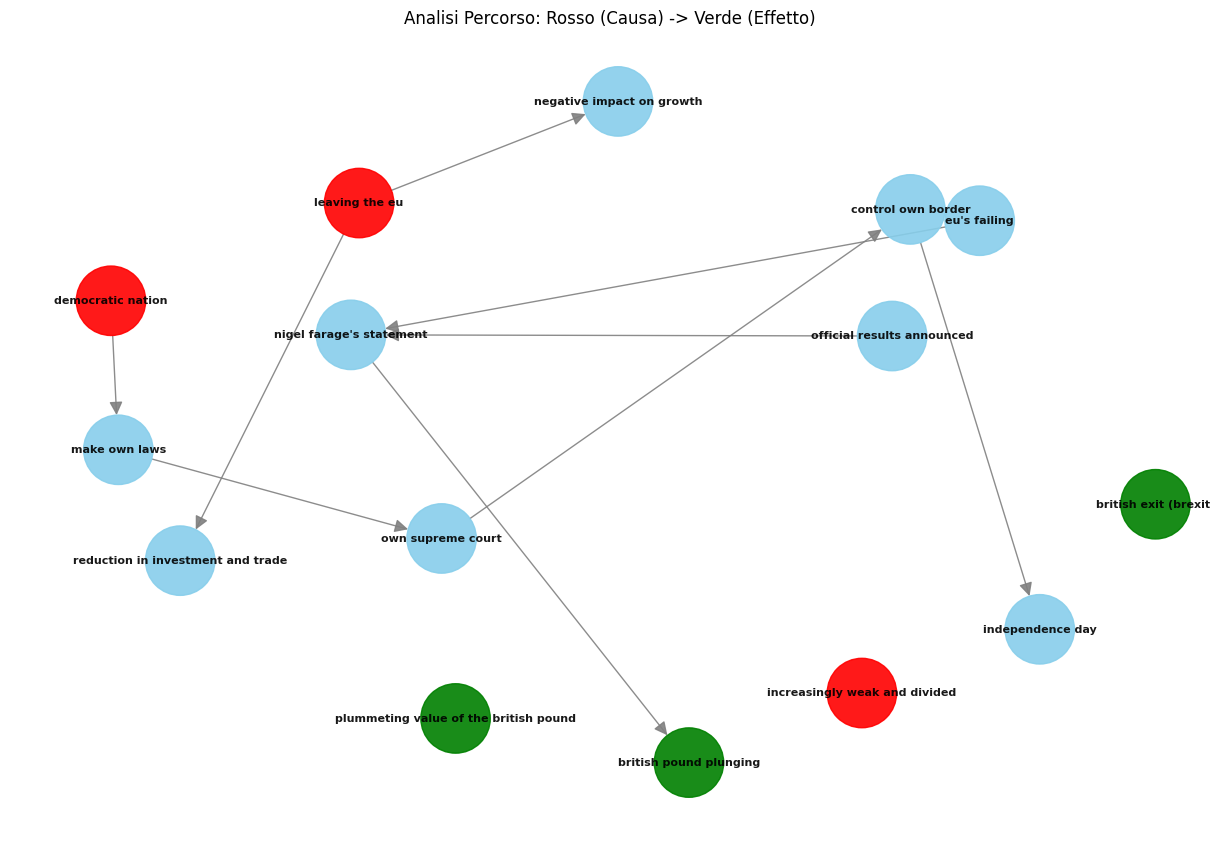


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: []
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The United Kingdom leaving the European Union --[CAUSES]--> uncertainty reducing investment and trade
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Wishing to manage immigration policies independently --[CAUSES]--> becoming the 184th independent country in the world
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring the eu's failing and predicting other countries to leave
- The United Kingdom leaving the European Union --[CAUSES]--> negative impact on growth in the uk and the rest of the eu and, in fact, the world
- 

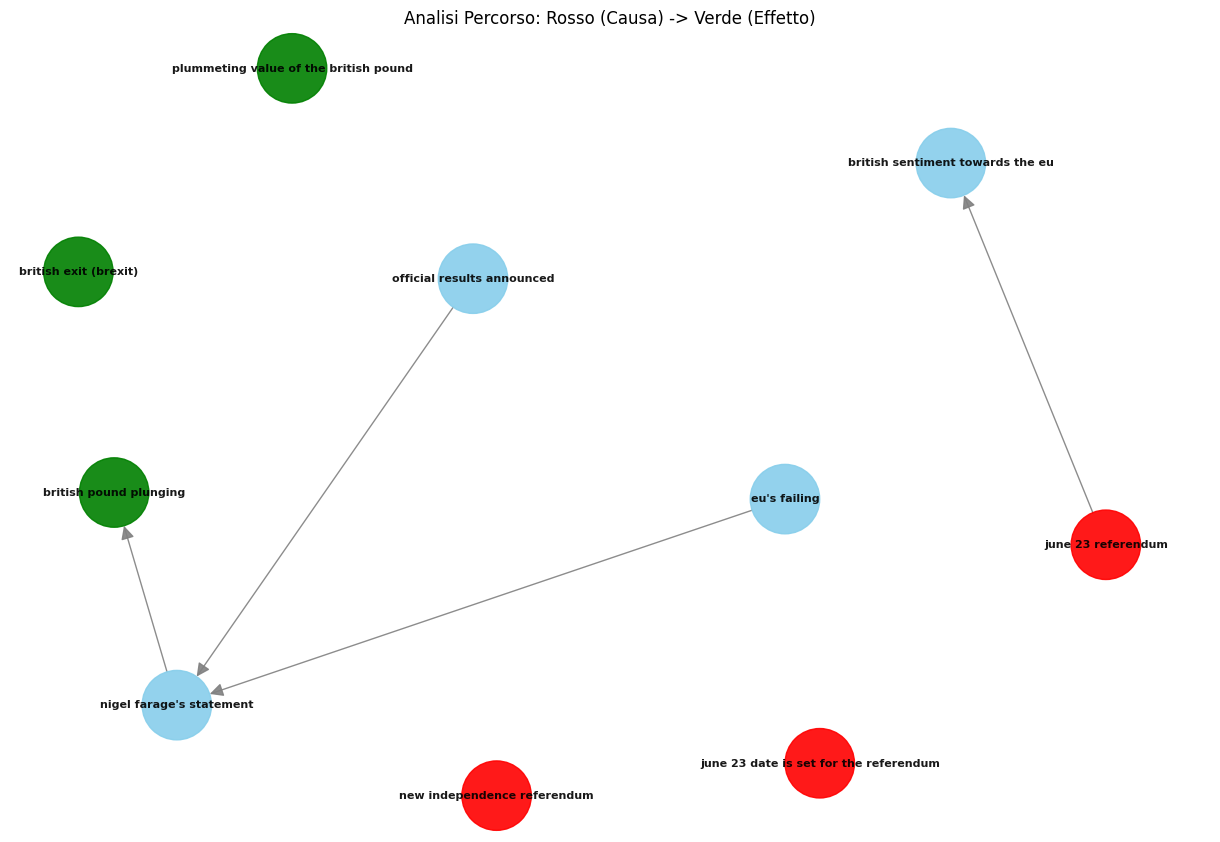


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Nigel Farage declaring the EU's failing and predicting other countries to leave --[LEADS TO]--> value of the british pound dropping significantly
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- The perceived failure and weakening of the European Union --[LEADS TO]--> nigel farage declaring

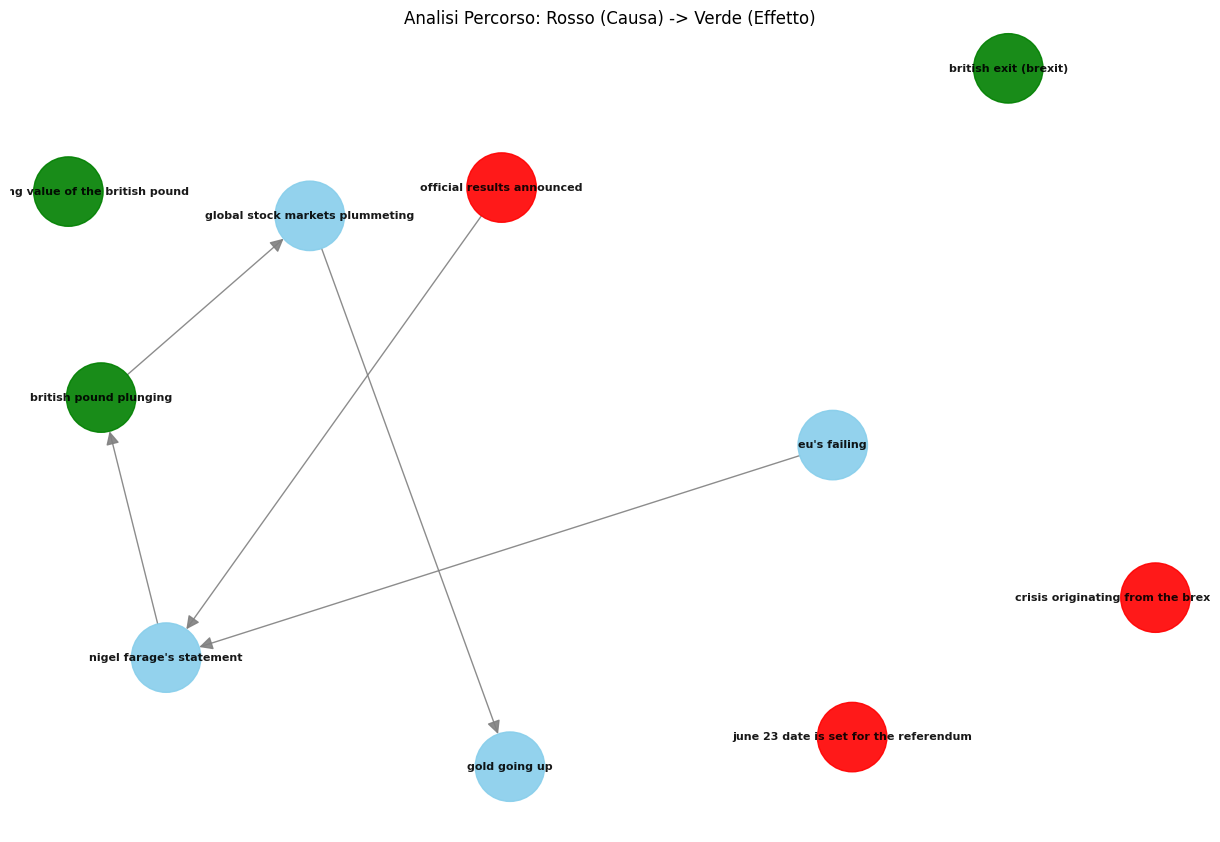

- Official announcement of the referendum results --[causes]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Nigel Farage declaring the EU's failing and predicting other countries to leave --[leads to]--> value of the british pound dropping significantly
Predicted FALSE
Option The UK voted to leave the EU in a June 23 referendum.
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


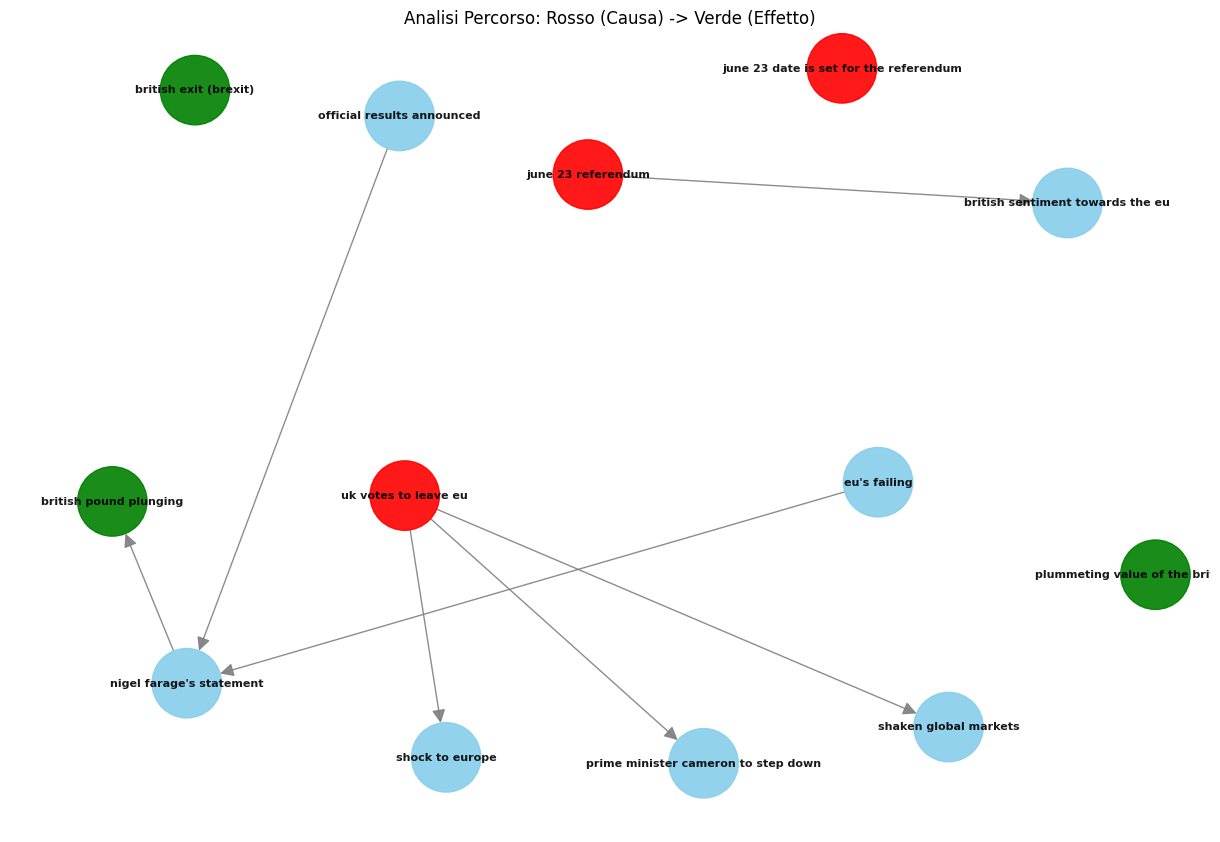


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['british pound plunging', 'plummeting value of the british pound', 'british exit (brexit)']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- Official announcement of the referendum results --[CAUSES]--> nigel farage declaring the eu's failing and predicting other countries to leave
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- The perceived failure and weakening of the European

 92%|█████████▏| 11/12 [01:16<00:06,  6.83s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 579 nodi, 372 archi. BM25 pronto.
Option The United Kingdom held a referendum on June 23.
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 4, expanded effect nodes 4 


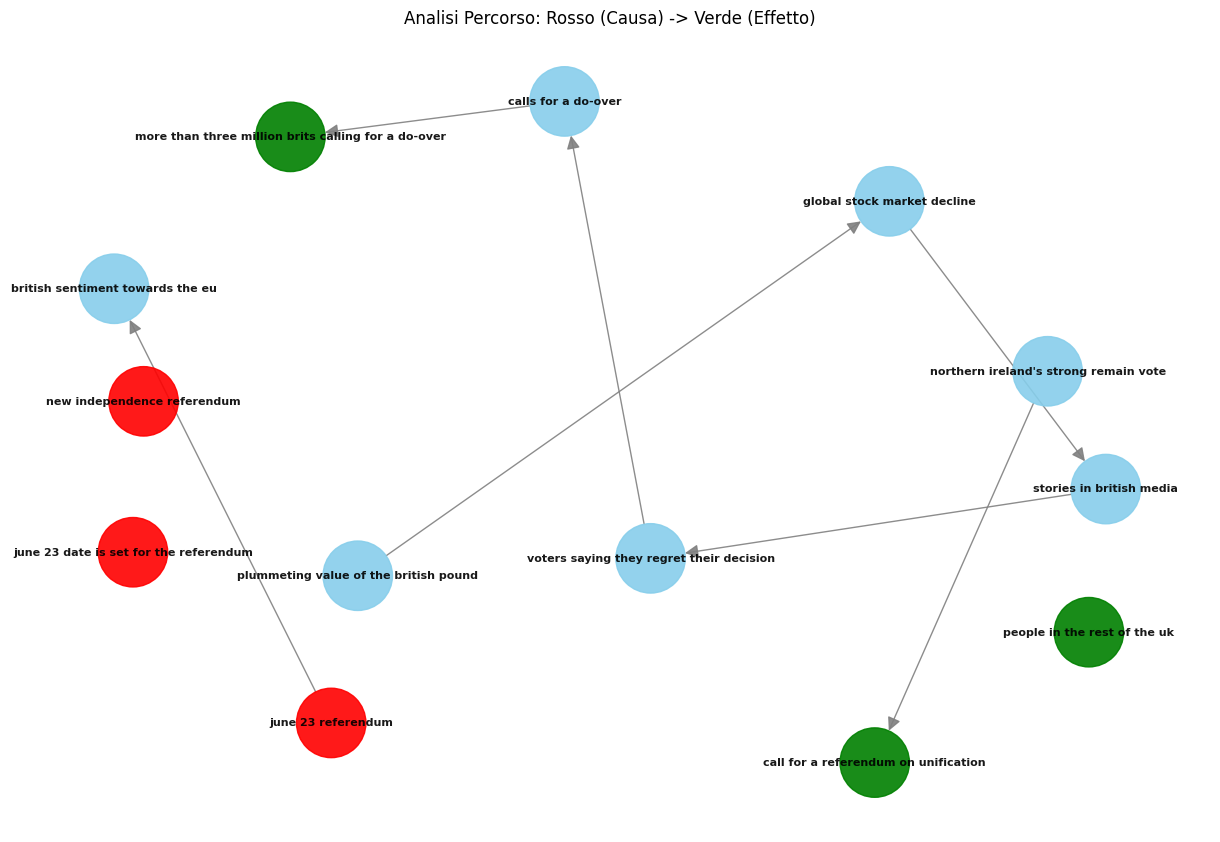


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'new independence referendum', 'june 23 date is set for the referendum']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their continental counterparts
- Decrease in global stock values --[CAUSES]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[CAUSES]--> statements from voters express

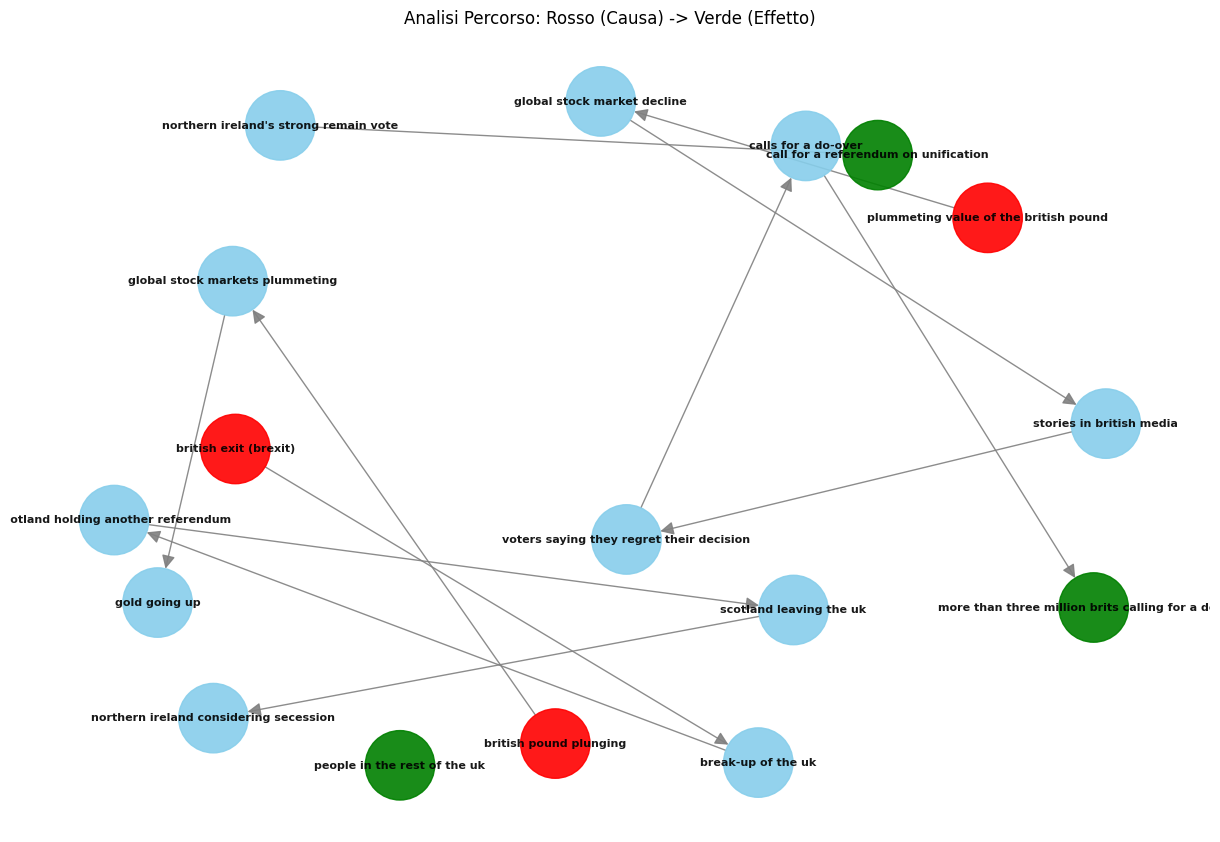

- The sudden and significant drop in the value of the British pound --[causes]--> decrease in global stock values
- Decrease in global stock values --[causes]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[causes]--> statements from voters expressing regret over their brexit vote
- Statements from voters expressing regret over their Brexit vote --[causes]--> requests from british citizens to change their votes
- Requests from British citizens to change their votes --[causes]--> over three million brits requesting to change their votes by sunday morning
Predicted TRUE
Option The UK voted to leave the EU in a June 23 referendum.
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
cause nodes: 3, effect nodes 3 
expanded cause nodes: 7, expanded effect nodes 7 


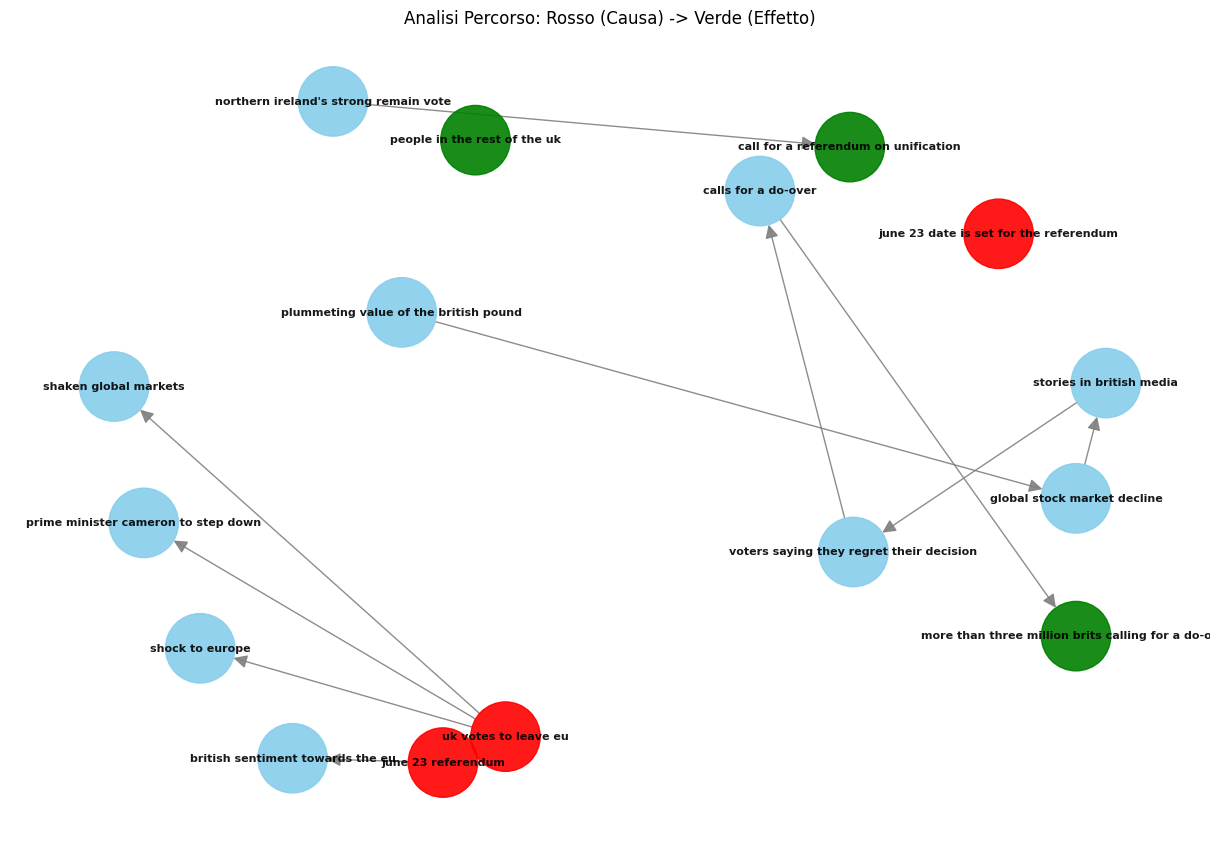


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['june 23 referendum', 'uk votes to leave eu']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> surprise and shock among european countries
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Voters in the U.K. deciding to leave the European Union --[CAUSES]--> disruption and volatility in global financial markets
- The June 23 referendum where the public voted 52% to 48% to leave the EU --[REMINDS]--> that the british have never been as enamored with the eu as most of their cont

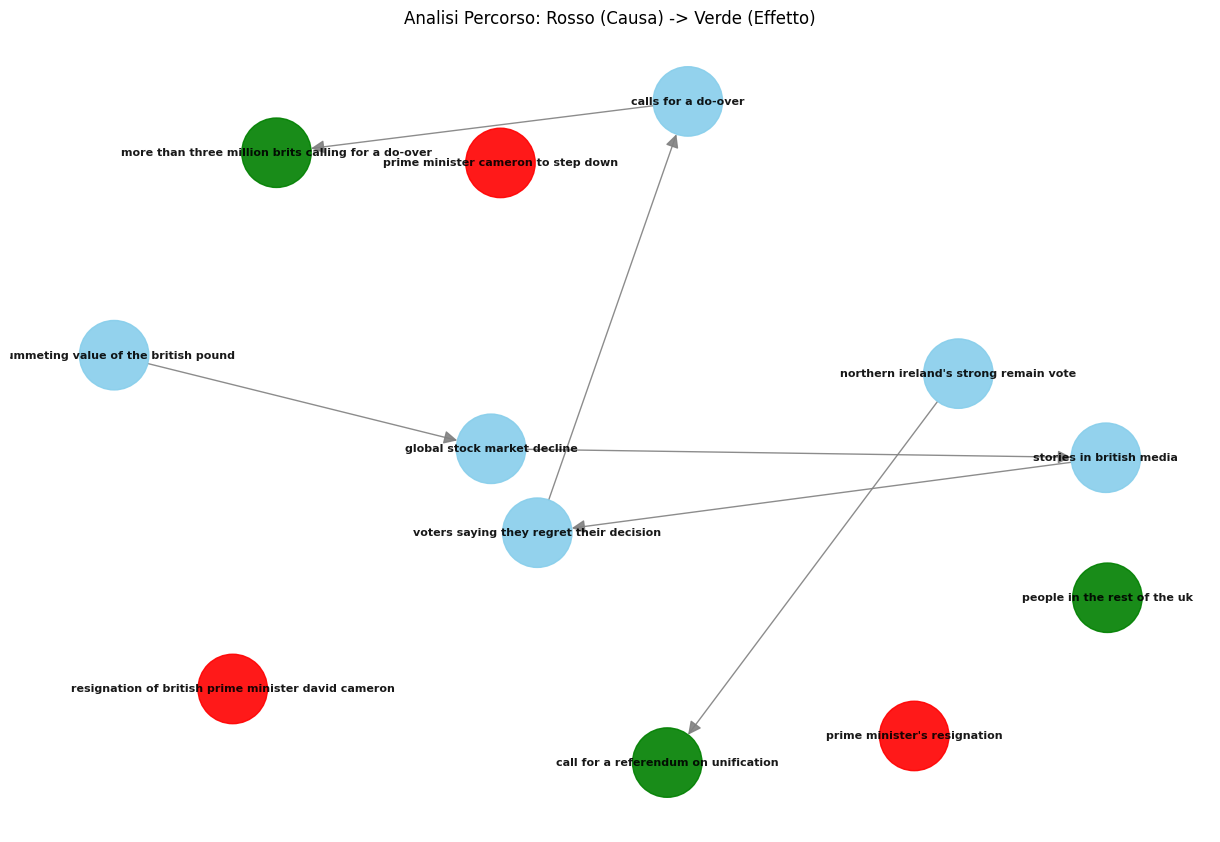


 NO PATH FOUND - Esecuzione ricerca bidirezionale ed espansione
Nodi trovati da entrambi: ['resignation of british prime minister david cameron', "prime minister's resignation", 'prime minister cameron to step down', 'prime minister david cameron pledges to hold a referendum', 'announcement of resignation', 'cameron makes good on his commitment']
Nodi trovati da entrambi: ['more than three million brits calling for a do-over']
Direct path not found. Contextual evidence found through bidirectional search:

Relevant causal chains in context:
- The sudden and significant drop in the value of the British pound --[CAUSES]--> decrease in global stock values
- Northern Ireland's strong Remain vote --[LEAD TO]--> sinn fein chairman declan kearney called for a referendum on unification with ireland
- Decrease in global stock values --[CAUSES]--> coverage of voter regret and confusion
- Coverage of voter regret and confusion --[CAUSES]--> statements from voters expressing regret over their brex

100%|██████████| 12/12 [01:23<00:00,  6.96s/it]


In [48]:
import gc   # garbage collector
from utils.model_utils import format_qwen_prompt
from utils.output_utils import clean_response, calculate_score, print_metrics
import json
import langchain.globals
import os
import pickle

WRONG_ANSWERS_FILE = "/content/WRONG.jsonl"
RIGHT_ANSWERS_FILE = "/content/RIGHT.jsonl"

total_score = 0
count = 0
errors = 0
results=[]
processed_uuids=set()

i=1
# we use tqdm to see the progress bar
questions_id_1 = [q for q in questions if q.get('topic_id') == 1]
print(f"Starting evaluation on {len(questions_id_1)} questions...")
for entry in tqdm(questions_id_1):
    # Inizializziamo a None per evitare errori nel blocco 'del'
    inputs = None
    outputs = None

    try:
        topic_id = entry['topic_id']
        #question_uuid = entry['uuid']
        golden_ans = entry['golden_answer']
        target_event = entry['target_event']
        #RAG

        print(f"Event {target_event}")
        #all chunks for item id
        vector_db = vector_db_per_topic.get(topic_id, [])

        all_prompts_responses={}
        none_of_the_others= None
        pred_set= set()

        #load preprocessed causalRAG
        causal_rag= CausalRAG(model, tokenizer, k=3, s=5)
        load_causal_rag(causal_rag, topic_id=topic_id, folder="/content/rag_graph")

        for op_label in ['A', 'B', 'C', 'D']:

          option_text= entry[f'option_{op_label}']
          print(f"Option {option_text}")
          # none of the others detection
          if "none of the others are correct causes" in option_text.lower().strip():
            none_of_the_others= op_label
            continue

          # select 1 more util chuncks

          cause= option_text
          effect=target_event
          context_text= retrieve_causal_summary_3( causal_rag, cause, effect)
          print(context_text)
          # Prompt binary------------------------------------------
          prompt_inference= format_qwen_prompt_binary(tokenizer, entry, context_text , op_label)

          # 2. Tokenization
          inputs = tokenizer(prompt_inference, return_tensors="pt").to(model.device)
          # 3. Generation (Greedy decoding for reproducibility)
          with torch.no_grad():
              outputs = model.generate(
              **inputs,
              max_new_tokens=10,
              do_sample=False,      # Determinism
              temperature=0.0,
              pad_token_id=tokenizer.eos_token_id
          )
          # 4. Decoding e Cleaning
          # Cutting the input prompt -> the response of the model also contains the input prompt we provided
          generated_ids = outputs[0][inputs.input_ids.shape[1]:]
          # Extract true or false
          raw_response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
          clean_response= clean_verifier_response(raw_response)
          all_prompts_responses[op_label]={ 'response': clean_response,
                                            'prompt': prompt_inference,
                                            }
          print(f"Predicted {clean_response}")
          if clean_response.upper().strip() == "TRUE":
            pred_set.add(op_label)

        # outise the loop
        if pred_set == set():
          if none_of_the_others:
            pred_set.add(none_of_the_others)
          else:
            print("no answer")


      # 5. Calculate score
        score = calculate_score(pred_set, golden_ans)
        if score!=1:
          # save wrong answer
          obj = {}
          with open(WRONG_ANSWERS_FILE, 'a', encoding='utf-8') as f:
            obj = all_prompts_responses
            obj["gold"]= golden_ans
            obj["pred"]= list(pred_set)
            f.write( json.dumps(obj, indent=3))
        else:
            obj = {}
            with open(RIGHT_ANSWERS_FILE, 'a', encoding='utf-8') as f:
              obj = all_prompts_responses
              obj["gold"]= golden_ans
              obj["pred"]= list(pred_set)
              f.write( json.dumps(obj, indent=3))


        # We prepare the result object (a list of result_item, which is the following dictionare)
        result_item = {
            #"uuid": question_uuid,
            "topic_id": topic_id,
            "golden_raw": golden_ans,
            "prediction_raw": raw_response,
            "prediction_set": list(pred_set),
            "score": score
        }


        # Updating variables in memory
        results.append(result_item)
        #processed_uuids.add(question_uuid)
        total_score += score
        count += 1

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"UUID:{entry['uuid']} process skipped due to OOM")
            errors += 1
            continue
        else:
            print(f"Errore generico: {e}")
            continue
    finally:
        # Questo blocco viene eseguito SEMPRE, sia se il codice va bene sia se crasha
        if inputs is not None: inputs = None  # Reassign to None instead of del
        if outputs is not None: outputs = None # Reassign to None instead of del
        torch.cuda.empty_cache()
        gc.collect()

In [49]:
from utils.output_utils import print_metrics
print_metrics(results, "Qwen")

======= Qwen Causal Reasoning Results =======
Total questions: 12
Correct answers: 5 - 41.66666666666667%
Partial answers: 2 - 16.666666666666664%
Wrong answers: 5 - 41.66666666666667%
Total score: 6.0
Performance of the score: 50.0%


In [ ]:
from difflib import SequenceMatcher

nodes = list(causal_rag.graph.nodes())
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        ratio = SequenceMatcher(None, nodes[i], nodes[j]).ratio()
        if ratio > 0.8:
            print(f"Possibili duplicati: '{nodes[i]}' <-> '{nodes[j]}' (Score: {ratio:.2f})")

# Creazione di tutti i grafi 

In [ ]:
# creo i grafi per TUTTI i documenti (8 h)

# Inizializza dizionario
causal_RAG_per_topic = dict()

print("Creating vector databases with chunk indices...")

for topic_id, docs_list in tqdm(docs_by_topic.items(), desc="Processing topics"):
    vector_db = vector_db_per_topic.get(topic_id, [])

    if vector_db:
        # Trucco per estrarre tutti i documenti da FAISS:
        # Accediamo alla memoria interna (docstore)
        all_dict = vector_db.docstore._dict
        chunks_from_db = list(all_dict.values())
        causal_rag_topic= CausalRAG(model, tokenizer, k=3, s=3)
        # Ora puoi passarli al CausalRAG
        causal_rag_topic.index_documents( [doc for doc in chunks_from_db])
        save_topic_data(causal_rag=causal_rag_topic , vector_db=vector_db, topic_id=topic_id, folder="/kaggle/working/causal_data")
